In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import time
import tensorflow as tf

# Read our New York registrations Dataset

In [2]:
NYS_registrations_df = pd.read_csv('Resources/NYS Electric Vehicle Registrations.csv')
NYS_registrations_df.head()

Record Type              VIN Registration Class       City State    Zip  \
0         VEH      96722014661                SRF     BOVINA    NY  13740   
1         VEH          9106843                SRF   GLENDALE    NY  11385   
2         VEH       909SR2223A                SRF   STAFFORD    NY  14143   
3         VEH  9E2SPAXBC113501                PSD  JOHNSTOWN    NY  12095   
4         VEH         9A204759                SPC   BROOKLYN    NY  11211   

     County  Model Year   Make Body Type Fuel Type  Unladen Weight  \
0  DELAWARE        1972   SAAB      2DSD  ELECTRIC          2000.0   
1    QUEENS        1974    EVA      4DSD  ELECTRIC          2180.0   
2   GENESEE        1979  CITIC      2DSD  ELECTRIC           850.0   
3    FULTON        2012  VANTA      PICK  ELECTRIC          1900.0   
4     KINGS        2014  CROWN      P/SH  ELECTRIC          3335.0   

   Maximum Gross Weight  Passengers Reg Valid Date Reg Expiration Date Color  \
0                   NaN         NaN     05/04/2021          06/26/2023    WH   
1                   NaN         NaN     09/21/2021          10/03/2023    BR   
2                   NaN         NaN     05/12/2021          04/01/2023    GR   
3                   NaN         NaN     07/01/2014                 NaN    WH   
4                   NaN         NaN     12/09/2021          12/31/2022    WH   

  Scofflaw Indicator Suspension Indicator Revocation Indicator  
0                  N                    N                    N  
1                  N                    N                    N  
2                  N                    N                    N  
3                  N                    N                    N  
4                  N                    N                    N

In [3]:
NYS_registrations_df.columns

Index(['Record Type', 'VIN', 'Registration Class', 'City', 'State', 'Zip',
       'County', 'Model Year', 'Make', 'Body Type', 'Fuel Type',
       'Unladen Weight', 'Maximum Gross Weight', 'Passengers',
       'Reg Valid Date', 'Reg Expiration Date', 'Color', 'Scofflaw Indicator',
       'Suspension Indicator', 'Revocation Indicator'],
      dtype='object')

In [4]:
#  Let's drop the columns we will not use
# We choose to drop the columns below because they do not have an inpact on our analysis
drop_cols = ['Record Type', 'Unladen Weight', 'Maximum Gross Weight', 'Passengers',
          'Reg Expiration Date', 'Color', 'Scofflaw Indicator',
       'Suspension Indicator', 'Revocation Indicator']
NYS_registrations_df.drop(drop_cols, axis=1, inplace=True)
NYS_registrations_df.head()

VIN Registration Class       City State    Zip    County  \
0      96722014661                SRF     BOVINA    NY  13740  DELAWARE   
1          9106843                SRF   GLENDALE    NY  11385    QUEENS   
2       909SR2223A                SRF   STAFFORD    NY  14143   GENESEE   
3  9E2SPAXBC113501                PSD  JOHNSTOWN    NY  12095    FULTON   
4         9A204759                SPC   BROOKLYN    NY  11211     KINGS   

   Model Year   Make Body Type Fuel Type Reg Valid Date  
0        1972   SAAB      2DSD  ELECTRIC     05/04/2021  
1        1974    EVA      4DSD  ELECTRIC     09/21/2021  
2        1979  CITIC      2DSD  ELECTRIC     05/12/2021  
3        2012  VANTA      PICK  ELECTRIC     07/01/2014  
4        2014  CROWN      P/SH  ELECTRIC     12/09/2021

In [5]:
# Current Registrations VIN count
Registration = NYS_registrations_df.VIN.count()
Registration

62063

In [6]:
NYS_registrations_df['Reg Valid Date'] = pd.to_datetime(NYS_registrations_df['Reg Valid Date'])
NYS_registrations_df.head()

VIN Registration Class       City State    Zip    County  \
0      96722014661                SRF     BOVINA    NY  13740  DELAWARE   
1          9106843                SRF   GLENDALE    NY  11385    QUEENS   
2       909SR2223A                SRF   STAFFORD    NY  14143   GENESEE   
3  9E2SPAXBC113501                PSD  JOHNSTOWN    NY  12095    FULTON   
4         9A204759                SPC   BROOKLYN    NY  11211     KINGS   

   Model Year   Make Body Type Fuel Type Reg Valid Date  
0        1972   SAAB      2DSD  ELECTRIC     2021-05-04  
1        1974    EVA      4DSD  ELECTRIC     2021-09-21  
2        1979  CITIC      2DSD  ELECTRIC     2021-05-12  
3        2012  VANTA      PICK  ELECTRIC     2014-07-01  
4        2014  CROWN      P/SH  ELECTRIC     2021-12-09

In [7]:
# We will be using the m/y information to clean duplicates 
NYS_registrations_df['Registration year'] = NYS_registrations_df['Reg Valid Date'].dt.strftime("%Y")

# Then we will adjust the index of our New York registration Database
NYS_registrations_df.set_index('Reg Valid Date', inplace=True)
NYS_registrations_df.head()

VIN Registration Class       City State    Zip  \
Reg Valid Date                                                               
2021-05-04          96722014661                SRF     BOVINA    NY  13740   
2021-09-21              9106843                SRF   GLENDALE    NY  11385   
2021-05-12           909SR2223A                SRF   STAFFORD    NY  14143   
2014-07-01      9E2SPAXBC113501                PSD  JOHNSTOWN    NY  12095   
2021-12-09             9A204759                SPC   BROOKLYN    NY  11211   

                  County  Model Year   Make Body Type Fuel Type  \
Reg Valid Date                                                    
2021-05-04      DELAWARE        1972   SAAB      2DSD  ELECTRIC   
2021-09-21        QUEENS        1974    EVA      4DSD  ELECTRIC   
2021-05-12       GENESEE        1979  CITIC      2DSD  ELECTRIC   
2014-07-01        FULTON        2012  VANTA      PICK  ELECTRIC   
2021-12-09         KINGS        2014  CROWN      P/SH  ELECTRIC   

               Registration year  
Reg Valid Date                    
2021-05-04                  2021  
2021-09-21                  2021  
2021-05-12                  2021  
2014-07-01                  2014  
2021-12-09                  2021

# Looking for duplicates

In [8]:
# let's see the duplicates accross the data set
duplicates = NYS_registrations_df[NYS_registrations_df.duplicated()]
duplicates.count()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
Registration year     0
dtype: int64

In [9]:
# inspection of City duplicates
NYS_registrations_df[NYS_registrations_df.duplicated('City')]

VIN Registration Class           City State  \
Reg Valid Date                                                              
2022-01-31      7SAYGDEF9NF365467                PAS       BROOKLYN    NY   
2022-01-12      7SAYGDEF9NF337765                OMT       BROOKLYN    NY   
2021-12-15      7SAYGDEF9NF328094                PAS          BRONX    NY   
2021-12-18      7SAYGDEF9NF326491                PAS       NEW YORK    NY   
2022-01-18      7SAYGDEF9NF325096                PAS  STATEN ISLAND    NY   
...                           ...                ...            ...   ...   
2021-10-27            A976B08198T                SPC       BROOKLYN    NY   
2021-10-27            A976B07325S                SPC       BROOKLYN    NY   
2021-10-27            A976B06198R                SPC       BROOKLYN    NY   
2014-07-18            A969N02801M                PSD         CORONA    NY   
2014-08-06              A83T50116                PSD         CORONA    NY   

                  Zip    County  Model Year   Make Body Type Fuel Type  \
Reg Valid Date                                                           
2022-01-31      11249     KINGS        2022  TESLA      SUBN  ELECTRIC   
2022-01-12      11229     KINGS        2022  TESLA      SUBN  ELECTRIC   
2021-12-15      10465     BRONX        2022  TESLA      SUBN  ELECTRIC   
2021-12-18      10025  NEW YORK        2022  TESLA      SUBN  ELECTRIC   
2022-01-18      10305  RICHMOND        2022  TESLA      SUBN  ELECTRIC   
...               ...       ...         ...    ...       ...       ...   
2021-10-27      11232     KINGS        2019   YALE       SWT  ELECTRIC   
2021-10-27      11232     KINGS        2018   YALE      P/SH  ELECTRIC   
2021-10-27      11232     KINGS        2017   YALE      P/SH  ELECTRIC   
2014-07-18      11368    QUEENS        2014   YALE      P/SH  ELECTRIC   
2014-08-06      11368    QUEENS        2010    TCM      P/SH  ELECTRIC   

               Registration year  
Reg Valid Date                    
2022-01-31                  2022  
2022-01-12                  2022  
2021-12-15                  2021  
2021-12-18                  2021  
2022-01-18                  2022  
...                          ...  
2021-10-27                  2021  
2021-10-27                  2021  
2021-10-27                  2021  
2014-07-18                  2014  
2014-08-06                  2014  

[60077 rows x 11 columns]

In [10]:
# inspection of Date/VIN/County duplicates
inspection= NYS_registrations_df[NYS_registrations_df.duplicated(subset=['Registration year','VIN', 'County'], keep=False)].sort_values('VIN')
inspection.count()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
Registration year     0
dtype: int64

In [11]:
# inspection of Date/VIN duplicates
inspect_date_vin = NYS_registrations_df[NYS_registrations_df.duplicated(subset=['Registration year','VIN'], keep=False)].sort_values('VIN')
inspect_date_vin.count()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
Registration year     0
dtype: int64

# Addressing potential Null Values

In [12]:
NYS_registrations_df.isna().sum()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
Registration year     0
dtype: int64

In [13]:
NYS_registrations_df['Make'].unique()

array(['SAAB', 'EVA', 'CITIC', 'VANTA', 'CROWN', 'DE/EL', 'MANIT',
       'HONDA', 'TESLA', 'AMPER', 'PROTE', 'VOLVO', 'CENNT', 'ARCIM',
       'RIVIA', 'TOYOT', 'WORKH', 'GENZE', 'LEXUS', 'ALTA', 'ZERO',
       'ZE/MO', 'AZURE', 'FORD', 'THINK', 'GREEN', 'SCOUT', 'NAVIS',
       'INTER', 'STAR', 'POLAR', 'GEM', 'GLOBA', 'LINDE', 'BRAMM',
       'AM/GE', 'KARMA', 'KARM', 'LUCID', 'CRUS', 'MOKE', 'CR/CA', 'TESL',
       'BMW', 'TO/OU', 'ACURA', 'CLUBC', 'CL/CA', 'CLUB', 'PATH', 'ZO/EL',
       'NEWFL', 'NE/FL', 'COLUM', 'TOMBE', 'SPARK', 'SMITH', 'UTILI',
       'NOVA', 'NOVB', 'NO/BU', 'IC', 'CR/CO', 'MITSU', 'LINCO', 'RAM',
       'ZENIT', 'ZENTI', 'FIAT', 'PIAGG', 'CHEVR', 'GMC', 'ZENN', 'CHRYS',
       'LION', 'GILLI', 'DETRO', 'VOLKS', 'ASVE', 'EA/BE', 'COM', 'COMUT',
       'CO/CA', 'KALMA', 'AMPHI', 'CRAYL', 'CUSHM', 'EZ/GO', 'OHAWA',
       'ORANG', 'ORAN', 'ZELEC', 'ZEV', 'ORION', 'OROIN', 'ORON', 'IRION',
       'OTION', 'NISSA', 'PRO', 'JOHND', 'JO/DE', 'LI/SE', 'STING',
    

In [14]:
len(NYS_registrations_df['Make'].unique())

197

In [15]:
# Next we can see some vehicles name are just mispelled or have an a different name , we will group by the OEM.
NYS_registrations_df['Make'].replace(['CROWN', 'TOYOT'], 'TOYOTA', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['ORION','OTION','OROIN','IRION','ORON','ENERG'], 'FORD', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['NOVB', 'NOVA','IRION'], 'NOVA BUS', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['NEWFL', 'NE/FL'], 'NEW FLYER', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['DOOH', 'DOOHA'], 'DOOHAN', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['JAGUA','JAG'], 'JAGUAR', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['ORAN','ORANG'], 'ORANGE EV', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['MILE','MILES'], 'MILES EV', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['GENU','GENUI'], 'GENESIS', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['KARM', 'FISKE','KALMA'], 'KARMA', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['PIAGG','VESPA'], 'PIAGGIO', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['ZERO','ZE/MO'], 'ZERO EV', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['POLRD','POLAR','POLES','POLE'], 'POLESTAR', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['CITIC','CITC'], 'HONDA', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['VOLKS', 'SCOUT'],'VOLKSWAGEN',
                    inplace=True)
NYS_registrations_df['Make'].replace(['CHRIS','CHRYS','CRAYL'], 
                    'CHRYSLER', inplace=True)
NYS_registrations_df['Make'].replace('SUBAR', 'SUBARU', inplace=True)
NYS_registrations_df['Make'].replace('TESL', 'TESLA', inplace=True)
NYS_registrations_df['Make'].replace('FREIG', 'FREIGHT LINER', inplace=True)
NYS_registrations_df['Make'].replace('PORSC', 'PORSCHE', inplace=True)
NYS_registrations_df['Make'].replace('NIUU', 'NIU', inplace=True)
NYS_registrations_df['Make'].replace('LINCO', 'LINCOLN', inplace=True)
NYS_registrations_df['Make'].replace('VANTA', 'BMW', inplace=True)
NYS_registrations_df['Make'].replace('CASE', 'CAKE', inplace=True)
NYS_registrations_df['Make'].replace('NISSA', 'NISSAN', inplace=True)
NYS_registrations_df['Make'].replace('SUZUK', 'SUZUKI', inplace=True)
NYS_registrations_df['Make'].replace('RIVIA', 'RIVIAN', inplace=True)
NYS_registrations_df['Make'].replace('GREEN', 'GREENPOWER MOTORS', inplace=True)
NYS_registrations_df['Make'].replace('HYUND', 'HYUNDAI', inplace=True)
NYS_registrations_df['Make'].replace('CENNT', 'CENNTRO', inplace=True)
NYS_registrations_df['Make'].replace('PROTE', 'PROTERRA', inplace=True)
NYS_registrations_df['Make'].replace(['INTER','STAR','OTHER'], 'INTERNATIONAL',
                                     inplace=True)
NYS_registrations_df['Make'].replace(['MITSU','FUSO' ],'MITSUBISHI', 
                                     inplace=True)
NYS_registrations_df['Make'].replace(['IC','ICE','IC/PN' ],'ICBUS', 
                                     inplace=True)
NYS_registrations_df['Make'].replace('ZELEC', 'ZELECTRIC MOTORS', inplace=True)
NYS_registrations_df['Make'].replace('KAWAS', 'KAWASAKI', inplace=True)
NYS_registrations_df['Make'].replace('EVA', 'EVI', inplace=True)
NYS_registrations_df['Make'].replace('EVTA', 'EVT', inplace=True)
NYS_registrations_df['Make'].replace('CHEVR', 'CHEVROLET', inplace=True)

In [16]:
NYS_registrations_df['Make'].unique()

array(['SAAB', 'EVI', 'HONDA', 'BMW', 'TOYOTA', 'DE/EL', 'MANIT', 'TESLA',
       'AMPER', 'PROTERRA', 'VOLVO', 'CENNTRO', 'ARCIM', 'RIVIAN',
       'WORKH', 'GENZE', 'LEXUS', 'ALTA', 'ZERO EV', 'AZURE', 'FORD',
       'THINK', 'GREENPOWER MOTORS', 'VOLKSWAGEN', 'NAVIS',
       'INTERNATIONAL', 'POLESTAR', 'GEM', 'GLOBA', 'LINDE', 'BRAMM',
       'AM/GE', 'KARMA', 'LUCID', 'CRUS', 'MOKE', 'CR/CA', 'TO/OU',
       'ACURA', 'CLUBC', 'CL/CA', 'CLUB', 'PATH', 'ZO/EL', 'NEW FLYER',
       'COLUM', 'TOMBE', 'SPARK', 'SMITH', 'UTILI', 'NOVA BUS', 'NO/BU',
       'ICBUS', 'CR/CO', 'MITSUBISHI', 'LINCOLN', 'RAM', 'ZENIT', 'ZENTI',
       'FIAT', 'PIAGGIO', 'CHEVROLET', 'GMC', 'ZENN', 'CHRYSLER', 'LION',
       'GILLI', 'DETRO', 'ASVE', 'EA/BE', 'COM', 'COMUT', 'CO/CA',
       'AMPHI', 'CUSHM', 'EZ/GO', 'OHAWA', 'ORANGE EV',
       'ZELECTRIC MOTORS', 'ZEV', 'NISSAN', 'PRO', 'JOHND', 'JO/DE',
       'LI/SE', 'STING', 'HA/DA', 'LIVEW', 'MEVH', 'CADIL',
       'FREIGHT LINER', 'TRANT', 'EGO', 'ETU

In [17]:
len(NYS_registrations_df['Make'].unique())
# A DROP FROM 197 TO 162

162

In [18]:
NYS_registrations_df

VIN Registration Class       City State    Zip  \
Reg Valid Date                                                               
2021-05-04          96722014661                SRF     BOVINA    NY  13740   
2021-09-21              9106843                SRF   GLENDALE    NY  11385   
2021-05-12           909SR2223A                SRF   STAFFORD    NY  14143   
2014-07-01      9E2SPAXBC113501                PSD  JOHNSTOWN    NY  12095   
2021-12-09             9A204759                SPC   BROOKLYN    NY  11211   
...                         ...                ...        ...   ...    ...   
2021-10-27          A976B08198T                SPC   BROOKLYN    NY  11232   
2021-10-27          A976B07325S                SPC   BROOKLYN    NY  11232   
2021-10-27          A976B06198R                SPC   BROOKLYN    NY  11232   
2014-07-18          A969N02801M                PSD     CORONA    NY  11368   
2014-08-06            A83T50116                PSD     CORONA    NY  11368   

                  County  Model Year    Make Body Type Fuel Type  \
Reg Valid Date                                                     
2021-05-04      DELAWARE        1972    SAAB      2DSD  ELECTRIC   
2021-09-21        QUEENS        1974     EVI      4DSD  ELECTRIC   
2021-05-12       GENESEE        1979   HONDA      2DSD  ELECTRIC   
2014-07-01        FULTON        2012     BMW      PICK  ELECTRIC   
2021-12-09         KINGS        2014  TOYOTA      P/SH  ELECTRIC   
...                  ...         ...     ...       ...       ...   
2021-10-27         KINGS        2019    YALE       SWT  ELECTRIC   
2021-10-27         KINGS        2018    YALE      P/SH  ELECTRIC   
2021-10-27         KINGS        2017    YALE      P/SH  ELECTRIC   
2014-07-18        QUEENS        2014    YALE      P/SH  ELECTRIC   
2014-08-06        QUEENS        2010     TCM      P/SH  ELECTRIC   

               Registration year  
Reg Valid Date                    
2021-05-04                  2021  
2021-09-21                  2021  
2021-05-12                  2021  
2014-07-01                  2014  
2021-12-09                  2021  
...                          ...  
2021-10-27                  2021  
2021-10-27                  2021  
2021-10-27                  2021  
2014-07-18                  2014  
2014-08-06                  2014  

[62063 rows x 11 columns]

In [19]:
NYS_registrations_df['Make' ].value_counts()

TESLA        37137
NIU           6918
HYUNDAI       3130
FORD          3082
CHEVROLET     3044
             ...  
CUSHM            1
AMPHI            1
CO/CA            1
COMUT            1
TCM              1
Name: Make, Length: 162, dtype: int64

In [20]:
# Looking at the Make for Yale to see if it's actually a car.
# base on the registration class  SPC stand for self parking cars as found here https://www.allacronyms.com/SPC/car
NYS_registrations_df[NYS_registrations_df['Make' ]=='YALE']

VIN Registration Class       City State    Zip  \
Reg Valid Date                                                           
2021-12-09          N336261                SPC  HAUPPAUGE    NY  11788   
2021-11-21           N30346                SPC   NEW YORK    NY  10002   
2021-12-14      G807N09683P                SPC   BROOKLYN    NY  11218   
2021-11-24      G807N09057N                SPC   BROOKLYN    NY  11206   
2021-10-29      F807N04372D                SPC    ASTORIA    NY  11105   
2021-10-29      E216A01721E                SPC    ASTORIA    NY  11105   
2021-10-29      E216A01715E                SPC    ASTORIA    NY  11105   
2021-12-14      D875V06421P                SPC   BROOKLYN    NY  11218   
2021-12-14      D875V06225P                SPC   BROOKLYN    NY  11218   
2021-12-14      D875V05953P                SPC   BROOKLYN    NY  11218   
2021-10-29      D216A02259C                SPC   BETHPAGE    NY  11714   
2021-10-29      D216A02258C                SPC      BRONX    NY  10473   
2021-10-29      D216A02257C                SPC      BRONX    NY  10473   
2021-10-29      D216A02254C                SPC      BRONX    NY  10473   
2020-03-18      C839N02158H                PSD   FLUSHING    NY  11373   
2021-12-08      B974V02082N                SPC   BROOKLYN    NY  11214   
2021-11-23      B807N01689U                SPC   NEW YORK    NY  10002   
2022-01-24      A976B09580U                SPC   BROOKLYN    NY  11232   
2021-10-27      A976B08198T                SPC   BROOKLYN    NY  11232   
2021-10-27      A976B07325S                SPC   BROOKLYN    NY  11232   
2021-10-27      A976B06198R                SPC   BROOKLYN    NY  11232   
2014-07-18      A969N02801M                PSD     CORONA    NY  11368   

                  County  Model Year  Make Body Type Fuel Type  \
Reg Valid Date                                                   
2021-12-09       SUFFOLK        1978  YALE       SWT  ELECTRIC   
2021-11-21      NEW YORK        1972  YALE      P/SH  ELECTRIC   
2021-12-14         KINGS        2016  YALE      P/SH  ELECTRIC   
2021-11-24         KINGS        2015  YALE      P/SH  ELECTRIC   
2021-10-29        QUEENS        2006  YALE       SWT  ELECTRIC   
2021-10-29        QUEENS        2007  YALE       SWT  ELECTRIC   
2021-10-29        QUEENS        2007  YALE       SWT  ELECTRIC   
2021-12-14         KINGS        2016  YALE      P/SH  ELECTRIC   
2021-12-14         KINGS        2016  YALE      P/SH  ELECTRIC   
2021-12-14         KINGS        2016  YALE      P/SH  ELECTRIC   
2021-10-29        NASSAU        2005  YALE       SWT  ELECTRIC   
2021-10-29         BRONX        2005  YALE       SWT  ELECTRIC   
2021-10-29         BRONX        2005  YALE       SWT  ELECTRIC   
2021-10-29         BRONX        2005  YALE       SWT  ELECTRIC   
2020-03-18        QUEENS        2010  YALE       SWT  ELECTRIC   
2021-12-08         KINGS        2015  YALE      P/SH  ELECTRIC   
2021-11-23      NEW YORK        1997  YALE      P/SH  ELECTRIC   
2022-01-24         KINGS        2020  YALE      P/SH  ELECTRIC   
2021-10-27         KINGS        2019  YALE       SWT  ELECTRIC   
2021-10-27         KINGS        2018  YALE      P/SH  ELECTRIC   
2021-10-27         KINGS        2017  YALE      P/SH  ELECTRIC   
2014-07-18        QUEENS        2014  YALE      P/SH  ELECTRIC   

               Registration year  
Reg Valid Date                    
2021-12-09                  2021  
2021-11-21                  2021  
2021-12-14                  2021  
2021-11-24                  2021  
2021-10-29                  2021  
2021-10-29                  2021  
2021-10-29                  2021  
2021-12-14                  2021  
2021-12-14                  2021  
2021-12-14                  2021  
2021-10-29                  2021  
2021-10-29                  2021  
2021-10-29                  2021  
2021-10-29                  2021  
2020-03-18                  2020  
2021-12-08                  2021  
2021-11-23                  2021

In [21]:
# for the purpose of our analysis , we will filter  the dataset by Model year equal or  later than 2012 to have a decade of dataset.
NYS_registrations_df= NYS_registrations_df[NYS_registrations_df['Model Year'] >= 2012] 
NYS_registrations_df

VIN Registration Class           City State  \
Reg Valid Date                                                            
2014-07-01      9E2SPAXBC113501                PSD      JOHNSTOWN    NY   
2021-12-09             9A204759                SPC       BROOKLYN    NY   
2021-11-16              9A19709                SPC    FARMINGDALE    NY   
2021-10-19               854087                SPC          DEPEW    NY   
2021-08-11             7.85E+14                LMB  STATEN ISLAND    NY   
...                         ...                ...            ...   ...   
2022-01-24          A976B09580U                SPC       BROOKLYN    NY   
2021-10-27          A976B08198T                SPC       BROOKLYN    NY   
2021-10-27          A976B07325S                SPC       BROOKLYN    NY   
2021-10-27          A976B06198R                SPC       BROOKLYN    NY   
2014-07-18          A969N02801M                PSD         CORONA    NY   

                  Zip    County  Model Year    Make Body Type Fuel Type  \
Reg Valid Date                                                            
2014-07-01      12095    FULTON        2012     BMW      PICK  ELECTRIC   
2021-12-09      11211     KINGS        2014  TOYOTA      P/SH  ELECTRIC   
2021-11-16      11735   SUFFOLK        2013  TOYOTA       SWT  ELECTRIC   
2021-10-19      14043      ERIE        2016   MANIT       SWT  ELECTRIC   
2021-08-11      10302  RICHMOND        2019   HONDA      MOPD  ELECTRIC   
...               ...       ...         ...     ...       ...       ...   
2022-01-24      11232     KINGS        2020    YALE      P/SH  ELECTRIC   
2021-10-27      11232     KINGS        2019    YALE       SWT  ELECTRIC   
2021-10-27      11232     KINGS        2018    YALE      P/SH  ELECTRIC   
2021-10-27      11232     KINGS        2017    YALE      P/SH  ELECTRIC   
2014-07-18      11368    QUEENS        2014    YALE      P/SH  ELECTRIC   

               Registration year  
Reg Valid Date                    
2014-07-01                  2014  
2021-12-09                  2021  
2021-11-16                  2021  
2021-10-19                  2021  
2021-08-11                  2021  
...                          ...  
2022-01-24                  2022  
2021-10-27                  2021  
2021-10-27                  2021  
2021-10-27                  2021  
2014-07-18                  2014  

[59955 rows x 11 columns]

In [22]:
# Registration VIN count
Registration = NYS_registrations_df.VIN.count()
Registration

59955

In [23]:
#let's get unique values  for the Make
Make_counts = NYS_registrations_df.Make.value_counts()
Make_counts

TESLA        37113
NIU           6916
HYUNDAI       3130
CHEVROLET     3038
NISSAN        2232
             ...  
FLYWI            1
LINCOLN          1
MOFFE            1
CR/CO            1
DOOSA            1
Name: Make, Length: 125, dtype: int64

In [24]:
#let's get unique values  for the Model Year
Model_year_counts = NYS_registrations_df['Model Year'].value_counts()
Model_year_counts

2021    23413
2020    13130
2019     5978
2018     5863
2022     5415
2017     2320
2016     1527
2015      928
2014      562
2013      551
2012      268
Name: Model Year, dtype: int64

In [25]:
#let's get unique values  for the Registration class
Regist_class_counts = NYS_registrations_df['Registration Class'].value_counts()
Regist_class_counts

PAS    45616
LMB     6915
SRF     2907
PSD     1125
OMT      759
MED      531
ORG      482
MOT      373
LUA      354
OMS      230
COM      144
RGL      144
SPO      104
STA       51
OMR       37
HAM       29
ITP       28
SPC       24
VAS       18
ATV       15
BOB       11
LMC       10
SRN       10
TRC        8
LMA        7
OML        5
ARG        4
OMV        2
ORM        2
SUP        2
JCA        1
SOS        1
STG        1
NYA        1
AGR        1
SCL        1
AYG        1
JSC        1
Name: Registration Class, dtype: int64

In [26]:
#let's get unique values for City
City_counts= NYS_registrations_df.City.value_counts()
City_counts

BROOKLYN         10075
NEW YORK          3017
STATEN ISLAND     1270
ROCHESTER         1113
BRONX              830
                 ...  
STERLINGTON          1
MELLENVILLE          1
WYANTSKILL           1
SHERMAN              1
BROOKLNY             1
Name: City, Length: 1956, dtype: int64

In [27]:
#let's get unique values  for County
County_counts= NYS_registrations_df.County.value_counts()
County_counts

KINGS          10212
NASSAU          8531
SUFFOLK         7369
WESTCHESTER     7170
QUEENS          3883
               ...  
SENECA            31
ALLEGANY          23
WYOMING           19
LEWIS             10
HAMILTON           6
Name: County, Length: 63, dtype: int64

In [28]:
#let's get all the Registration year counts
reg_year_counts= NYS_registrations_df['Registration year'].value_counts()
reg_year_counts

2021    40356
2020    13864
2022     4875
2019      230
2018      213
2017      148
2016      110
2014      108
2015       51
Name: Registration year, dtype: int64

In [29]:
# for the purpose of our analysis since 2022 is not over yet we will drop the registrations for the year 2022. 
#we will then focus on registration or sale year from 2015-2021
reg_year_counts= reg_year_counts.drop('2022')
reg_year_counts


2021    40356
2020    13864
2019      230
2018      213
2017      148
2016      110
2014      108
2015       51
Name: Registration year, dtype: int64

Now we are slicing out new car purchases for each county, parsing information to a 
dictionary, changing index to be monthly and taking cumulative sum to convert
information to cars on the road

In [30]:
county_dict = {}
for county in list(NYS_registrations_df ['County'].unique()):
    county_dict[county] = NYS_registrations_df[
        (NYS_registrations_df['County']==county)
        
    ].resample('M').size().cumsum()

In [31]:
#filling null values created by resampling with 0's.
df_cumsum = pd.DataFrame(county_dict)
df_cumsum.fillna(0, inplace=True)
df_cumsum.head()

FULTON  KINGS  SUFFOLK  ERIE  RICHMOND  NASSAU  ROCKLAND  \
Reg Valid Date                                                             
2014-04-30         0.0    0.0      0.0   0.0       0.0     0.0       0.0   
2014-05-31         0.0    0.0      0.0   0.0       0.0     0.0       0.0   
2014-06-30         0.0    0.0      0.0   0.0       0.0     0.0       0.0   
2014-07-31         1.0    4.0      0.0   0.0       0.0     0.0       0.0   
2014-08-31         1.0    4.0      0.0   0.0       0.0     0.0       0.0   

                QUEENS  WESTCHESTER  SARATOGA  ...  CATTARAUGUS  HERKIMER  \
Reg Valid Date                                 ...                          
2014-04-30         0.0          0.0       0.0  ...          0.0       0.0   
2014-05-31         0.0          0.0       0.0  ...          0.0       0.0   
2014-06-30         0.0          0.0       0.0  ...          0.0       0.0   
2014-07-31        18.0          0.0       0.0  ...          0.0       0.0   
2014-08-31        25.0          0.0       0.0  ...          0.0       0.0   

                HAMILTON  MONTGOMERY  ORLEANS  YATES  FRANKLIN  DELAWARE  \
Reg Valid Date                                                             
2014-04-30           0.0         0.0      0.0    0.0       0.0       0.0   
2014-05-31           0.0         0.0      0.0    0.0       0.0       0.0   
2014-06-30           0.0         0.0      0.0    0.0       0.0       0.0   
2014-07-31           0.0         0.0      0.0    0.0       0.0       0.0   
2014-08-31           0.0         0.0      0.0    0.0       0.0       0.0   

                WASHINGTON  CHENANGO  
Reg Valid Date                        
2014-04-30             0.0       0.0  
2014-05-31             0.0       0.0  
2014-06-30             0.0       0.0  
2014-07-31             0.0       0.0  
2014-08-31             0.0       0.0  

[5 rows x 63 columns]

## Electric Vehicles on the Road in NY State Over Time

Before we take a look at the electric vehicle trends for each county, it is important to see the larger picture by looking at the statewide trend.

In [32]:
#summing each row to get monthly statewide total 
df_cumsum['State Total'] = df_cumsum.sum(axis=1)
df_cumsum.head()

FULTON  KINGS  SUFFOLK  ERIE  RICHMOND  NASSAU  ROCKLAND  \
Reg Valid Date                                                             
2014-04-30         0.0    0.0      0.0   0.0       0.0     0.0       0.0   
2014-05-31         0.0    0.0      0.0   0.0       0.0     0.0       0.0   
2014-06-30         0.0    0.0      0.0   0.0       0.0     0.0       0.0   
2014-07-31         1.0    4.0      0.0   0.0       0.0     0.0       0.0   
2014-08-31         1.0    4.0      0.0   0.0       0.0     0.0       0.0   

                QUEENS  WESTCHESTER  SARATOGA  ...  HERKIMER  HAMILTON  \
Reg Valid Date                                 ...                       
2014-04-30         0.0          0.0       0.0  ...       0.0       0.0   
2014-05-31         0.0          0.0       0.0  ...       0.0       0.0   
2014-06-30         0.0          0.0       0.0  ...       0.0       0.0   
2014-07-31        18.0          0.0       0.0  ...       0.0       0.0   
2014-08-31        25.0          0.0       0.0  ...       0.0       0.0   

                MONTGOMERY  ORLEANS  YATES  FRANKLIN  DELAWARE  WASHINGTON  \
Reg Valid Date                                                               
2014-04-30             0.0      0.0    0.0       0.0       0.0         0.0   
2014-05-31             0.0      0.0    0.0       0.0       0.0         0.0   
2014-06-30             0.0      0.0    0.0       0.0       0.0         0.0   
2014-07-31             0.0      0.0    0.0       0.0       0.0         0.0   
2014-08-31             0.0      0.0    0.0       0.0       0.0         0.0   

                CHENANGO  State Total  
Reg Valid Date                         
2014-04-30           0.0          3.0  
2014-05-31           0.0          3.0  
2014-06-30           0.0         13.0  
2014-07-31           0.0         47.0  
2014-08-31           0.0         66.0  

[5 rows x 64 columns]

In [33]:
df_cumsum = df_cumsum.reset_index()
df_cumsum.head()

Reg Valid Date  FULTON  KINGS  SUFFOLK  ERIE  RICHMOND  NASSAU  ROCKLAND  \
0     2014-04-30     0.0    0.0      0.0   0.0       0.0     0.0       0.0   
1     2014-05-31     0.0    0.0      0.0   0.0       0.0     0.0       0.0   
2     2014-06-30     0.0    0.0      0.0   0.0       0.0     0.0       0.0   
3     2014-07-31     1.0    4.0      0.0   0.0       0.0     0.0       0.0   
4     2014-08-31     1.0    4.0      0.0   0.0       0.0     0.0       0.0   

   QUEENS  WESTCHESTER  ...  HERKIMER  HAMILTON  MONTGOMERY  ORLEANS  YATES  \
0     0.0          0.0  ...       0.0       0.0         0.0      0.0    0.0   
1     0.0          0.0  ...       0.0       0.0         0.0      0.0    0.0   
2     0.0          0.0  ...       0.0       0.0         0.0      0.0    0.0   
3    18.0          0.0  ...       0.0       0.0         0.0      0.0    0.0   
4    25.0          0.0  ...       0.0       0.0         0.0      0.0    0.0   

   FRANKLIN  DELAWARE  WASHINGTON  CHENANGO  State Total  
0       0.0       0.0         0.0       0.0          3.0  
1       0.0       0.0         0.0       0.0          3.0  
2       0.0       0.0         0.0       0.0         13.0  
3       0.0       0.0         0.0       0.0         47.0  
4       0.0       0.0         0.0       0.0         66.0  

[5 rows x 65 columns]

In [35]:
#saving the df for dashboarding
import os
path = 'Resources'
output_file = os.path.join(path,f'vehicles_on_the_road.csv')
df_cumsum.to_csv(output_file, index=False)

# Diagrams

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

### Electric Vehicles on the Road in NYS (2012-2021)

In [37]:
reg_year_counts_df = pd.DataFrame(reg_year_counts)
reg_year_counts_df= reg_year_counts.reset_index()
reg_year_counts_df.columns = ['Year','Total Counts']
reg_year_counts_df

Year  Total Counts
0  2021         40356
1  2020         13864
2  2019           230
3  2018           213
4  2017           148
5  2016           110
6  2014           108
7  2015            51

In [38]:
#let's reindex the year column
reg_year_counts_df= reg_year_counts_df.reindex([6,7,5,4,3,2,1,0])
reg_year_counts_df

Year  Total Counts
6  2014           108
7  2015            51
5  2016           110
4  2017           148
3  2018           213
2  2019           230
1  2020         13864
0  2021         40356

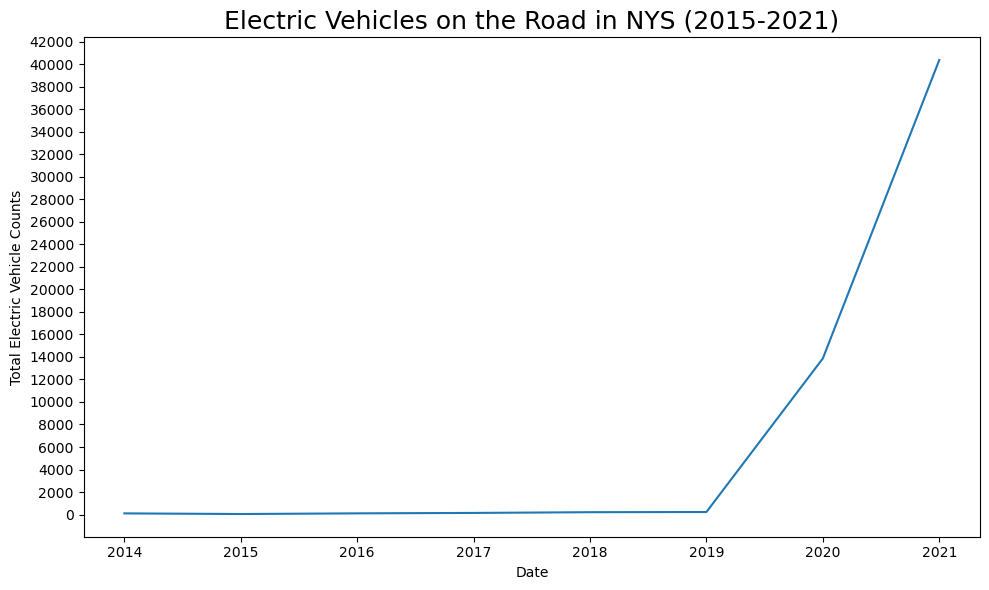

In [39]:
# Create a line chart
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='Year', y='Total Counts', data=reg_year_counts_df, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Electric Vehicles on the Road in NYS (2015-2021)',fontsize=18)
ax.set_yticks(range(0,43000,2000))
plt.tight_layout()
plt.savefig('Images/EV_on_the_road_2015_2021.png', facecolor='white');

### Total Electric Vehicle Count by City (Top 10)

In [40]:
# Count the total numbers of electric vehicle per city
City_counts_df = pd.DataFrame(City_counts)
City_counts_df= City_counts_df.reset_index()
City_counts_df.columns = ['City','Total Counts']

# Select the top 10 city
City_counts_df.sort_values('Total Counts',ascending =True)
City_counts_10_df= City_counts_df.head(10)
City_counts_10_df

City  Total Counts
0       BROOKLYN         10075
1       NEW YORK          3017
2  STATEN ISLAND          1270
3      ROCHESTER          1113
4          BRONX           830
5      SCARSDALE           810
6     GREAT NECK           590
7        SYOSSET           502
8       FLUSHING           494
9      DIX HILLS           465

In [41]:
top_10_cities = ['BROOKLYN', 'NEW YORK', 'STATEN ISLAND', 'ROCHESTER', 'BRONX', 
                  'SCARSDALE', 'GREAT NECK', 'SYOSSET', 'FLUSHING', 'DIX HILLS']

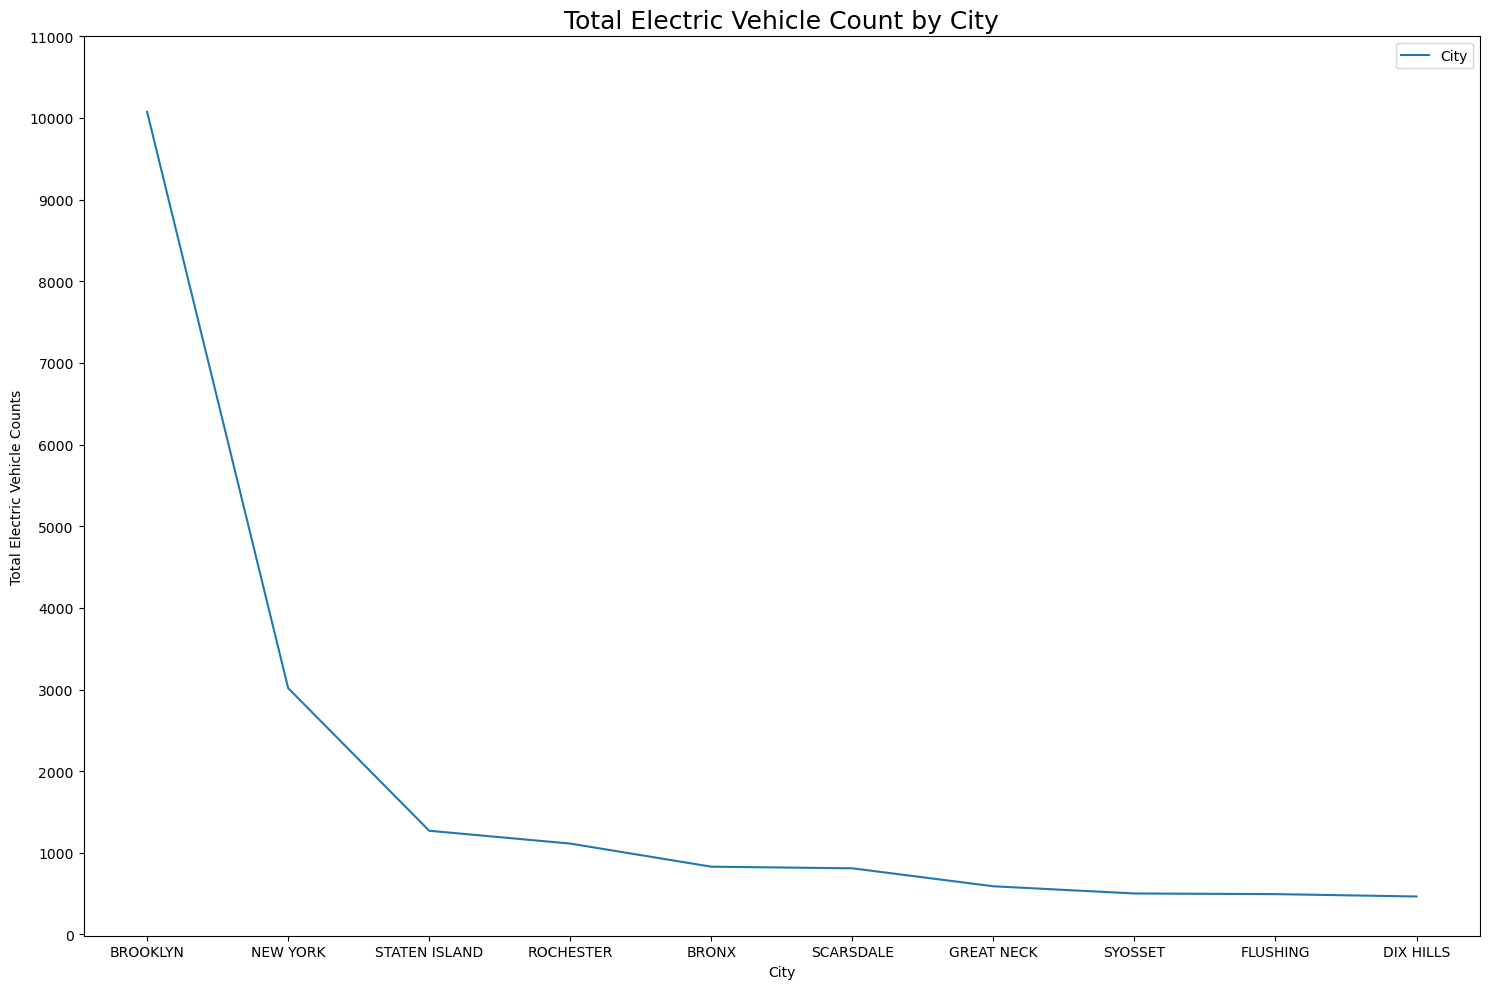

In [42]:
# Create a line chart
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='City', y='Total Counts', data=City_counts_10_df, ax=ax, label='City')
ax.set_xlabel('City')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Total Electric Vehicle Count by City',fontsize=18)
ax.set_yticks(range(0,12000,1000))
plt.tight_layout()
plt.savefig('Images/EV_Count_by_City.png', facecolor='white');

### Total Electric Vehicle Count by County over time (2015-2021)

In [43]:
County_counts_10= County_counts.head(10)
County_counts_10

KINGS          10212
NASSAU          8531
SUFFOLK         7369
WESTCHESTER     7170
QUEENS          3883
NEW YORK        3664
MONROE          2376
ERIE            1873
ROCKLAND        1346
RICHMOND        1270
Name: County, dtype: int64

In [44]:
# top 10 counties
top_10_county = ['KINGS', 'NASSAU','SUFFOLK','WESTCHESTER','QUEENS','NEW YORK','MONROE','ERIE','ROCKLAND','RICHMOND']

In [45]:
# Count the Electric Vehicle by County in each year
#filtering out counties to keep top 10
df_cumsum = df_cumsum.loc[:, ['Reg Valid Date', *top_10_county]]
df_cumsum.head()

Reg Valid Date  KINGS  NASSAU  SUFFOLK  WESTCHESTER  QUEENS  NEW YORK  \
0     2014-04-30    0.0     0.0      0.0          0.0     0.0       0.0   
1     2014-05-31    0.0     0.0      0.0          0.0     0.0       0.0   
2     2014-06-30    0.0     0.0      0.0          0.0     0.0      10.0   
3     2014-07-31    4.0     0.0      0.0          0.0    18.0      21.0   
4     2014-08-31    4.0     0.0      0.0          0.0    25.0      31.0   

   MONROE  ERIE  ROCKLAND  RICHMOND  
0     0.0   0.0       0.0       0.0  
1     0.0   0.0       0.0       0.0  
2     0.0   0.0       0.0       0.0  
3     0.0   0.0       0.0       0.0  
4     0.0   0.0       0.0       0.0

In [46]:
County_counts_10_df = pd.DataFrame(County_counts_10)
County_counts_10_df = County_counts_10_df.reset_index()
County_counts_10_df.columns = ['County','Total Counts']
County_counts_10_df.sort_values('Total Counts',ascending =True)
County_counts_10_df

County  Total Counts
0        KINGS         10212
1       NASSAU          8531
2      SUFFOLK          7369
3  WESTCHESTER          7170
4       QUEENS          3883
5     NEW YORK          3664
6       MONROE          2376
7         ERIE          1873
8     ROCKLAND          1346
9     RICHMOND          1270

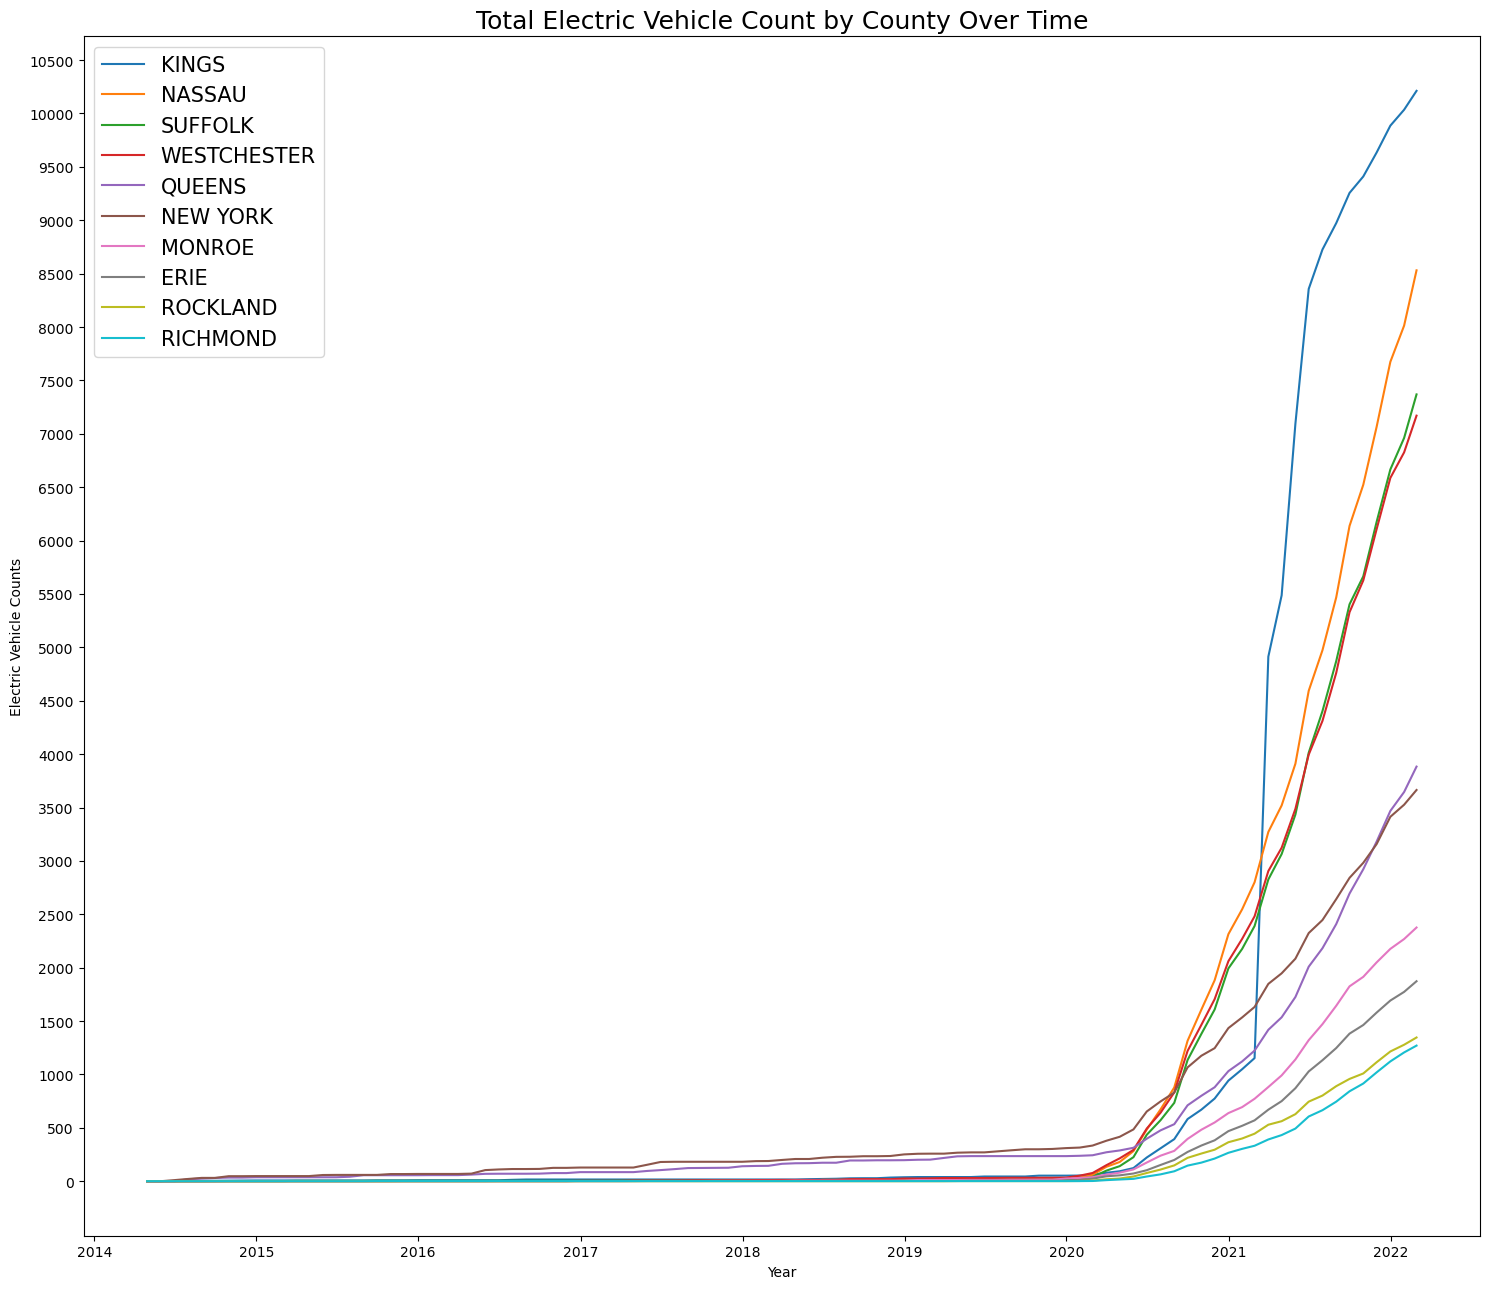

In [47]:
# Create a mutiple-line chart for the top 10 counties
fig, ax = plt.subplots(figsize=(15,13))
for county in top_10_county:
    sns.lineplot(x='Reg Valid Date', y=county, data=df_cumsum, ax=ax, 
                 label=county)

ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Counts')
ax.set_title('Total Electric Vehicle Count by County Over Time',fontsize=18)
ax.set_yticks(range(0,11000,500))
ax.legend(fontsize=15)
plt.tight_layout()
plt.savefig('Images/EV_Count_by_County_Over_Time.png', facecolor='white');

## Most Purchased Car Models by County

In [48]:
# the top 10 counties based on the total counts of electric vehicle
County_counts_10_df

County  Total Counts
0        KINGS         10212
1       NASSAU          8531
2      SUFFOLK          7369
3  WESTCHESTER          7170
4       QUEENS          3883
5     NEW YORK          3664
6       MONROE          2376
7         ERIE          1873
8     ROCKLAND          1346
9     RICHMOND          1270

In [49]:
County_counts_df = pd.DataFrame(County_counts)
County_counts_df = County_counts_df.reset_index()
County_counts_df.columns = ['County','Total Counts']
County_counts_df.sort_values('Total Counts',ascending = False)
County_counts_10_df= County_counts_df.head(10)
County_counts_10_df

County  Total Counts
0        KINGS         10212
1       NASSAU          8531
2      SUFFOLK          7369
3  WESTCHESTER          7170
4       QUEENS          3883
5     NEW YORK          3664
6       MONROE          2376
7         ERIE          1873
8     ROCKLAND          1346
9     RICHMOND          1270

In [50]:
# Top 10 County
top_10_county = ['KINGS', 'NASSAU','SUFFOLK','WESTCHESTER','QUEENS','NEW YORK','MONROE','ERIE','ROCKLAND','RICHMOND']


### Most Purchased Models in King County (Top 6)

In [51]:
County_model_counts_df=NYS_registrations_df[['County','Registration year','Make']]
County_model_counts_df.head()

County Registration year    Make
Reg Valid Date                                    
2014-07-01        FULTON              2014     BMW
2021-12-09         KINGS              2021  TOYOTA
2021-11-16       SUFFOLK              2021  TOYOTA
2021-10-19          ERIE              2021   MANIT
2021-08-11      RICHMOND              2021   HONDA

In [52]:
Kings_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'KINGS')]
Kings_model_counts = Kings_counts_df.Make.value_counts()
Kings_model_counts

NIU              6877
TESLA            2679
CHEVROLET         122
HYUNDAI            99
NISSAN             59
SMART              59
FORD               41
AUDI               38
VOLKSWAGEN         32
BMW                30
KIA                28
HINO               18
INTERNATIONAL      15
PORSCHE            14
ZERO EV            12
YALE               10
POLESTAR            8
VOLVO               8
MINI                7
NEW FLYER           6
GENESIS             5
PIAGGIO             4
TOYOTA              4
FIAT                3
HONDA               3
ICBUS               2
CRUS                2
RIVIAN              2
JAGUAR              2
CUSTO               2
GENZE               2
GEM                 1
DOOSA               1
AMPER               1
SUBARU              1
ALTA                1
GE/SC               1
AZURE               1
ETUK                1
JIAJ                1
LUCID               1
HA/DA               1
BAODI               1
CY/TR               1
FLYWI               1
MITSUBISHI

In [53]:
Kings_model_counts_df = pd.DataFrame(Kings_model_counts)
Kings_model_counts_6_df = Kings_model_counts_df .reset_index().head(6)
Kings_model_counts_6_df.columns = ['Model','Total Counts']
Kings_model_counts_6_df

Model  Total Counts
0        NIU          6877
1      TESLA          2679
2  CHEVROLET           122
3    HYUNDAI            99
4     NISSAN            59
5      SMART            59

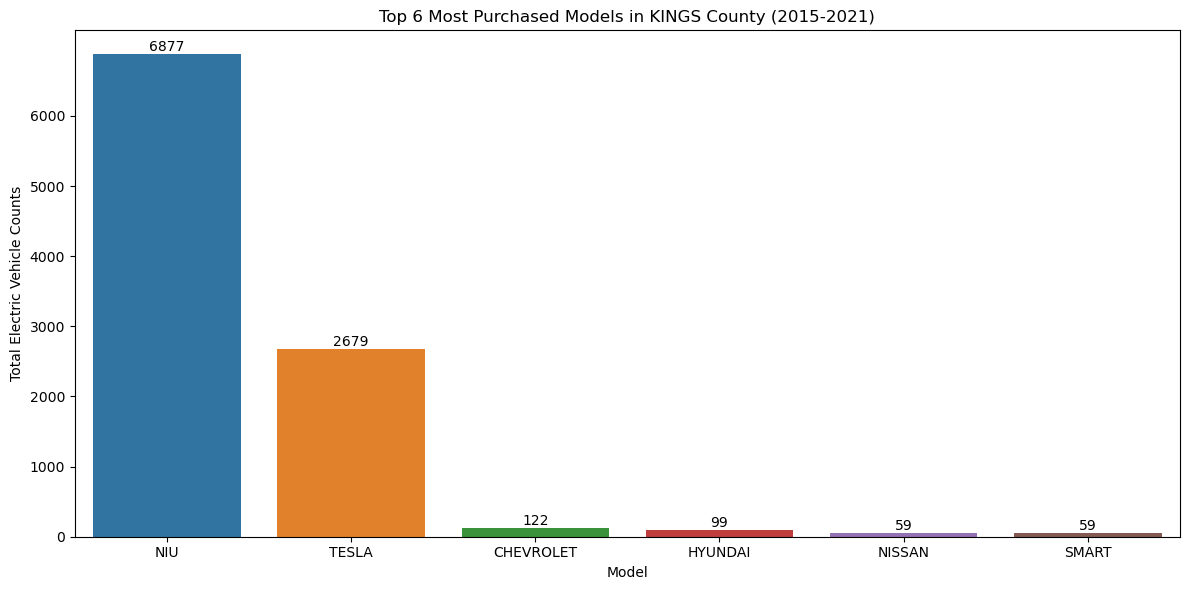

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Kings_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in KINGS County (2015-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_King.png', facecolor='white');

### Most Purchased Models in Nassau County (Top 6)

In [55]:
Nassau_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'NASSAU')]
Nassau_model_counts = Nassau_counts_df.Make.value_counts()
#Nassau_model_counts

In [56]:
Nassau_model_counts_df = pd.DataFrame(Nassau_model_counts)
Nassau_model_counts_6_df = Nassau_model_counts_df .reset_index().head(6)
Nassau_model_counts_6_df.columns = ['Model','Total Counts']
Nassau_model_counts_6_df

Model  Total Counts
0      TESLA          6908
1    HYUNDAI           453
2       FORD           231
3    PORSCHE           176
4  CHEVROLET           168
5       AUDI           129

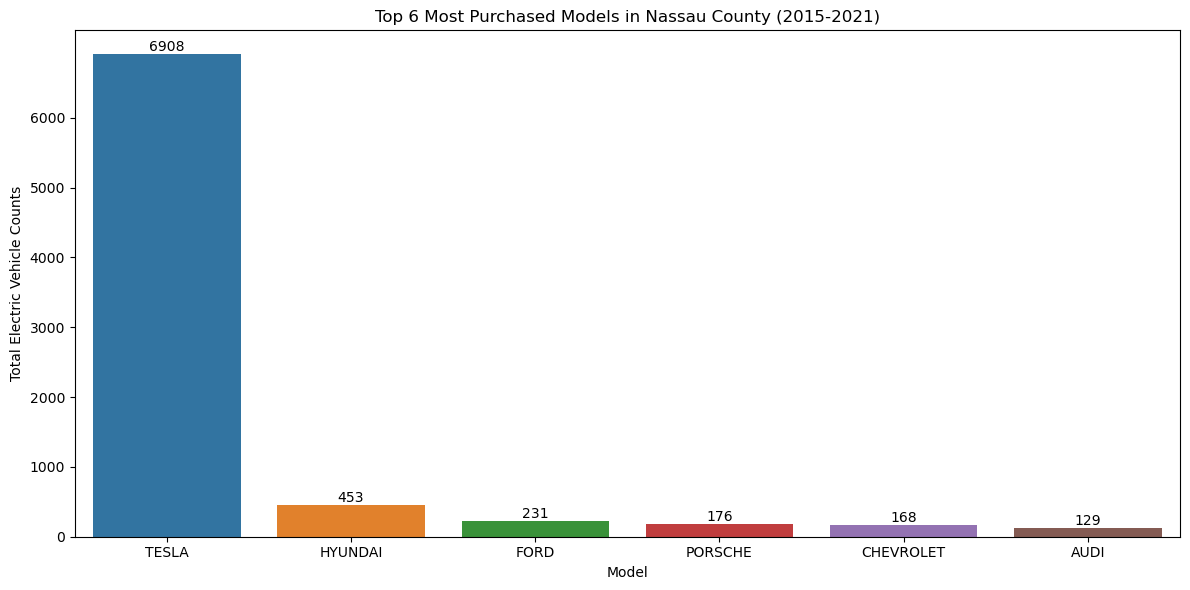

In [57]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Nassau_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Nassau County (2015-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Nassau.png', facecolor='white');

### Most Purchased Models in Suffolk County (Top 6)

In [58]:
Suffolk_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'SUFFOLK')]
Suffolk_model_counts = Suffolk_counts_df.Make.value_counts()
#Suffolk_model_counts

In [59]:
Suffolk_model_counts_df = pd.DataFrame(Suffolk_model_counts)
Suffolk_model_counts_6_df = Suffolk_model_counts_df .reset_index().head(6)
Suffolk_model_counts_6_df.columns = ['Model','Total Counts']
Suffolk_model_counts_6_df

Model  Total Counts
0      TESLA          5572
1    HYUNDAI           466
2  CHEVROLET           239
3       FORD           239
4     NISSAN           175
5    PORSCHE           102

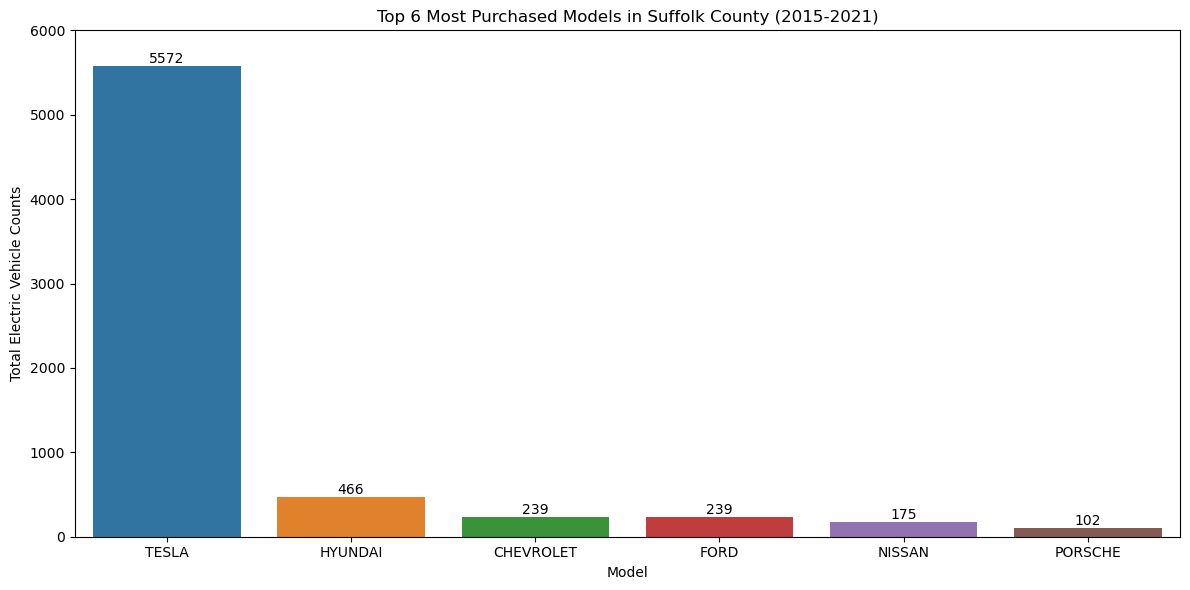

In [60]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Suffolk_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Suffolk County (2015-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Suffolk.png', facecolor='white');

### Most Purchased Models in Westchester County (Top 6)

In [61]:
Westchester_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'WESTCHESTER')]
Westchester_model_counts = Westchester_counts_df.Make.value_counts()
#Westchester_model_counts

In [62]:
Westchester_model_counts_df = pd.DataFrame(Westchester_model_counts)
Westchester_model_counts_6_df = Westchester_model_counts_df .reset_index().head(6)
Westchester_model_counts_6_df.columns = ['Model','Total Counts']
Westchester_model_counts_6_df

Model  Total Counts
0      TESLA          5628
1  CHEVROLET           255
2     NISSAN           201
3    HYUNDAI           179
4       FORD           168
5       AUDI           137

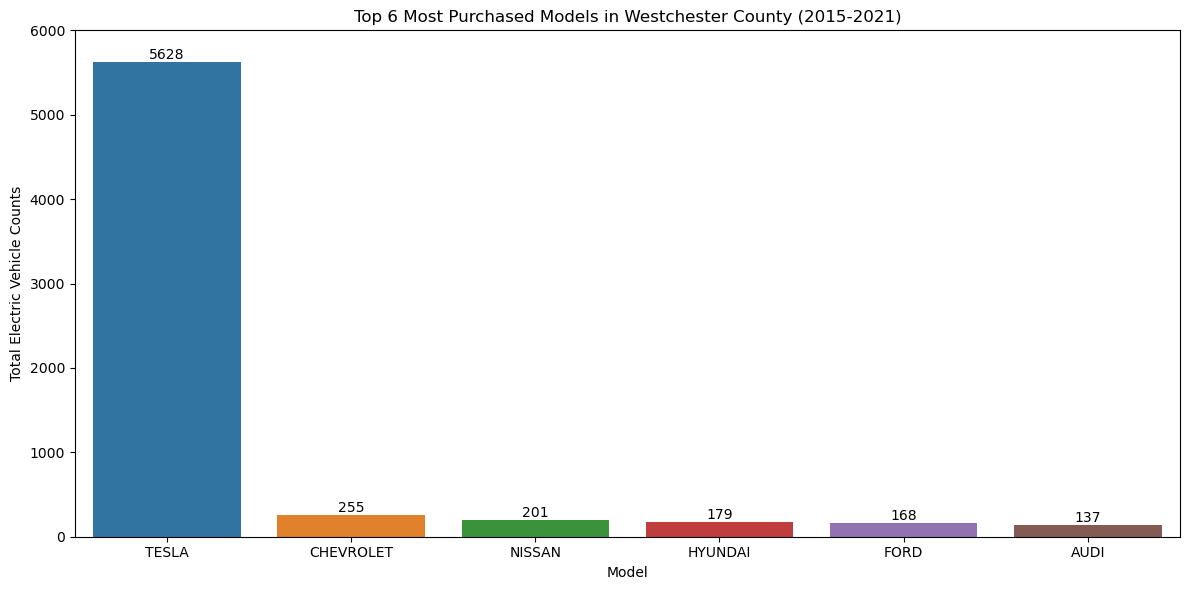

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Westchester_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Westchester County (2015-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Westchester.png', facecolor='white');

### Most Purchased Models in Queens County (Top 6)

In [64]:
Queens_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'QUEENS')]
Queens_model_counts = Queens_counts_df.Make.value_counts()
#Queens_model_counts

In [65]:
Queens_model_counts_df = pd.DataFrame(Queens_model_counts)
Queens_model_counts_6_df = Queens_model_counts_df .reset_index().head(6)
Queens_model_counts_6_df.columns = ['Model','Total Counts']
Queens_model_counts_6_df

Model  Total Counts
0      TESLA          2967
1  CHEVROLET           249
2     NISSAN           148
3    HYUNDAI           130
4       FORD            95
5        KIA            56

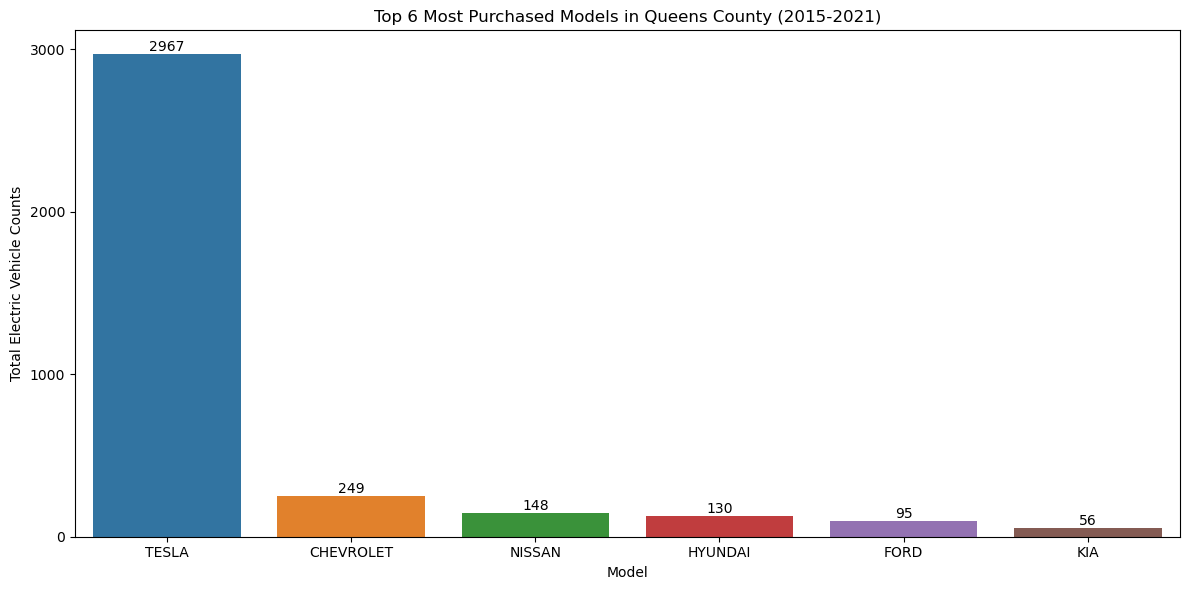

In [66]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Queens_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Queens County (2015-2021)')
ax.set_yticks(range(0,4000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Queens.png', facecolor='white');

### Most Purchased Models in New York County (Top 6)

In [67]:
New_York_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'NEW YORK')]
New_York_model_counts = New_York_counts_df.Make.value_counts()
#New_York_model_counts

In [68]:
New_York_model_counts_df = pd.DataFrame(New_York_model_counts)
New_York_model_counts_6_df = New_York_model_counts_df.reset_index().head(6)
New_York_model_counts_6_df.columns = ['Model','Total Counts']
New_York_model_counts_6_df

Model  Total Counts
0      TESLA          2714
1  CHEVROLET           218
2     NISSAN           182
3      EL/SM            77
4    PORSCHE            70
5       AUDI            55

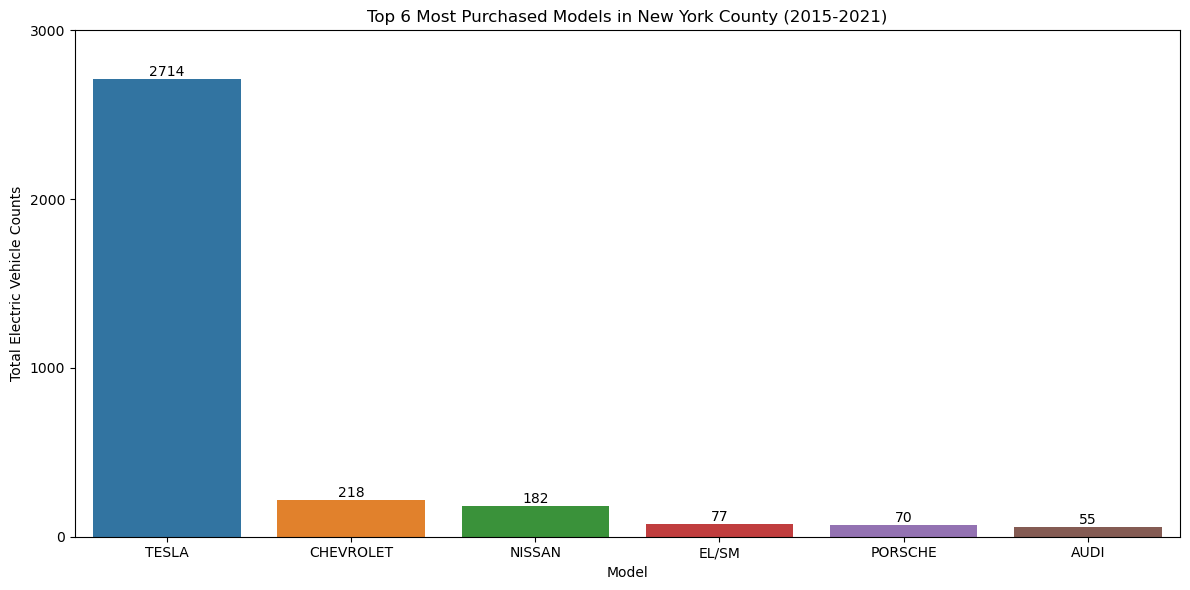

In [69]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=New_York_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in New York County (2015-2021)')
ax.set_yticks(range(0,4000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_New_York.png', facecolor='white');

### Most Purchased Models in Monroe County (Top 6)

In [70]:
Monroe_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'MONROE')]
Monroe_model_counts = Monroe_counts_df.Make.value_counts()
#Monroe_model_counts

In [71]:
Monroe_model_counts_df = pd.DataFrame(Monroe_model_counts)
Monroe_model_counts_6_df = Monroe_model_counts_df.reset_index().head(6)
Monroe_model_counts_6_df.columns = ['Model','Total Counts']
Monroe_model_counts_6_df

Model  Total Counts
0      TESLA          1101
1  CHEVROLET           338
2     NISSAN           265
3    HYUNDAI           247
4       FORD            89
5        KIA            88

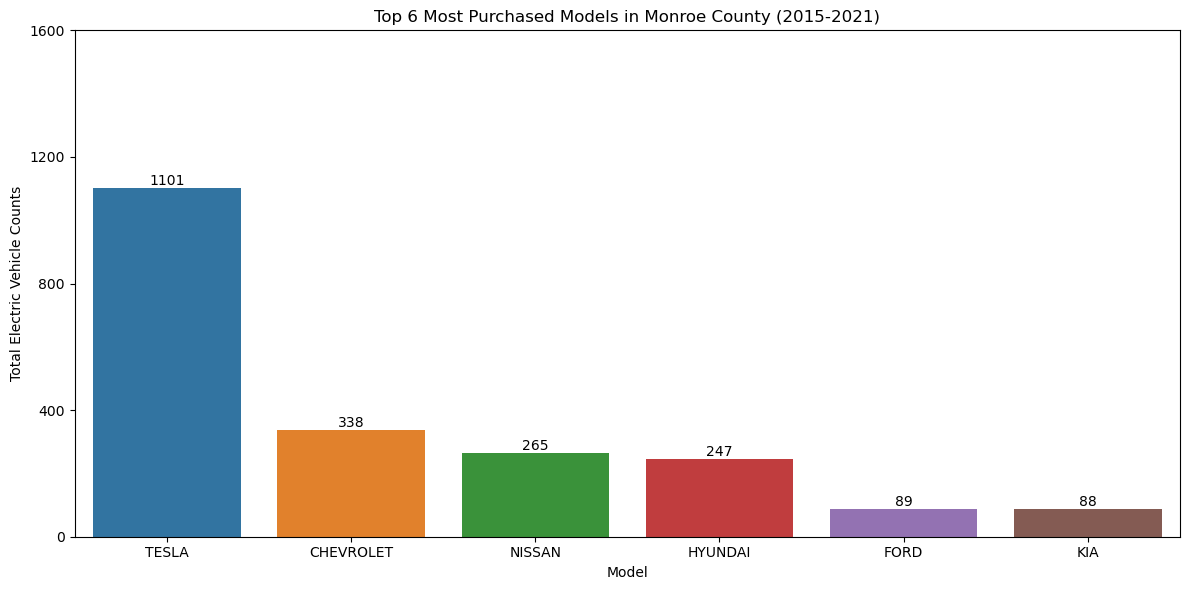

In [72]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Monroe_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Monroe County (2015-2021)')
ax.set_yticks(range(0,2000,400))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Monroe.png', facecolor='white');

### Most Purchased Models in Erie County (Top 6)

In [73]:
Erie_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'ERIE')]
Erie_model_counts = Erie_counts_df.Make.value_counts()
#Erie_model_counts

In [74]:
Erie_model_counts_df = pd.DataFrame(Erie_model_counts)
Erie_model_counts_6_df = Erie_model_counts_df.reset_index().head(6)
Erie_model_counts_6_df.columns = ['Model','Total Counts']
Erie_model_counts_6_df

Model  Total Counts
0       TESLA           902
1     HYUNDAI           321
2   CHEVROLET           194
3        FORD           124
4      NISSAN           119
5  VOLKSWAGEN            38

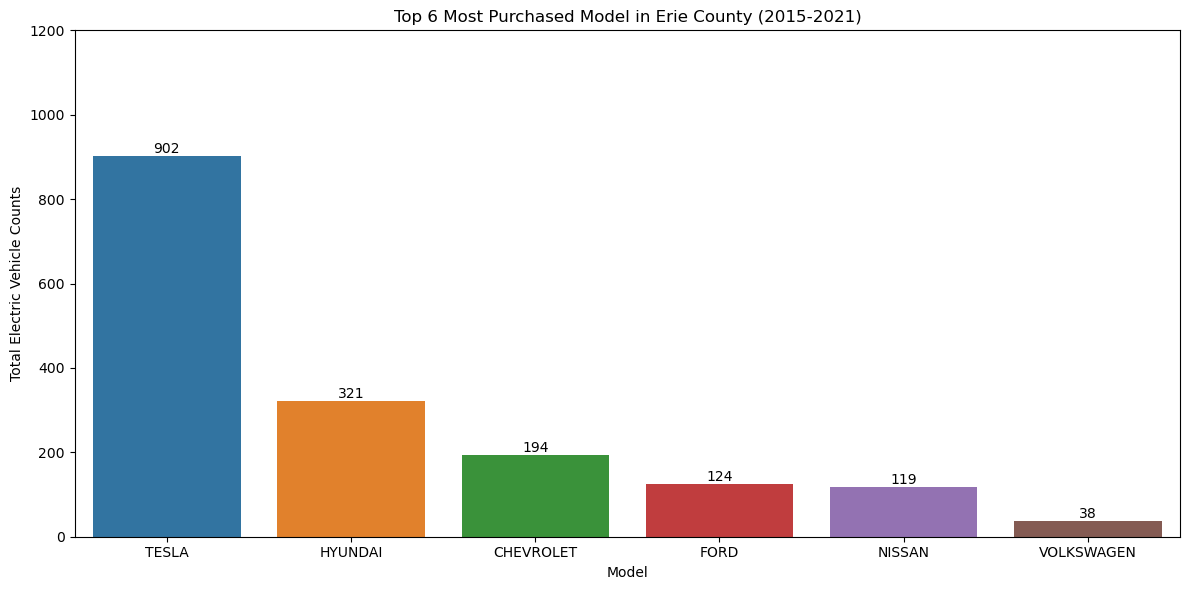

In [75]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Erie_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Model in Erie County (2015-2021)')
ax.set_yticks(range(0,1400,200))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Erie.png', facecolor='white');

### Most Purchased Models in Rockland County (Top 6)

In [76]:
Rockland_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'ROCKLAND')]
Rockland_model_counts = Rockland_counts_df.Make.value_counts()
#Rockland_model_counts

In [77]:
Rockland_model_counts_df = pd.DataFrame(Rockland_model_counts)
Rockland_model_counts_6_df = Rockland_model_counts_df.reset_index().head(6)
Rockland_model_counts_6_df.columns = ['Model','Total Counts']
Rockland_model_counts_6_df

Model  Total Counts
0      TESLA           992
1    HYUNDAI           113
2       FORD            52
3  CHEVROLET            43
4     NISSAN            42
5        KIA            21

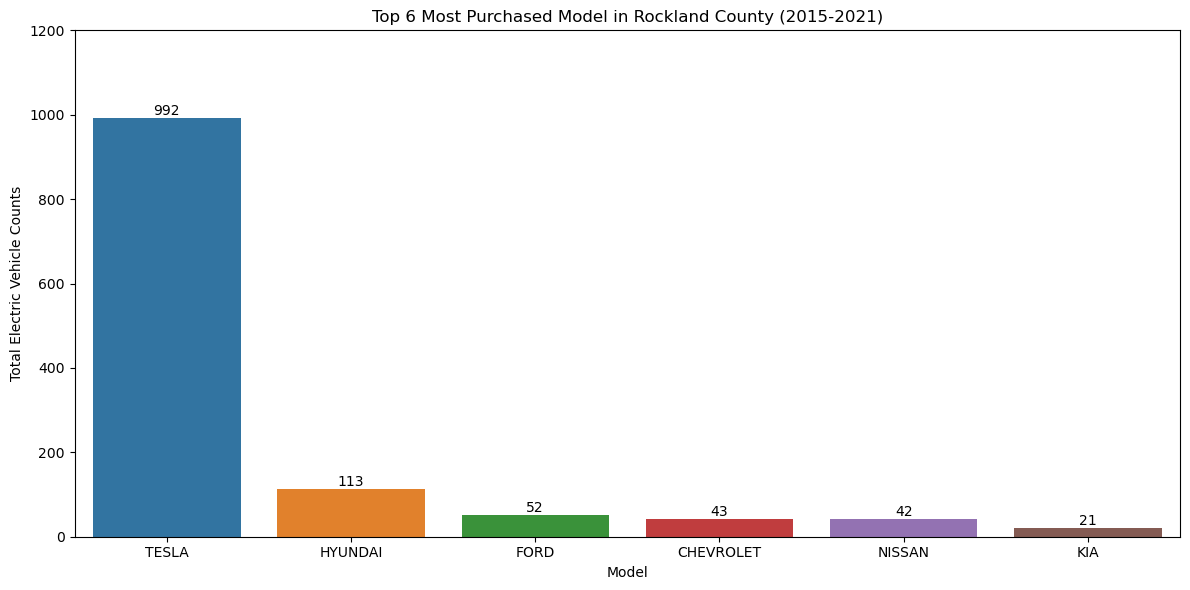

In [78]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Rockland_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Model in Rockland County (2015-2021)')
ax.set_yticks(range(0,1400,200))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Rockland.png', facecolor='white');

### Most Purchased Models in Richmond County (Top 6)

In [79]:
Richmond_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'RICHMOND')]
Richmond_model_counts = Richmond_counts_df.Make.value_counts()
#Richmond_model_counts

In [80]:
Richmond_model_counts_df = pd.DataFrame(Richmond_model_counts)
Richmond_model_counts_6_df = Richmond_model_counts_df.reset_index().head(6)
Richmond_model_counts_6_df.columns = ['Model','Total Counts']
Richmond_model_counts_6_df

Model  Total Counts
0      TESLA           961
1    HYUNDAI            94
2       FORD            51
3     NISSAN            26
4  CHEVROLET            25
5    PORSCHE            17

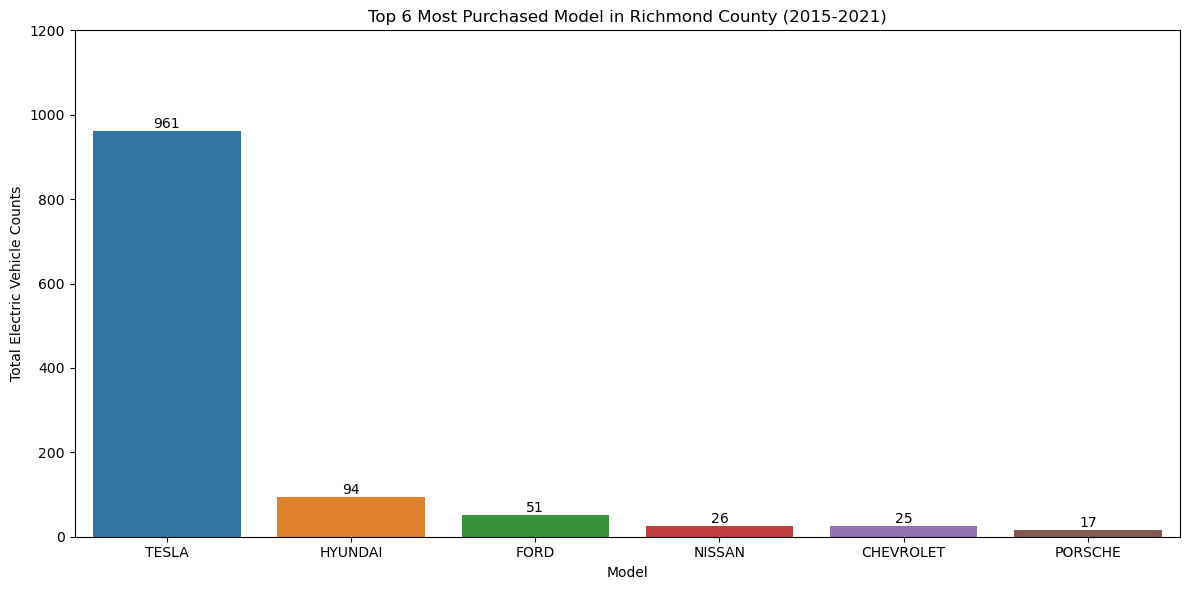

In [81]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Richmond_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Model in Richmond County (2015-2021)')
ax.set_yticks(range(0,1400,200))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Richmond.png', facecolor='white');

# MODEL

## Preprocessing/ Defining Functions

In [82]:
df_cumsum = df_cumsum.set_index('Reg Valid Date').resample('M').asfreq()

In [83]:
df_cumsum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2014-04-30 to 2022-02-28
Freq: M
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   KINGS        95 non-null     float64
 1   NASSAU       95 non-null     float64
 2   SUFFOLK      95 non-null     float64
 3   WESTCHESTER  95 non-null     float64
 4   QUEENS       95 non-null     float64
 5   NEW YORK     95 non-null     float64
 6   MONROE       95 non-null     float64
 7   ERIE         95 non-null     float64
 8   ROCKLAND     95 non-null     float64
 9   RICHMOND     95 non-null     float64
dtypes: float64(10)
memory usage: 8.2 KB


### Separating Data for Each County


In the first part of project, we aim to predict the demand for electric vehicles in each county in New York state and based on that find the top 3 counties to invest for setting EV chargers. In this part, we used a time series modeling of the amount of electric vehicles in the top 6 counties within New York state with the most purchases of new electric vehicles. To this end, We will be creating time series models for the top 6 counties. So we need to have smaller dataframe for each of the top 6 counties.

#### Creating Function to seperate data for each county

This function separates the given dataframe by county and returns the separated dataframe.

In [84]:
def separate_data_by_county(county, df):
 
    
    df_county = pd.DataFrame(df.loc[:, county])
    df_county.columns=["EV's on the Road"]
    df_county.head()
    return df_county

In [85]:
#separating data by county and parsing this information to a dictionary
county_information = {}
for county in top_10_county:
    county_information[county] = {}
    county_information[county]['df']=separate_data_by_county(county, df_cumsum)

In [86]:
#separating data by county and parsing this information to a dictionary
county_dfs = {}
for county in top_10_county:
    county_dfs[county] = separate_data_by_county(county, df_cumsum)

#### Creating Function to Evaluate the models
Before modelling, one of the functions we will need is a function that will show us the various statistics so that we can evaluate the performance of the model. Function returns the model summary and diagnostics information to aid the evaluation of the given model's performance. We use SARIMAX or ARIMA model object.

In [87]:
def evaluate_model(model):
    
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout();

#### Creating a Function for train_test_split & plotting
We will be splitting the time series into two: a training set and a testing set. This will allow us to validate the performance of the models. It should be noted that , based on the "Electrical Vehicle on the Road" vs "Time" graphs, we will change the train and test sizes

In [88]:
def train_test_split_ts (df, train_size, test_size):
    
    train_end_idx = int(round(len(df)*train_size,0))
    train_set = df.iloc[0:train_end_idx,:]["EV's on the Road"]
    test_set = df.iloc[train_end_idx:,:]["EV's on the Road"]
    return train_set, test_set

#### Creating Function to visualize the Training and Testing Data for Visual Inspection
This function was created to plot the trainig and testing data

In [89]:
def plot_train_test_split(train_data, test_data, county):
     
    train_data.plot(label='Train Data')
    test_data.plot(label='Test Data')
    ax=plt.gca()
    ax.set_xlabel('Year')
    ax.set_ylabel('Electric Vehicles on the Road')
    ax.set_title(f'Electric Vehicles on the Road in {county} County')
    ax.legend();

#### Creating a Function for Getting Forecasts
To validate the model,  we will be getting the forecast from our model for the test period and will be plotting it against the actual test data. This function will gets forecasted values from a given model and plots within the same time frame for the visual inspection.  The length of the test data will dictate the length of the forecasts. We will save the forecasted values in a DataFrame format.

In [90]:
def get_forecast(model, train_data, test_data, plot=True):
    
    
    #creating a df with the forecast information
    forecast_df = model.get_forecast(steps=len(test_data)).conf_int()
    forecast_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    forecast_df['Forecasts'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=train_data, color='black', ax=ax)
            sns.lineplot(data=forecast_df, x=forecast_df.index, 
                         y='Forecasts', color='blue', ax=ax, 
                         label='Forecasted Data', ls='--')
            sns.lineplot(data=test_data, color='purple', ax=ax, 
                         label='Actual Data', ls='-.')
            ax.fill_between(forecast_df.index, 
                            y1=forecast_df['Lower Confidence Interval'], 
                            y2=forecast_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.legend(loc=2)
            plt.show();
    return forecast_df

#### Defining a Function for Getting Predictions for Future
The last function to predict and visualize. This function will get predicted values from a given model and visualize themThe length of the predictions are dependent on the length of the test data. The forecasted values will be saved in  DataFrame format.

In [91]:
def get_prediction(model, df, test_data, county_name, plot=True):
    

    
    #creating a df with the prediction information
    prediction_df = model.get_forecast(steps=len(test_data)).conf_int()
    prediction_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    prediction_df['Predictions'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=df, ax=ax)
            sns.lineplot(data=prediction_df, x=prediction_df.index, 
                         y='Predictions', color='orange', ax=ax, 
                         label='Predicted Data', ls='--')
            ax.fill_between(prediction_df.index, 
                            y1=prediction_df['Lower Confidence Interval'], 
                            y2=prediction_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.set_ylabel('Electric Vehicles on the Road')
            ax.set_title(f'Predicted Electric Vehicle Count for {county_name}')
            plt.show();
    return prediction_df

# KINGS
### Seasonality Check
For a better understanding of the trend and seasonality components of the data, it is important to decompose it prior to modeling.

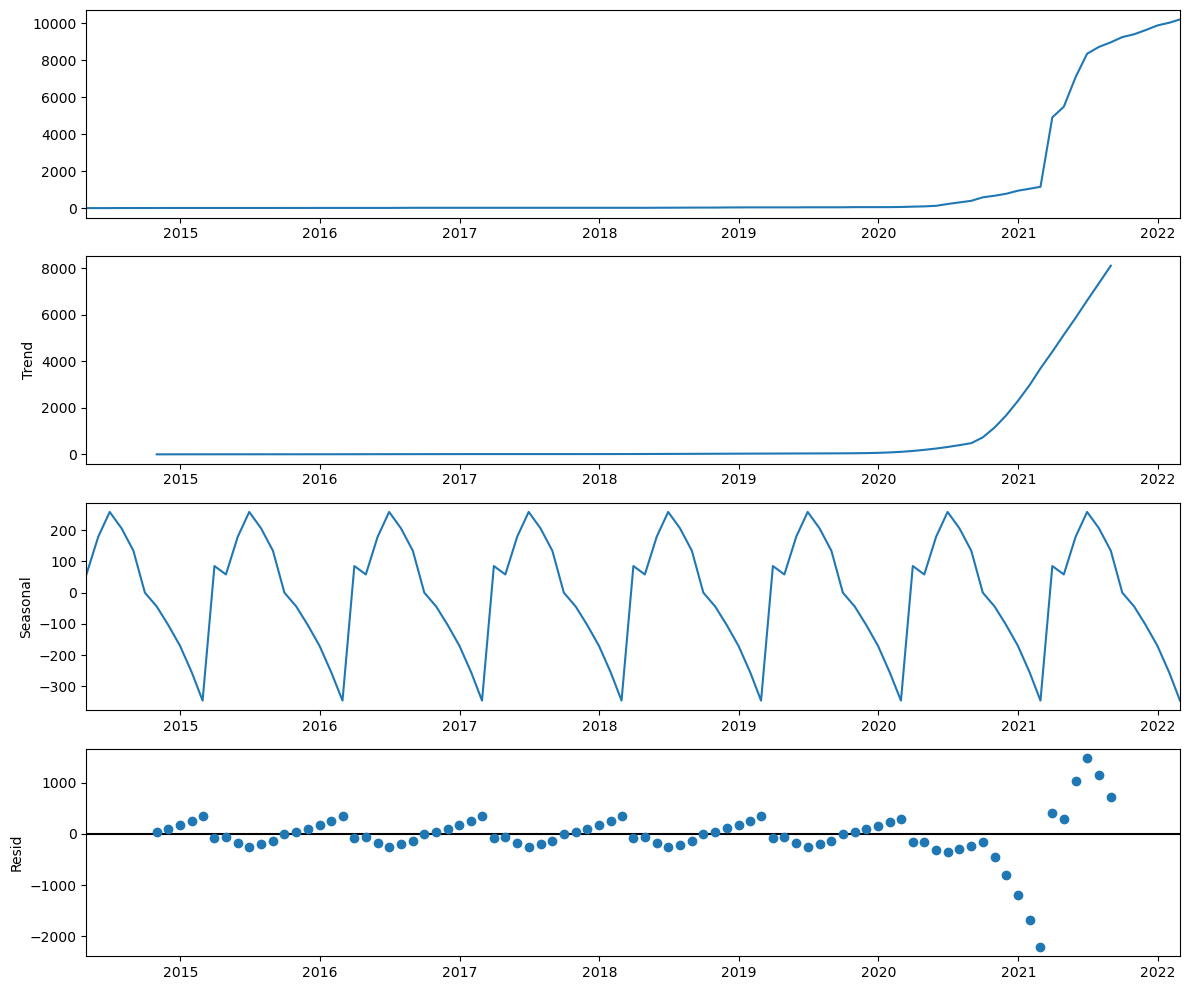

In [92]:
import statsmodels.tsa.api as tsa

plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['KINGS']['df'])
decomp.plot();

The results showed that the electric vehicle has an ascending trend and the data showed seasonality pattern. 

### train_test_split
After multiple iterations, we found that the best performance was achieved when we split the data belonging to the kings in the 0.85-0.15 split.

In [93]:
#splitting dataset into train and test sets for validation
train_KINGS, test_KINGS = train_test_split_ts(county_information['KINGS']['df'], 
                                            0.85, 0.15)

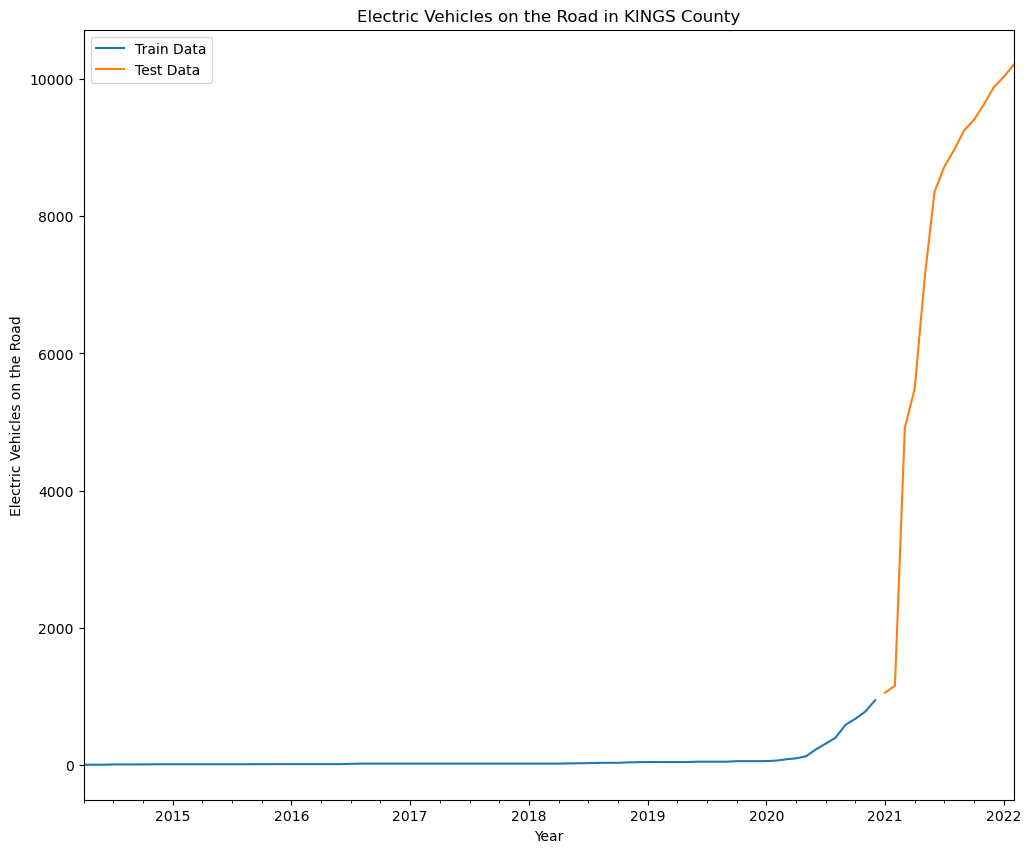

In [94]:
#plotting the split
plot_train_test_split(train_KINGS, test_KINGS, 'KINGS')

### Finding Best Parameters with Auto-Arima


The pmdarima library will be used to automate the optimization of the p,d,q values for each county and the validation of the models.

In [95]:
import pmdarima as pm

In [96]:
auto_model = pm.auto_arima(train_KINGS, start_p=0, d=1, start_q=0, max_p=4, 
                           max_d=3, max_q=4, start_P=0, start_Q=0, max_P=3, 
                           max_D=3, max_Q=3, m=12)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   81
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -329.977
Date:                Fri, 18 Nov 2022   AIC                            667.954
Time:                        14:59:35   BIC                            677.482
Sample:                    04-30-2014   HQIC                           671.774
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9497      0.020     47.855      0.000       0.911       0.989
ma.L1         -0.8744      0.035    -25.011      0.000      -0.943      -0.806
ma.L2          0.9613      0.052     18.346      0.000       0.859       1.064
sigma2       203.4687     23.041      8.831      0.000     158.309     248.628
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               189.48
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):             348.44   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (1,1,2) without the seasonal component. After plugging these into a SARIMAX model, we will have our final model, which we will then validate based on forecasts and the test data.

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   81
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -317.357
Date:                Fri, 18 Nov 2022   AIC                            642.713
Time:                        14:59:35   BIC                            652.089
Sample:                    04-30-2014   HQIC                           646.463
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9757      0.020     49.764      0.000       0.937       1.014
ma.L1         -0.9137      0.026    -34.607      0.000      -0.965      -0.862
ma.L2          1.0422      0.056     18.700      0.000       0.933       1.151
sigma2       193.9588     15.799     12.277      0.000     162.994     224.924
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               150.20
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             298.04   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

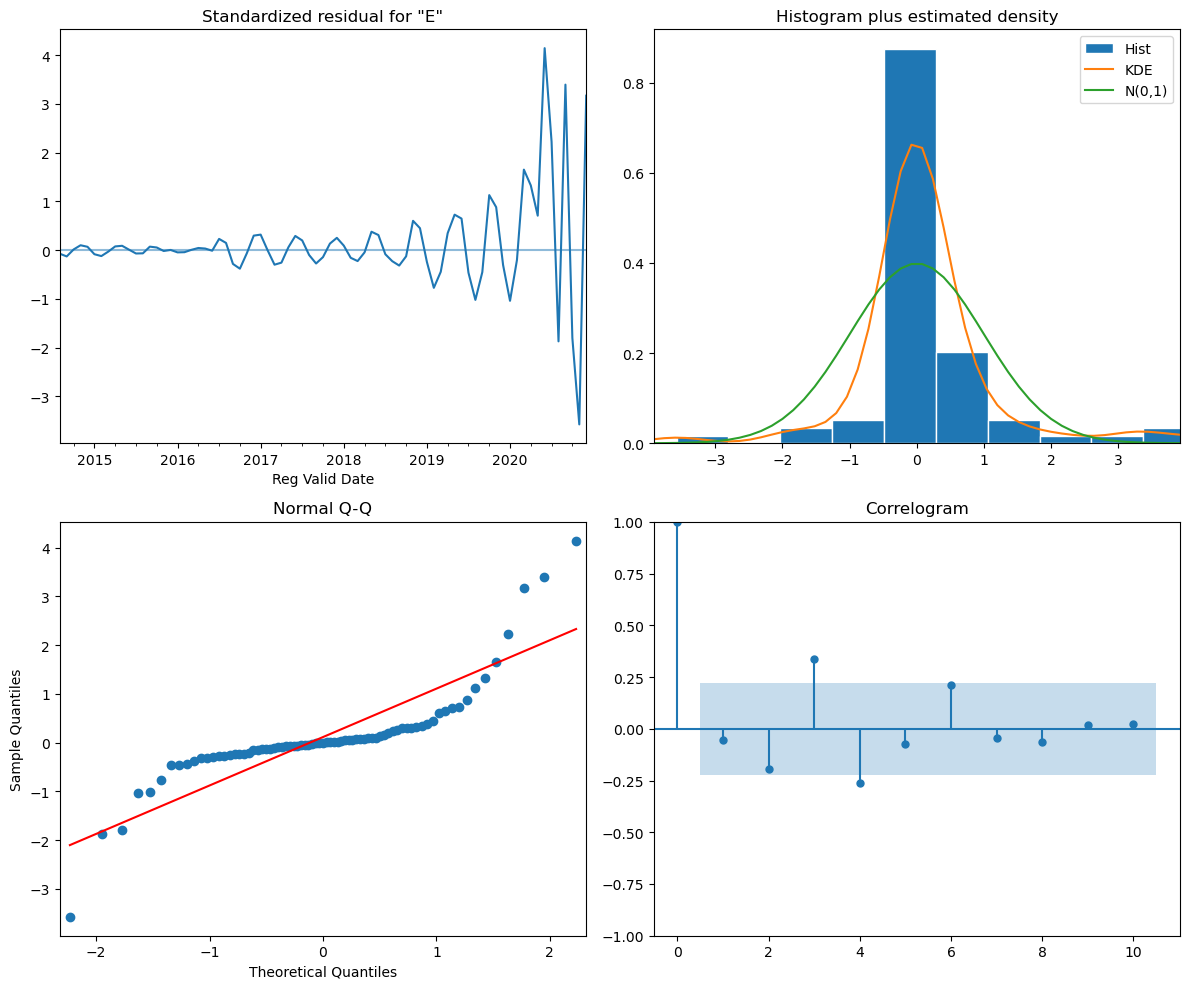

In [98]:
model = SARIMAX(train_KINGS, order=(1,1,2),
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

The results showed that the electric vehicle has an ascending trend and the data showed seasonality pattern. 

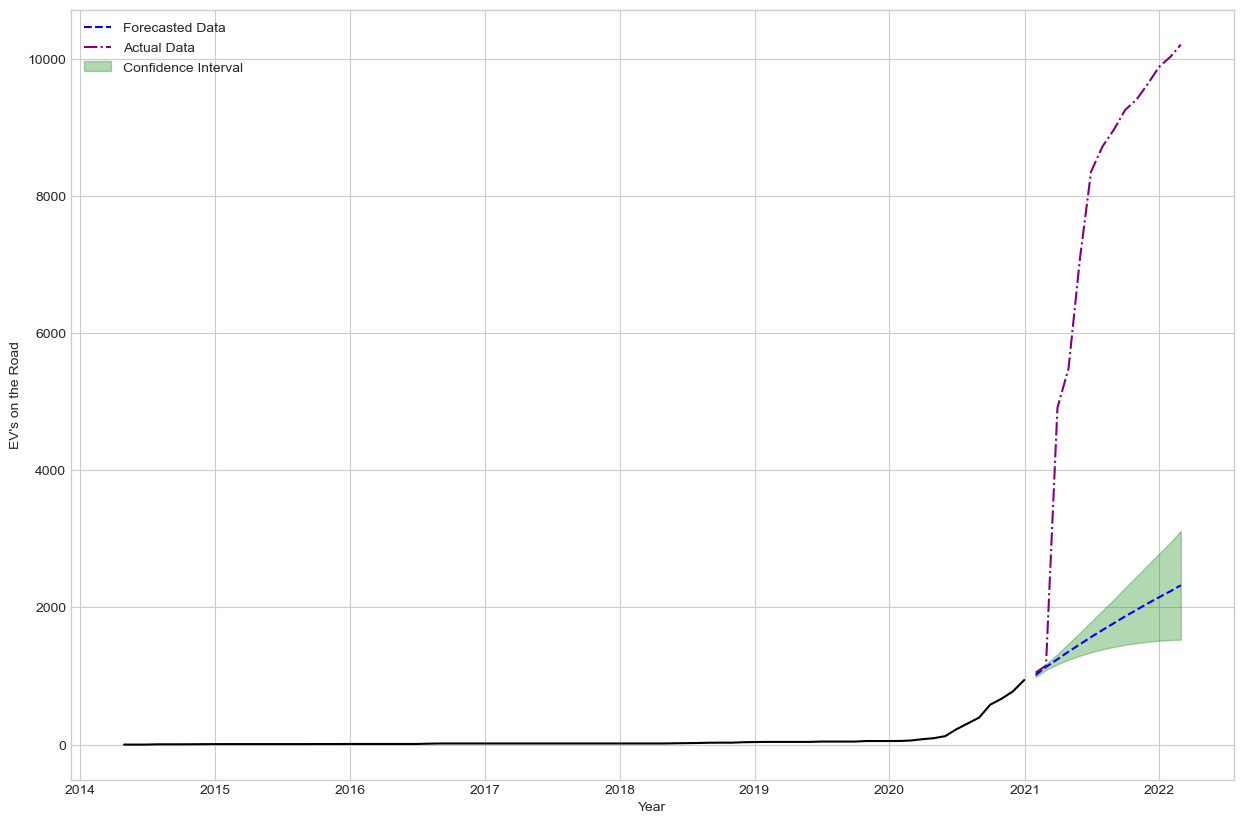

In [99]:
df_king_forecast = get_forecast(model, train_KINGS, test_KINGS, plot=True)

Above, we can see that the model is not able to accurately forecast data into the future. The actual observed data is not within the confidence interval of our model's forecasts. This is mainly due to the fact that major part of the trained data deal in the linear part of time-series. while, as of 2020, the trend of EV vehicle followed an exponential pattern. We need to reduce the time period to achive more acurate information for the KINGS county.

### Future Predictions
#### Fitting Model to All Observed Data
Now that we know that our model can approximately make predictions about the future electric vehicle counts in each county, we can use the same parameters to build a model on the whole observed dataset without splitting it into train/test sets.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   95
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -672.174
Date:                Fri, 18 Nov 2022   AIC                           1352.348
Time:                        14:59:36   BIC                           1362.391
Sample:                    04-30-2014   HQIC                          1356.400
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6082      0.447      1.360      0.174      -0.268       1.485
ma.L1         -0.4741      0.499     -0.950      0.342      -1.452       0.504
ma.L2          0.4131      0.395      1.047      0.295      -0.360       1.186
sigma2      1.523e+05   4216.555     36.123      0.000    1.44e+05    1.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             27129.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):          345114.56   Skew:                             9.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        85.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

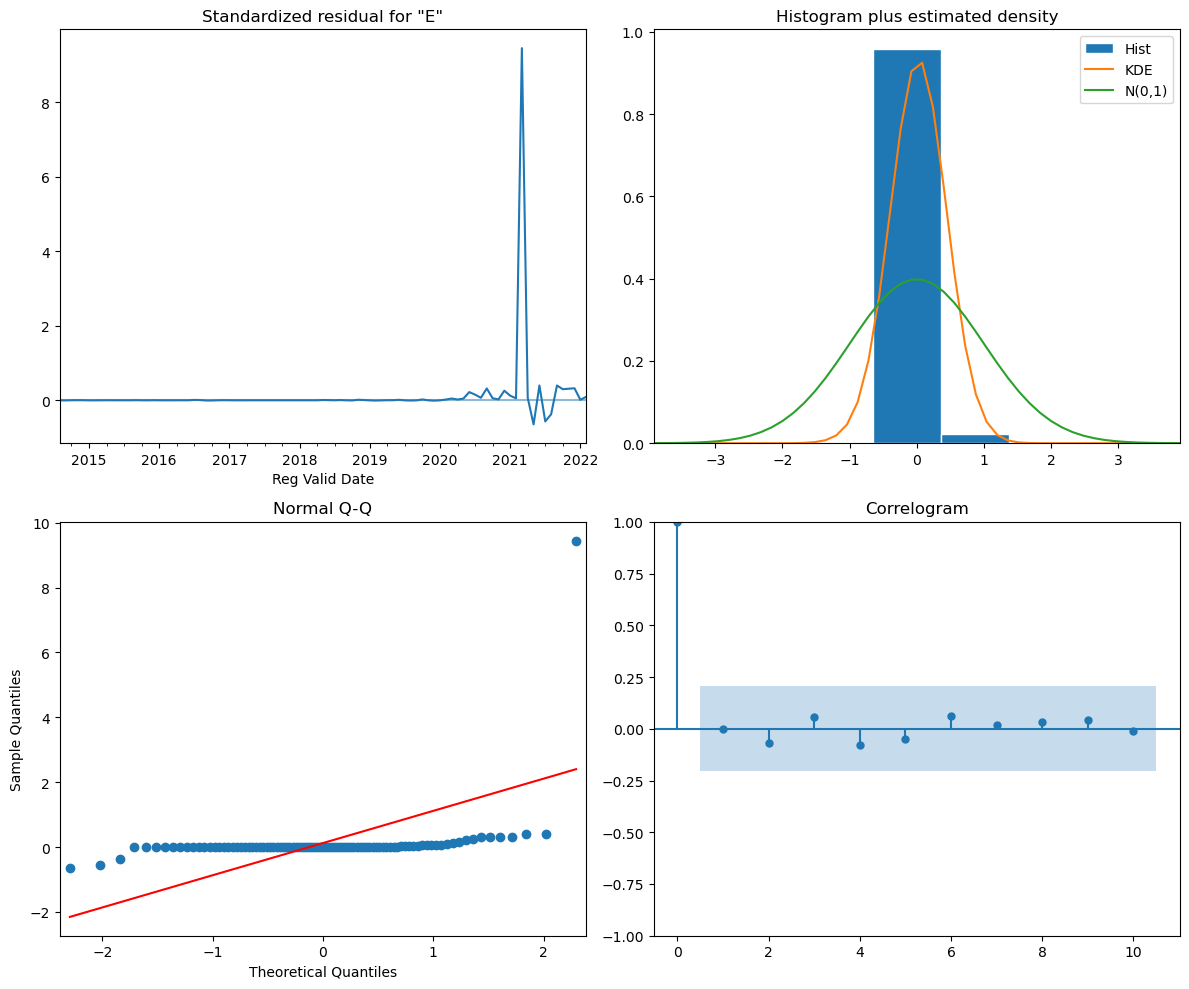

In [100]:
model = SARIMAX(county_information['KINGS']['df'], order=(1, 1, 2), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

Above we can see that the residuals for this model are less normally distributed compared to the test model. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant.

#### Plotting & Saving Predictions
Using our model, we can predict the future counts of electric vehicles in KINGS County and plot them. 

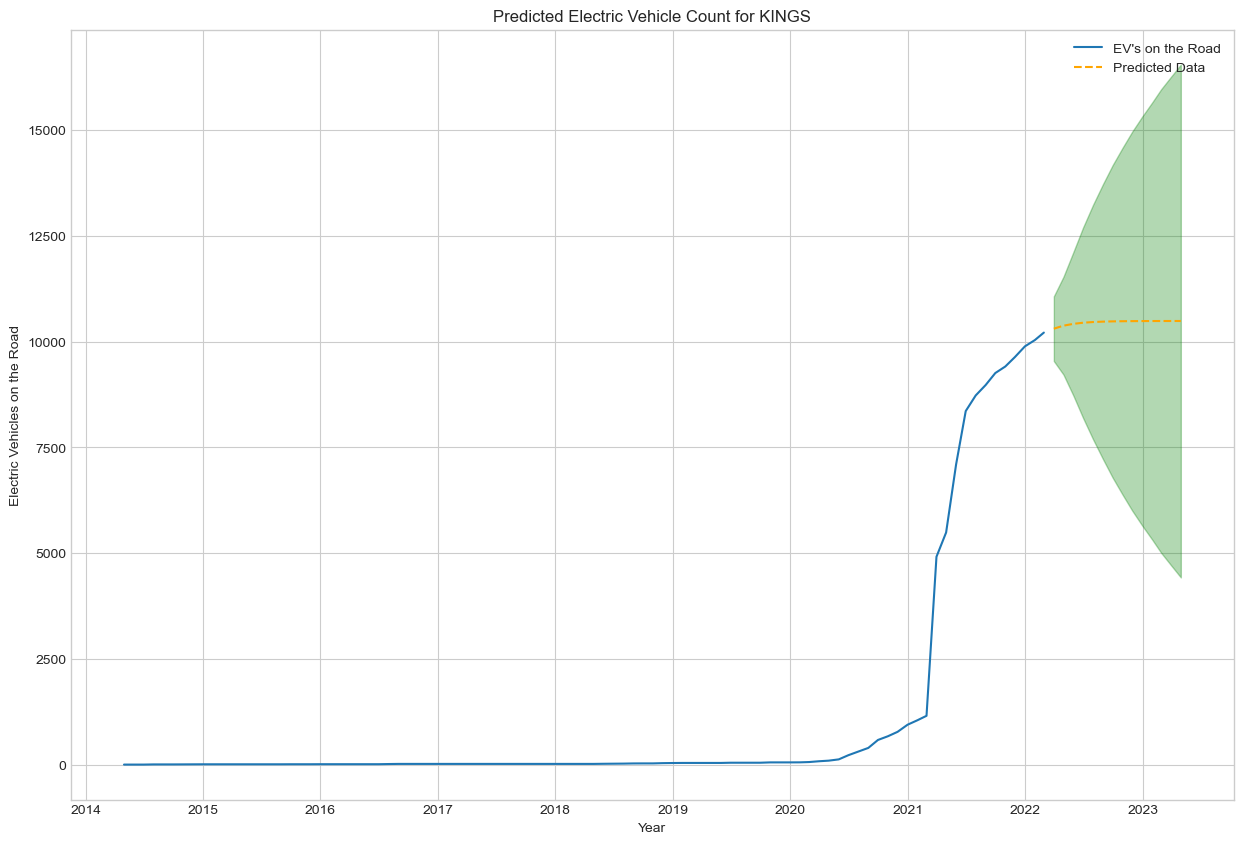

In [101]:
#creating a df of predictions and plotting
df_KINGS_preds = get_prediction(model, county_information['KINGS']['df'], 
                               test_KINGS, 'KINGS', plot=True)

The model is predicting that the amount of electric vehicles in KINGS County are going to keep increasing almost linearly at a slower rate ,based on the mean values, However, If we look at the upper confidence interval , we can see that the increase could follow an exponential pattern.

In [102]:
#saving predictions df to dict for later use
county_information['KINGS']['Predictions'] = df_KINGS_preds


In [103]:
df_KINGS_preds.tail()

Lower Confidence Interval  Upper Confidence Interval   Predictions
2022-12-31                5648.739437               15319.966915  10484.353176
2023-01-31                5317.507639               15652.825380  10485.166510
2023-02-28                5004.605458               15966.716978  10485.661218
2023-03-31                4707.654767               16264.269479  10485.962123
2023-04-30                4424.665201               16547.625095  10486.145148

# NASSAU
### Seasonality Check

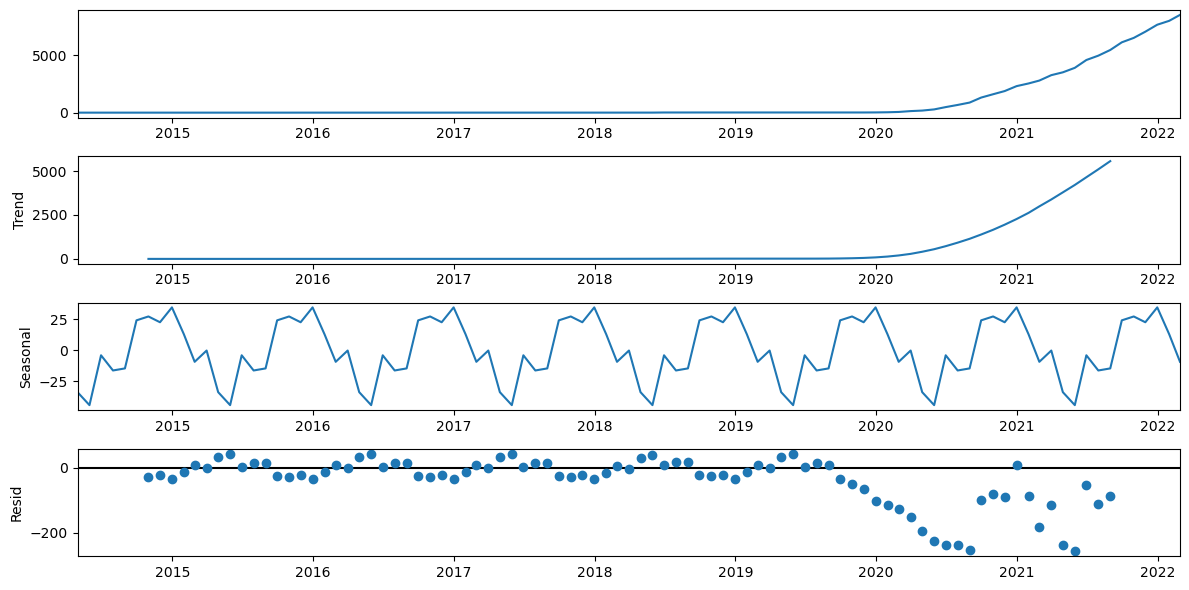

In [104]:
plt.rcParams['figure.figsize']=(12,6)
decomp = tsa.seasonal_decompose(county_information['NASSAU']['df'])
decomp.plot();

The results showed that the electric vehicle has an ascending trend and the data showed seasonality pattern. 

### train_test_split
After multiple iterations, we found that the 0.85-0.15 split of the data belonging to NASSAU County resulted in the best performance.

In [105]:
#splitting dataset into train and test sets for validation
train_NASSAU, test_NASSAU = train_test_split_ts(county_information['NASSAU']['df'], 
                                            0.85, 0.15)

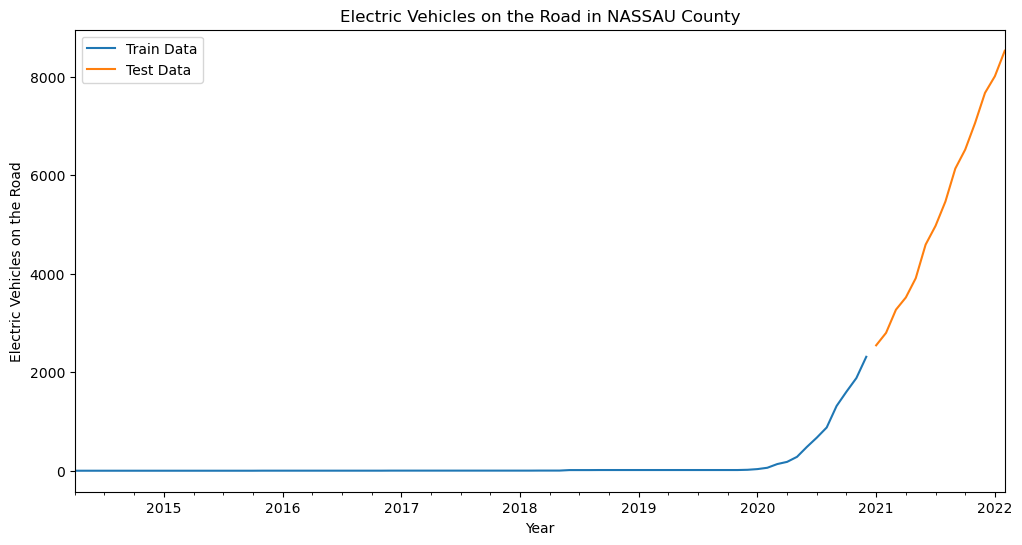

In [106]:
#plotting train and test sets
plot_train_test_split(train_NASSAU, test_NASSAU, 'NASSAU')

### Finding Best Parameters with Auto-Arima

In [107]:
auto_model = pm.auto_arima(train_NASSAU, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   81
Model:             SARIMAX(1, 1, 4)x(0, 1, [], 12)   Log Likelihood                -326.811
Date:                             Fri, 18 Nov 2022   AIC                            665.622
Time:                                     14:59:45   BIC                            678.939
Sample:                                 04-30-2014   HQIC                           670.899
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9953      0.026     37.591      0.000       0.943       1.047
ma.L1         -0.4662      0.123     -3.798      0.000      -0.707      -0.226
ma.L2          0.1877      0.163      1.151      0.250      -0.132       0.508
ma.L3          0.7441      0.187      3.977      0.000       0.377       1.111
ma.L4         -0.3508      0.241     -1.456      0.145      -0.823       0.122
sigma2       785.7027    118.728      6.618      0.000     553.001    1018.405
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              1148.70
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):            8976.68   Skew:                             3.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (1,1,4) and (0, 1, [], 12) for the ARIMA and seasonal orders, respectively. 

### Validate Model with Forecasts for Test Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                   81
Model:             SARIMAX(1, 1, 4)x(0, 1, [], 12)   Log Likelihood                -301.405
Date:                             Fri, 18 Nov 2022   AIC                            614.809
Time:                                     14:59:46   BIC                            627.668
Sample:                                 04-30-2014   HQIC                           619.867
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1001      0.137      8.054      0.000       0.832       1.368
ma.L1         -0.5157     61.103     -0.008      0.993    -120.274     119.243
ma.L2          0.2590    184.713      0.001      0.999    -361.771     362.290
ma.L3          0.5438     63.907      0.009      0.993    -124.712     125.800
ma.L4         -0.6638    127.417     -0.005      0.996    -250.397     249.070
sigma2       777.7092   1.49e+05      0.005      0.996   -2.92e+05    2.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):               427.79
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):            6110.66   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

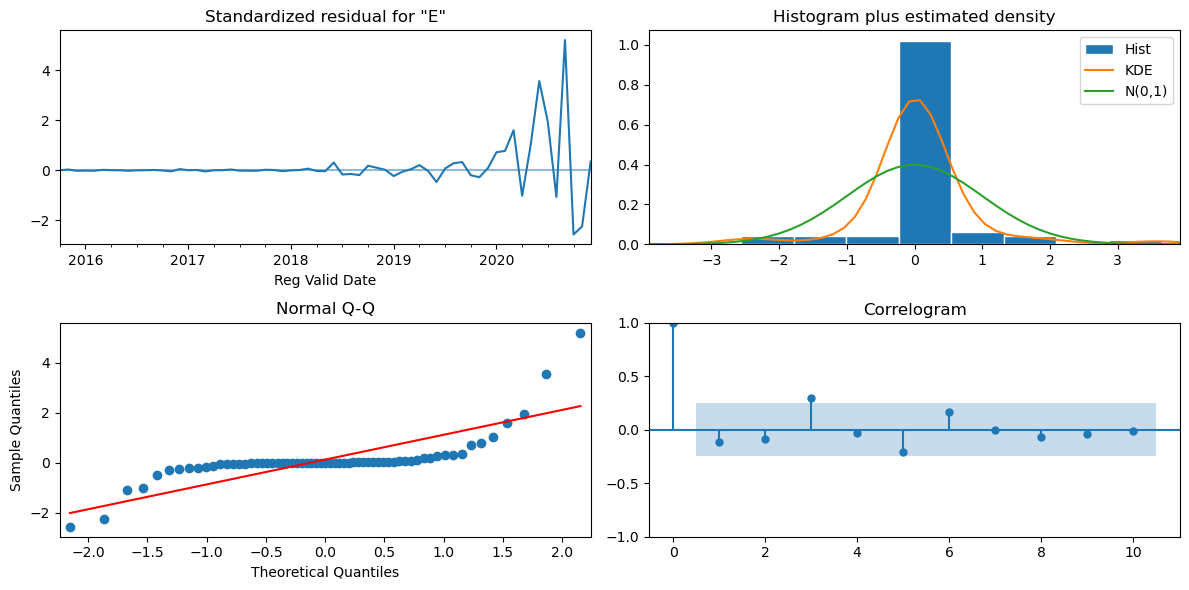

In [108]:
#fitting SARIMAX model with best params
model = SARIMAX(train_NASSAU, order=(1, 1, 4), seasonal_order=(0, 1, [], 12),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

Above, we can see that the residuals are almost fairly close to being normally distributed. We can accept this as the best model and move onto making and plotting predictions.

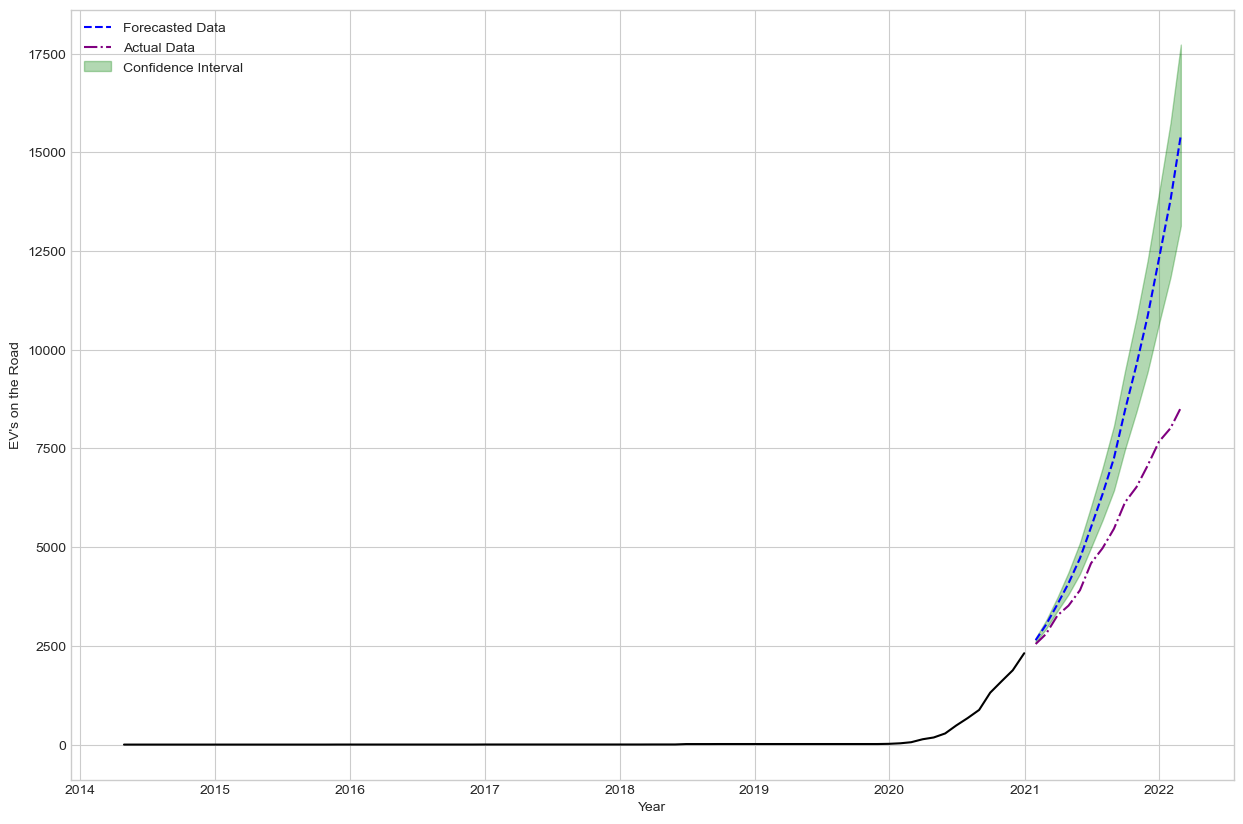

In [109]:
df_NASSU_forecast = get_forecast(model, train_NASSAU, test_NASSAU, plot=True)

Here, we can see that the forecasted data stays higher than the actual observed data. However, the observed data is almost following similar pattern and close to the lower confidence level. 

### Future Predictions
#### Fitting Model to All Observed Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                   95
Model:             SARIMAX(1, 1, 4)x(0, 1, [], 12)   Log Likelihood                -399.698
Date:                             Fri, 18 Nov 2022   AIC                            811.395
Time:                                     14:59:46   BIC                            825.458
Sample:                                 04-30-2014   HQIC                           817.020
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9836      0.022     44.054      0.000       0.940       1.027
ma.L1         -0.5616    124.211     -0.005      0.996    -244.010     242.887
ma.L2          0.0964    238.605      0.000      1.000    -467.560     467.753
ma.L3          0.8721    167.524      0.005      0.996    -327.469     329.213
ma.L4         -0.6120    170.953     -0.004      0.997    -335.673     334.449
sigma2      1753.0666    4.9e+05      0.004      0.997   -9.58e+05    9.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               144.64
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):           20249.65   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.8e+14. Standard errors may be unstable.
"""

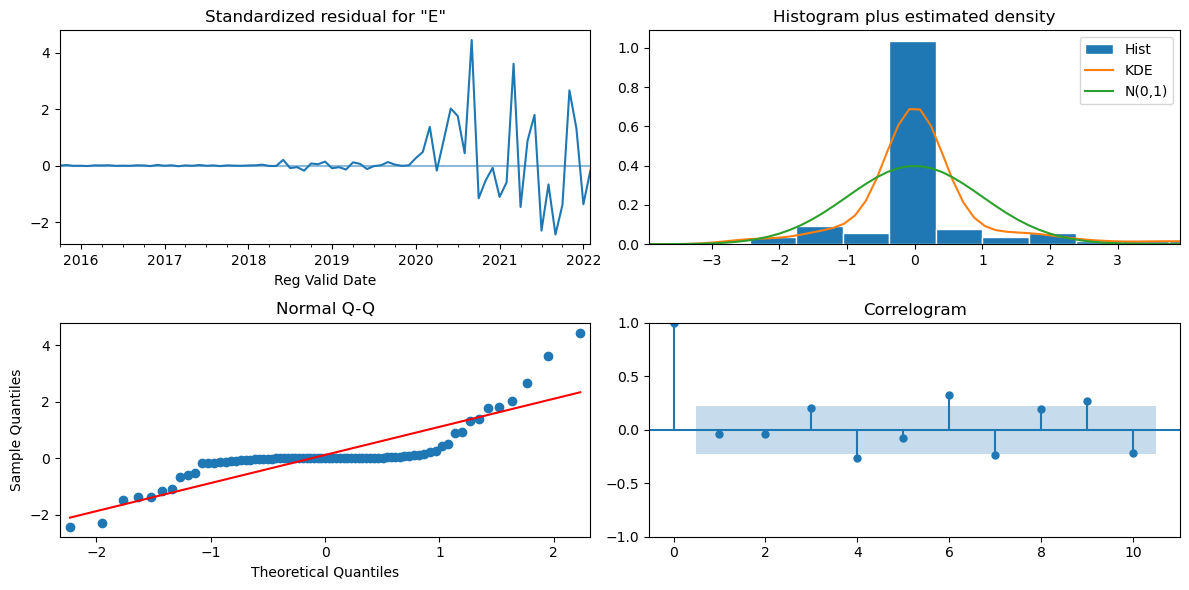

In [110]:
model = SARIMAX(county_information['NASSAU']['df'], order=(1, 1, 4), seasonal_order=(0, 1, [], 12), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

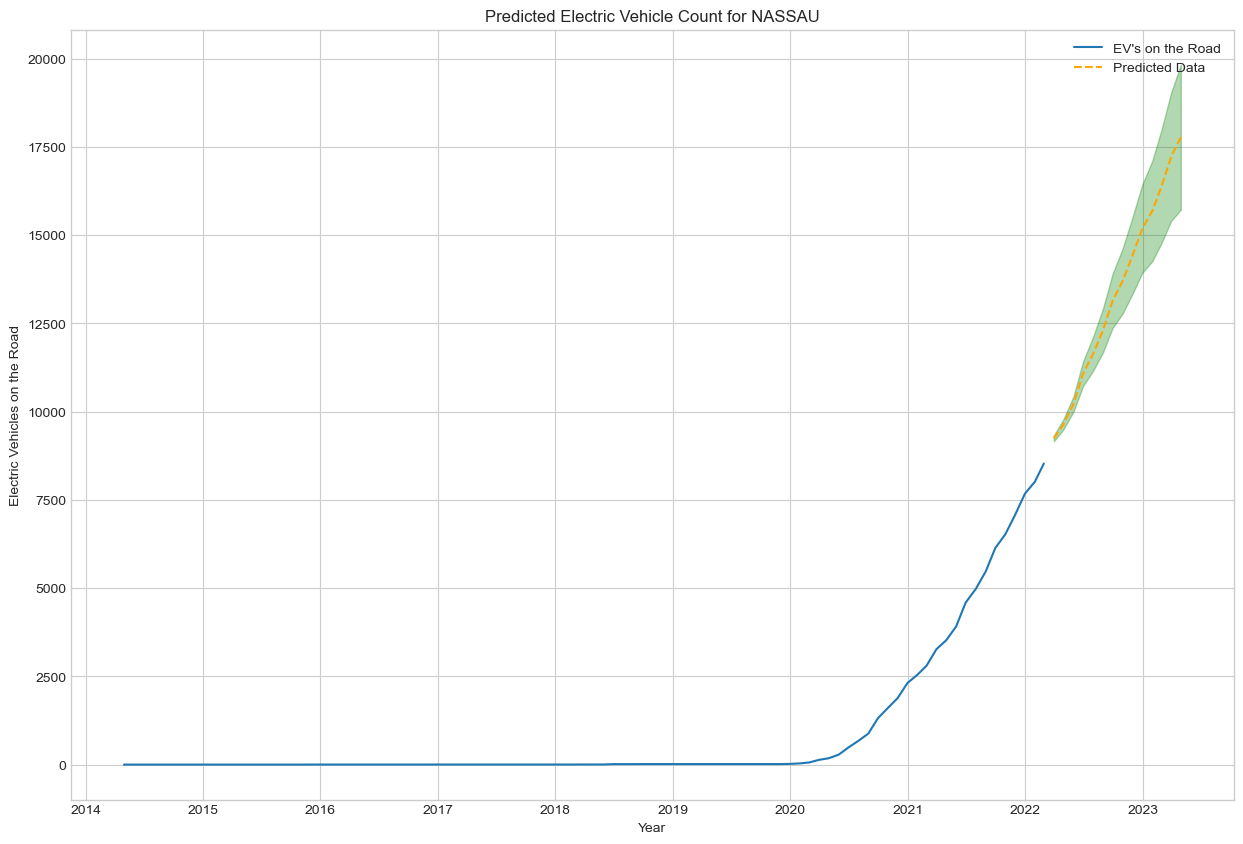

In [111]:
#getting and plotting predictions
df_NASSAU_preds = get_prediction(model, county_information['NASSAU']['df'], 
                               test_NASSAU, 'NASSAU', plot=True)

The model is predicting that the amount of electric vehicles in NASSAU county are going to keep rising in an exponential pattern.

#### Plotting & Saving Predictions

In [112]:
#saving predictions
county_information['NASSAU']['Predictions'] = df_NASSAU_preds

## SUFFOLK
### Seasonality Check

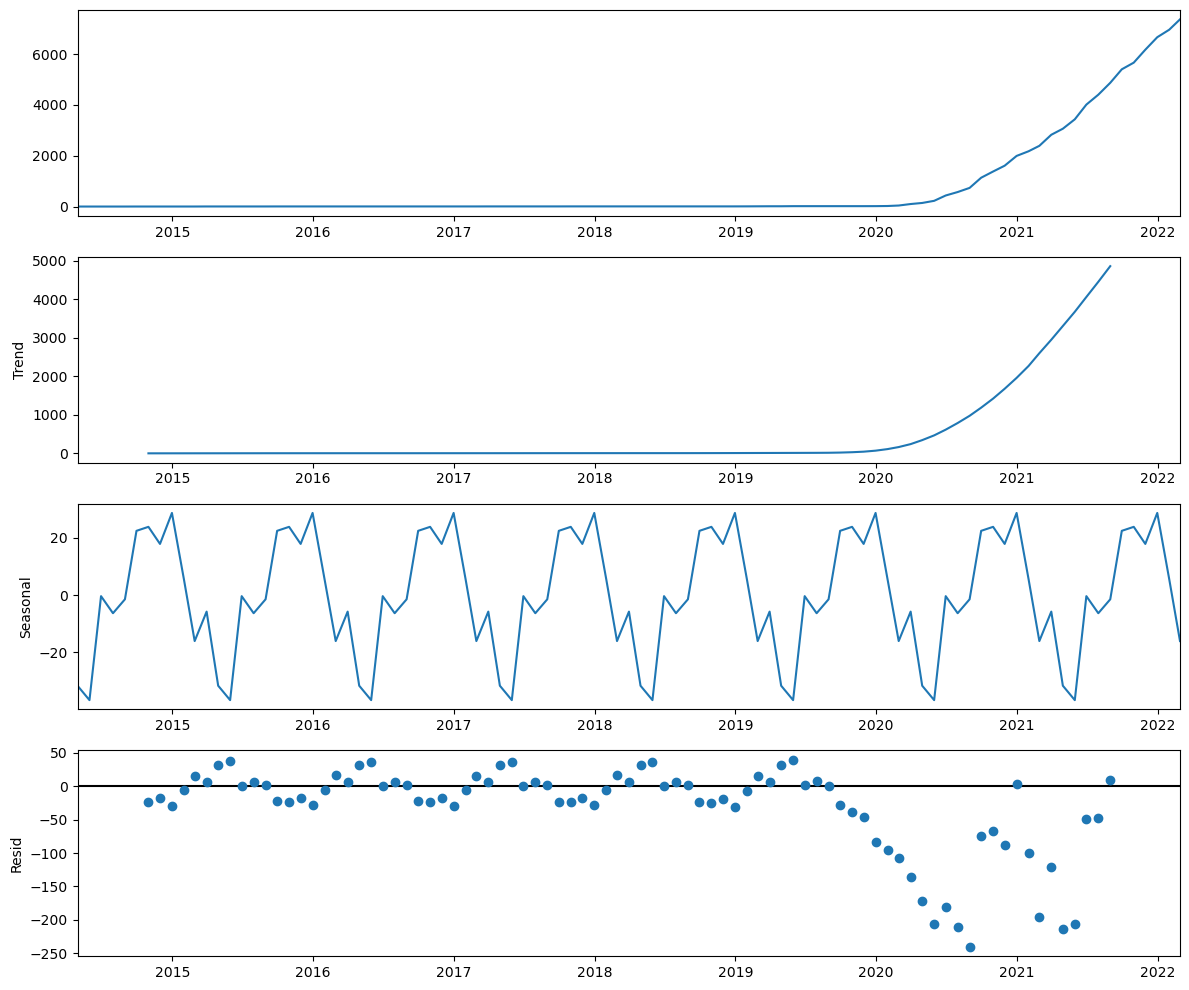

In [113]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['SUFFOLK']['df'])
decomp.plot();

As is the case with the previous counties, the decomposition for SUFFOLK County's data also suggests that there is an upwards trend and a seasonal component.

### train_test_split

After multiple iterations, we found that the 0.81-0.19 split of the data belonging to SUFFOLK County resulted in the best performance.

In [114]:
#split data into train/test sets for validation
train_SUFFOLK, test_SUFFOLK = train_test_split_ts(county_information['SUFFOLK']['df'], 
                                            0.81, 0.19)

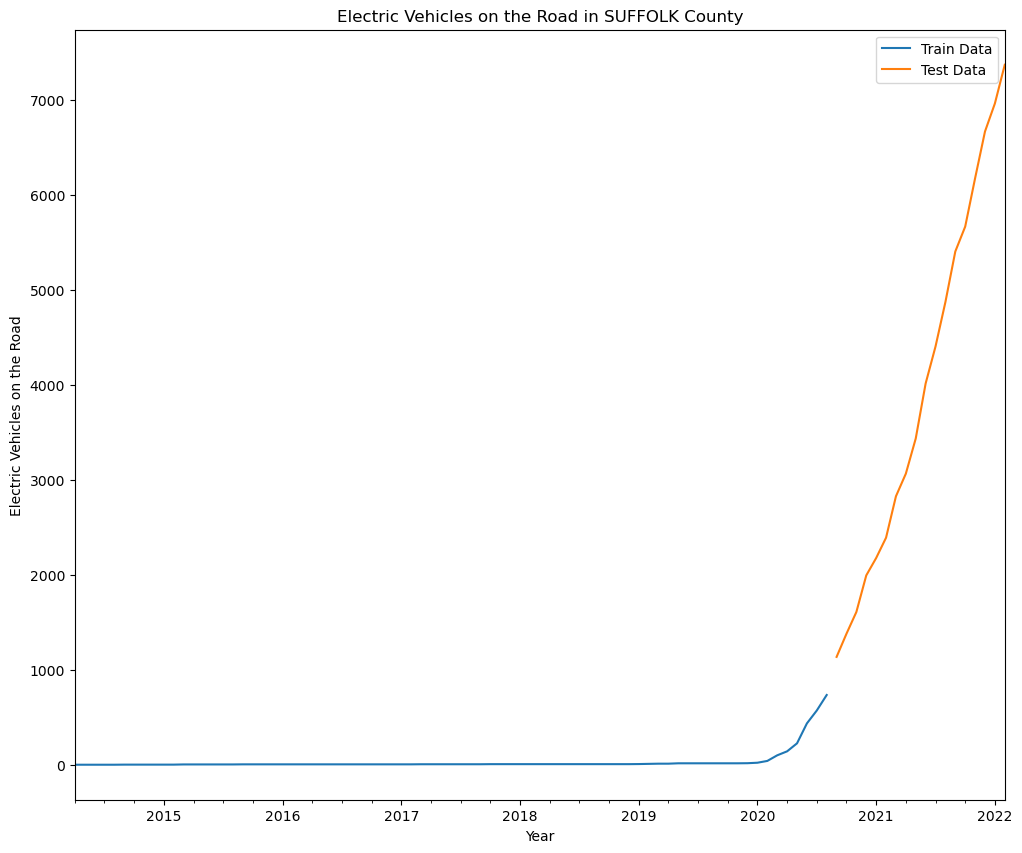

In [115]:
#plot the split
plot_train_test_split(train_SUFFOLK, test_SUFFOLK, 'SUFFOLK')

### Finding Best Parameters with Auto-Arima

In [116]:
auto_model = pm.auto_arima(train_SUFFOLK, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -328.729
Date:                Fri, 18 Nov 2022   AIC                            663.457
Time:                        14:59:50   BIC                            670.449
Sample:                    04-30-2014   HQIC                           666.252
                         - 08-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7252      0.064     11.269      0.000       0.599       0.851
ar.L2          0.2536      0.086      2.960      0.003       0.086       0.421
sigma2       321.6183     16.007     20.093      0.000     290.245     352.991
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              6365.42
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):            2560.17   Skew:                             6.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (2,1,0) for the ARIMA order withoutthe seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   77
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -318.100
Date:                Fri, 18 Nov 2022   AIC                            642.199
Time:                        14:59:50   BIC                            649.111
Sample:                    04-30-2014   HQIC                           644.956
                         - 08-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7443      0.061     12.256      0.000       0.625       0.863
ar.L2          0.3657      0.122      2.998      0.003       0.127       0.605
sigma2       317.1604     14.754     21.496      0.000     288.243     346.078
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):              4810.59
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):            2316.34   Skew:                             5.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

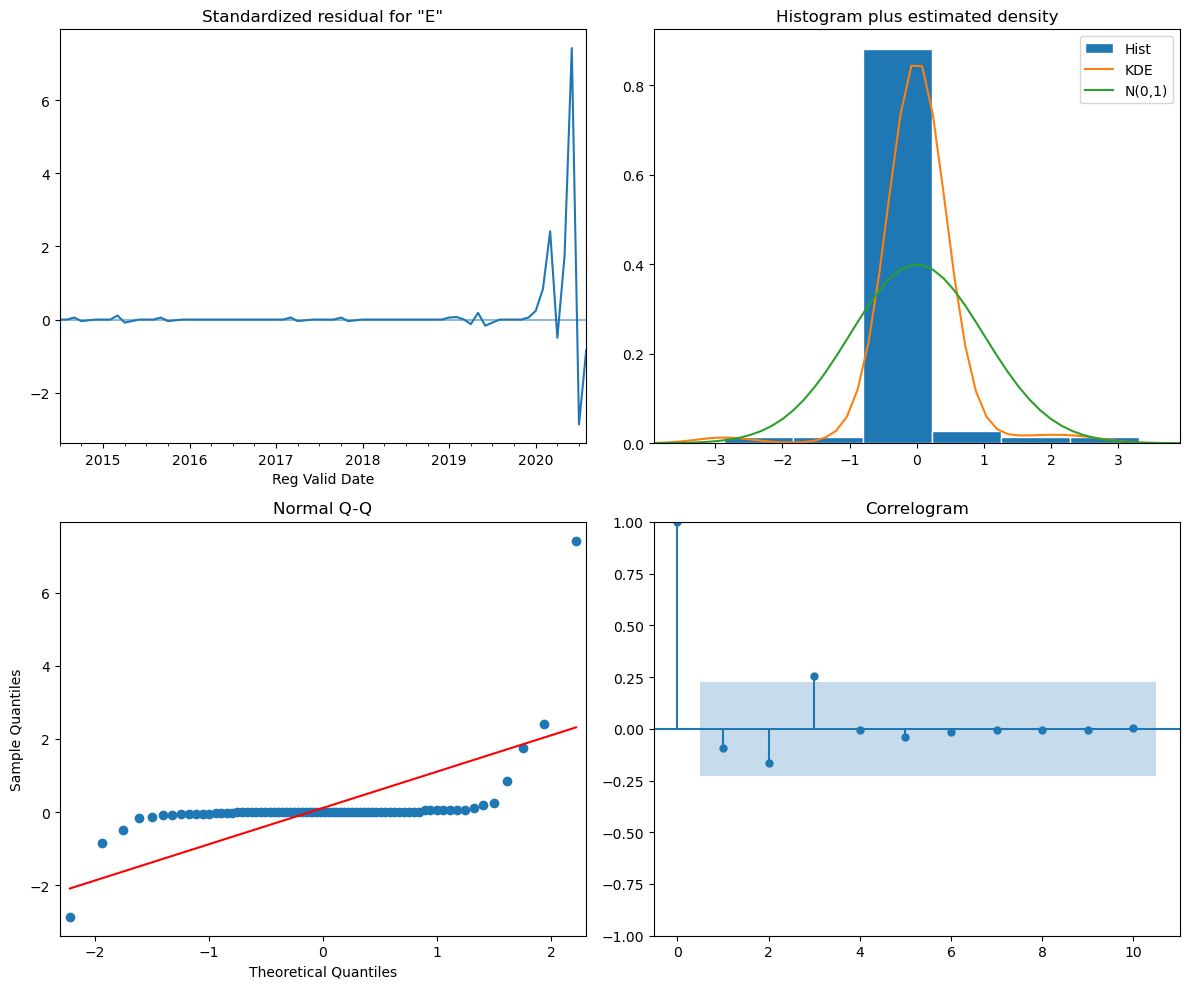

In [117]:
model = SARIMAX(train_SUFFOLK, order=(2,1,0),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

The model was almost able to remove seasonality successfully.

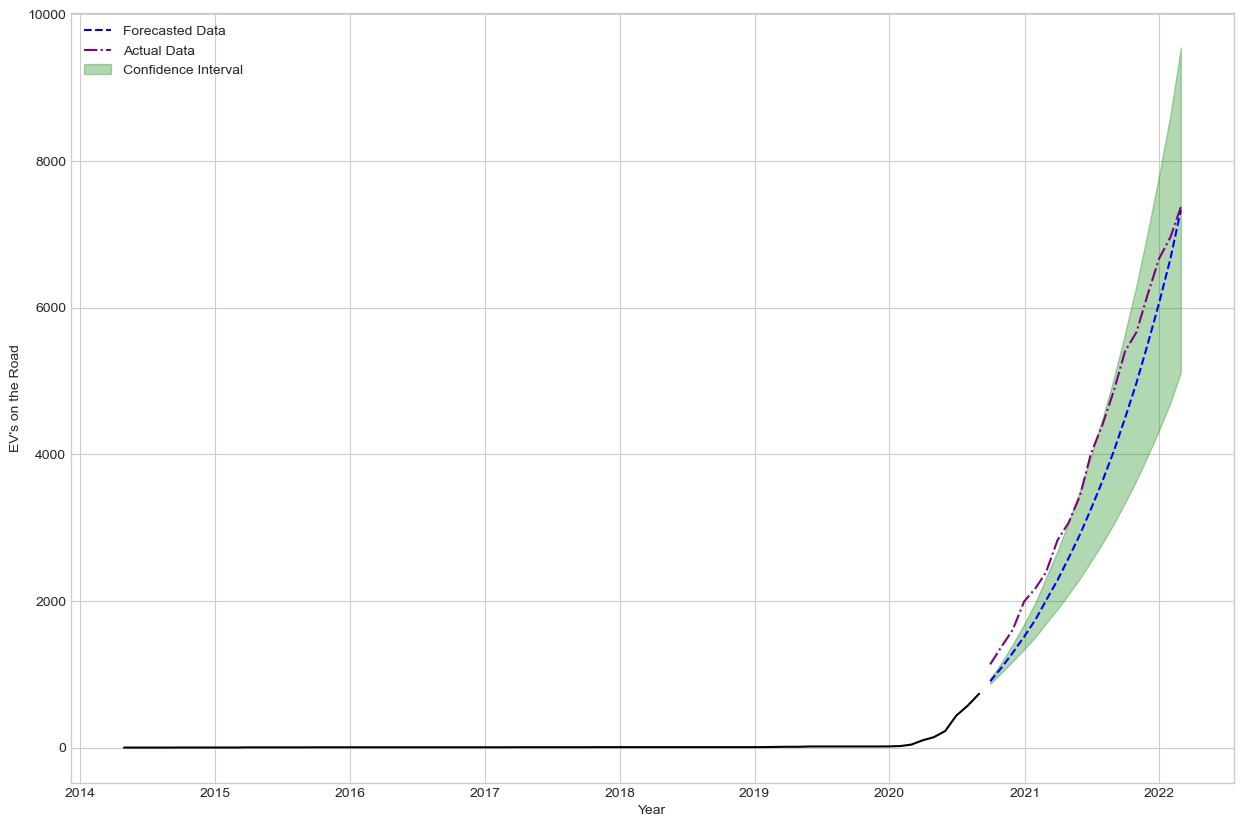

In [118]:
df_clark_forecast = get_forecast(model, train_SUFFOLK, test_SUFFOLK, plot=True)

The model's forecast stays inline with the observed data from mid-2020 to early 2022. Around March of 2020, the observed data is more than the forecasts. The observed data stays well within the confidence interval. This indicates that our model is performing very well and that we can move onto fitting the model to all the observed data to make predictions on future values.

### Future Predictions
#### Fitting Model to All Observed Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   95
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -518.398
Date:                Fri, 18 Nov 2022   AIC                           1042.797
Time:                        14:59:51   BIC                           1050.362
Sample:                    04-30-2014   HQIC                          1045.850
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4999      0.069      7.213      0.000       0.364       0.636
ar.L2          0.4842      0.078      6.188      0.000       0.331       0.638
sigma2      4590.0845    329.694     13.922      0.000    3943.897    5236.272
===================================================================================
Ljung-Box (L1) (Q):                  11.78   Jarque-Bera (JB):               200.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           47412.17   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

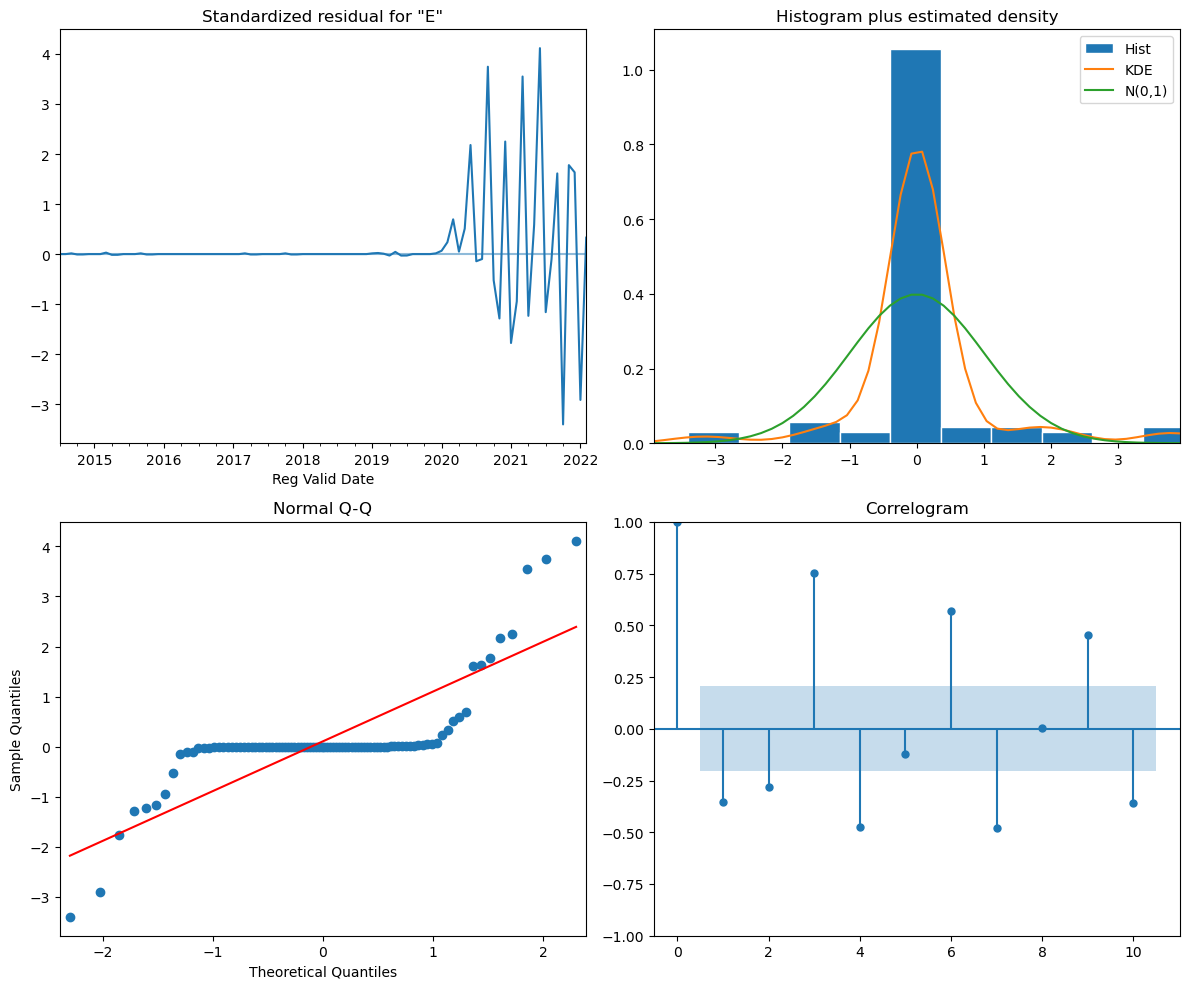

In [119]:
model = SARIMAX(county_information['SUFFOLK']['df'], order=(2, 1, 0), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

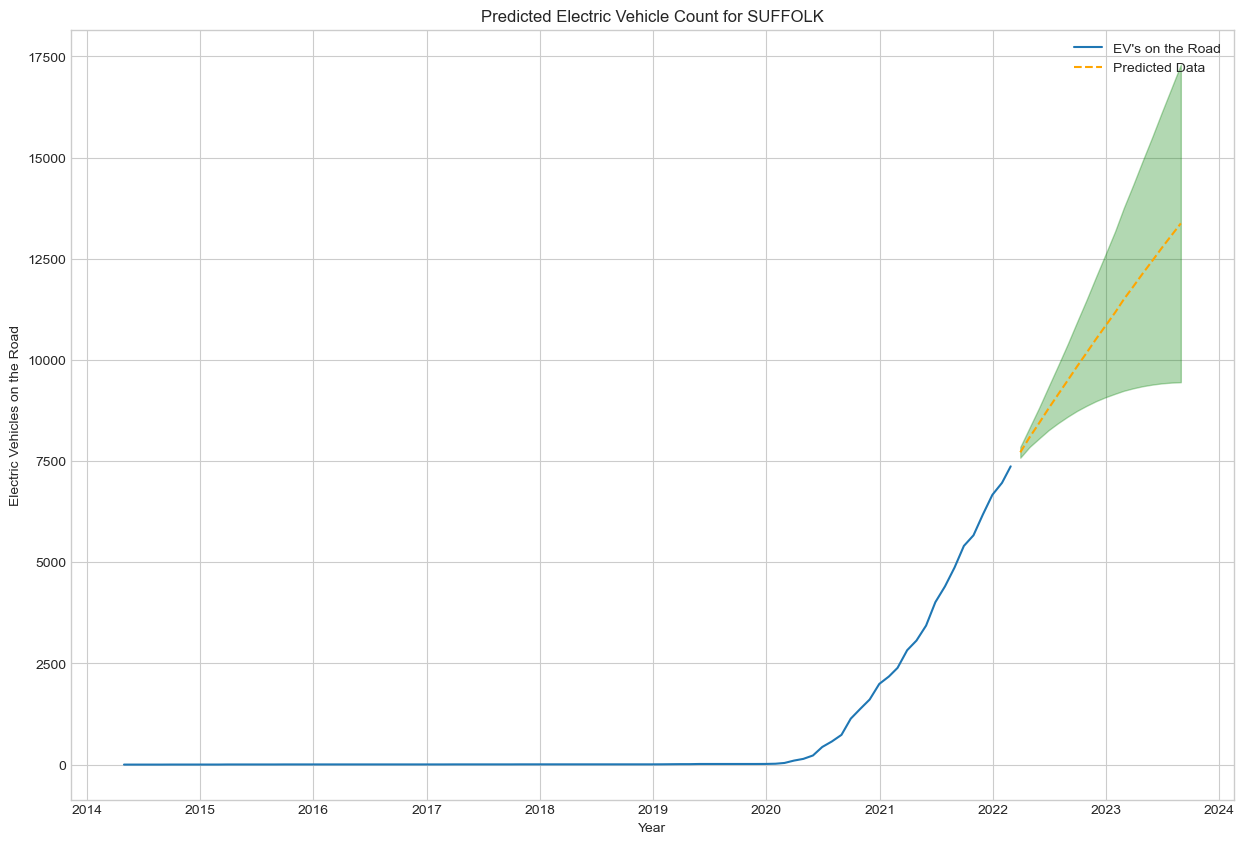

In [120]:
#getting/plotting predictions
df_SUFFOLK_preds = get_prediction(model, county_information['SUFFOLK']['df'], 
                               test_SUFFOLK, 'SUFFOLK', plot=True)

The model is predicting that the electric vehicle amount in Clark County will keep increasing exponentially in the coming years (the upper confidence limit)

In [121]:
#saving predictions
county_information['SUFFOLK']['Predictions'] = df_SUFFOLK_preds

## WESTCHESTER
### Seasonality Check

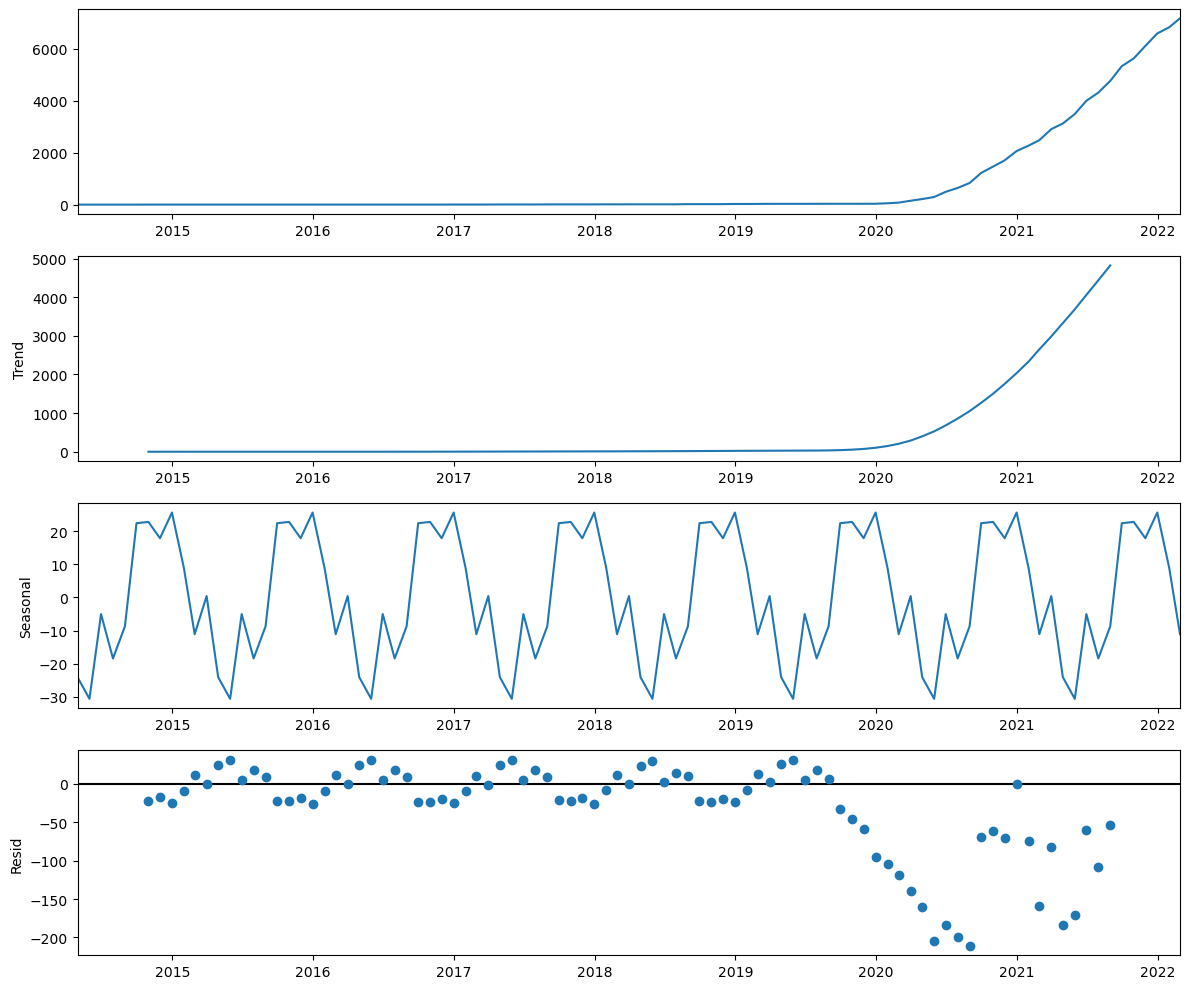

In [122]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['WESTCHESTER']['df'])
decomp.plot();

Similar to the previous counties, WESTCHESTER County's electric vehicle count is also showing an upward trend along with a seasonality component.

### train_test_split

After multiple iterations, we found that the 0.77-0.23 split of the data belonging to Thurston County resulted in the best performance.

In [123]:
#splitting data into train/test sets for validation
train_WESTCHESTER, test_WESTCHESTER = train_test_split_ts(county_information['WESTCHESTER']['df'], 
                                            0.77, 0.23)

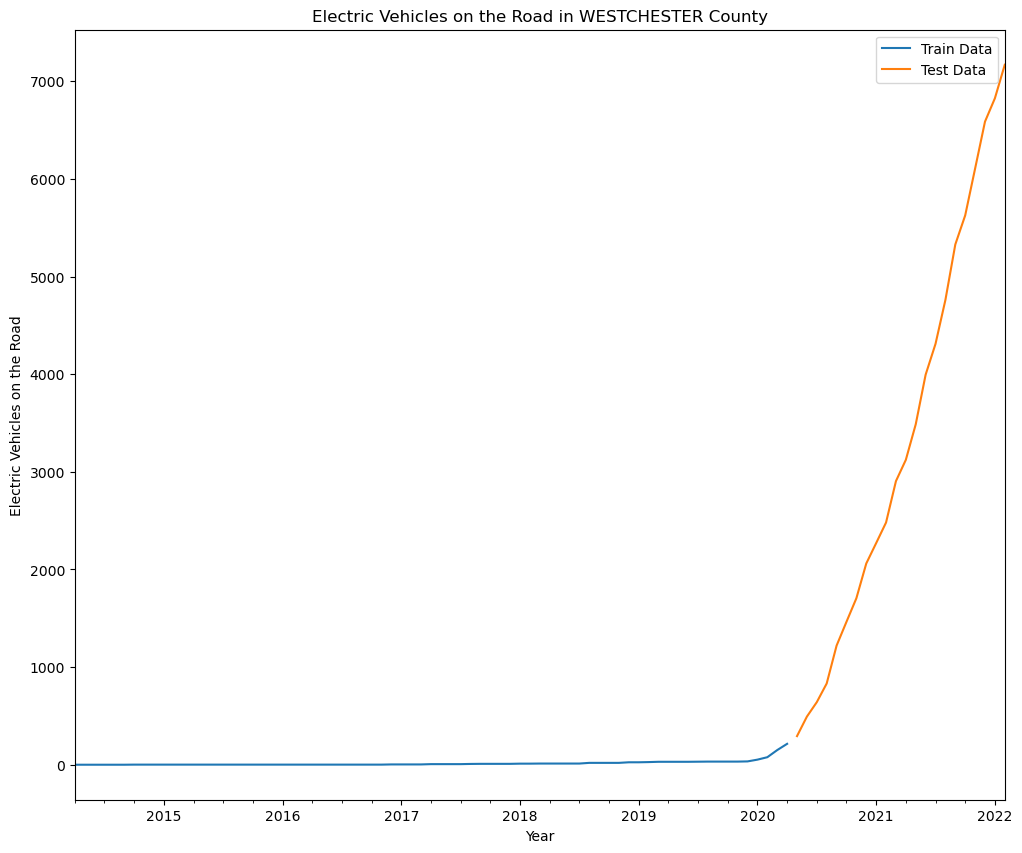

In [124]:
#plotting the split
plot_train_test_split(train_WESTCHESTER, test_WESTCHESTER, 'WESTCHESTER')

### Finding Best Parameters with Auto-Arima

In [125]:
#finding best parameters
auto_model = pm.auto_arima(train_WESTCHESTER, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -237.419
Date:                Fri, 18 Nov 2022   AIC                            478.838
Time:                        14:59:53   BIC                            483.392
Sample:                    04-30-2014   HQIC                           480.651
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9732      0.044     21.955      0.000       0.886       1.060
sigma2        41.1132      2.362     17.408      0.000      36.484      45.742
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5762.16
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):            1498.25   Skew:                             6.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (1,1,0) for the ARIMA order without the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

C:\Users\simro\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   73
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -232.078
Date:                Fri, 18 Nov 2022   AIC                            468.156
Time:                        14:59:53   BIC                            472.681
Sample:                    04-30-2014   HQIC                           469.955
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0915      0.032     34.288      0.000       1.029       1.154
sigma2        40.4281      1.994     20.276      0.000      36.520      44.336
===================================================================================
Ljung-Box (L1) (Q):                   2.63   Jarque-Bera (JB):              3805.03
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):            1287.88   Skew:                             5.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

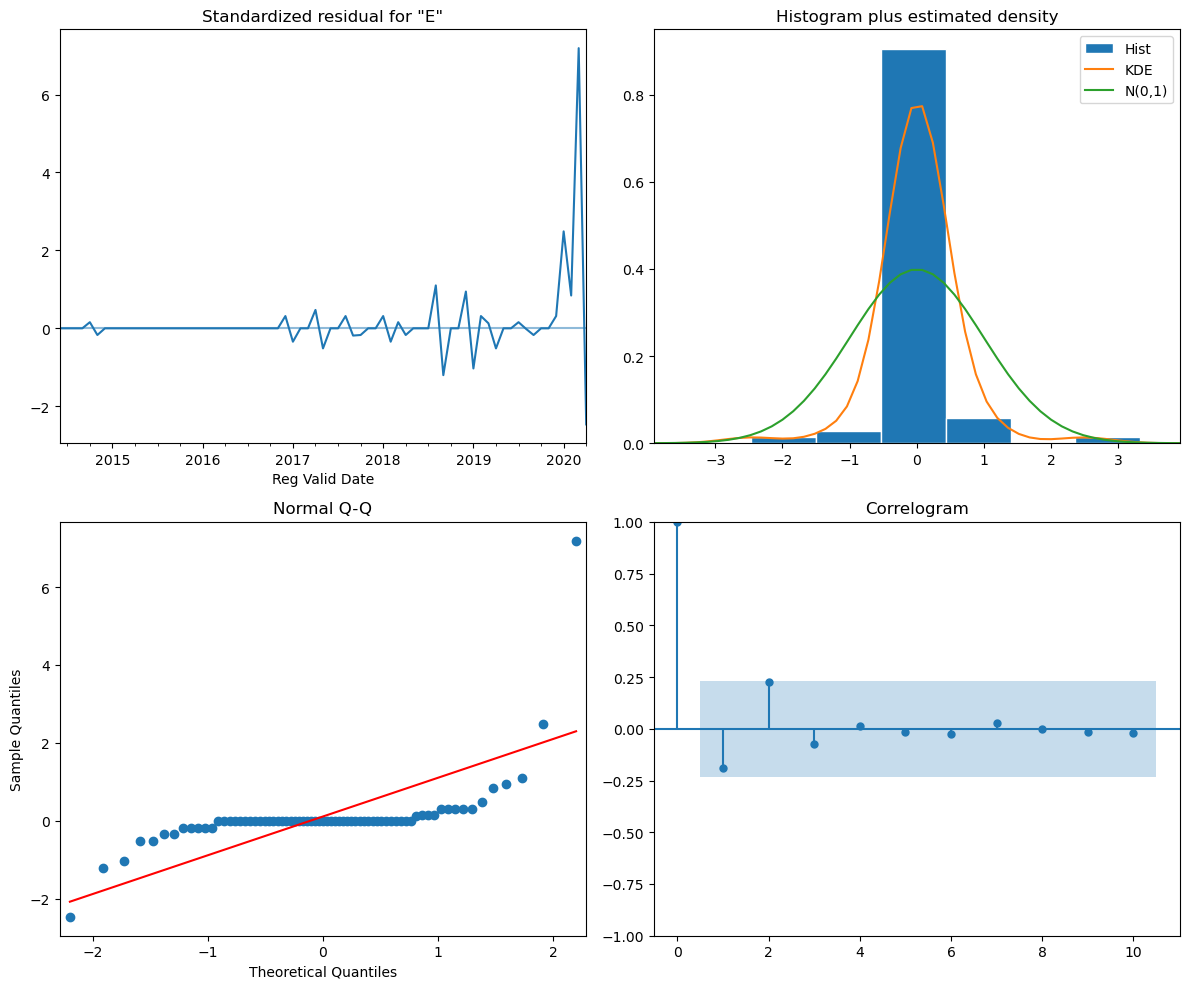

In [126]:
model = SARIMAX(train_WESTCHESTER, order=(1,1,0),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

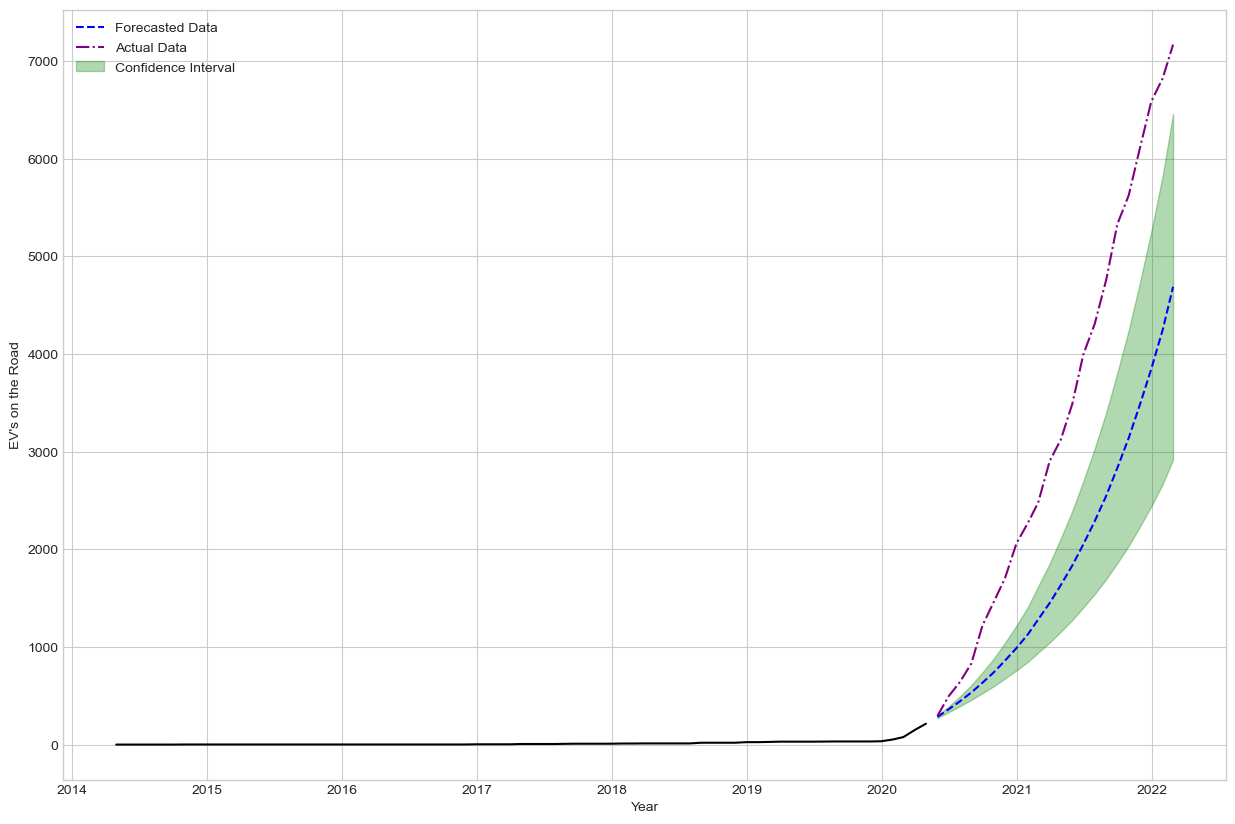

In [127]:
df_WESTCHESTER_forecast = get_forecast(model, train_WESTCHESTER, test_WESTCHESTER, 
                                    plot=True)

The forecast and the observed data are very close to each other throughout the forecasting period especially at the upper confidence interval. This suggests that our model's performing good enough with its predictions. Therefore, we can fit the model to all observed data for WESTCHESTER County and make predictions for the future electric vehicle counts.

### Future Predictions

#### Fitting Model to All Observed Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   95
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -529.141
Date:                Fri, 18 Nov 2022   AIC                           1062.281
Time:                        14:59:54   BIC                           1067.346
Sample:                    04-30-2014   HQIC                          1064.326
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9240      0.020     45.535      0.000       0.884       0.964
sigma2      5122.9801    447.283     11.454      0.000    4246.322    5999.639
===================================================================================
Ljung-Box (L1) (Q):                  19.32   Jarque-Bera (JB):                53.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           81354.43   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

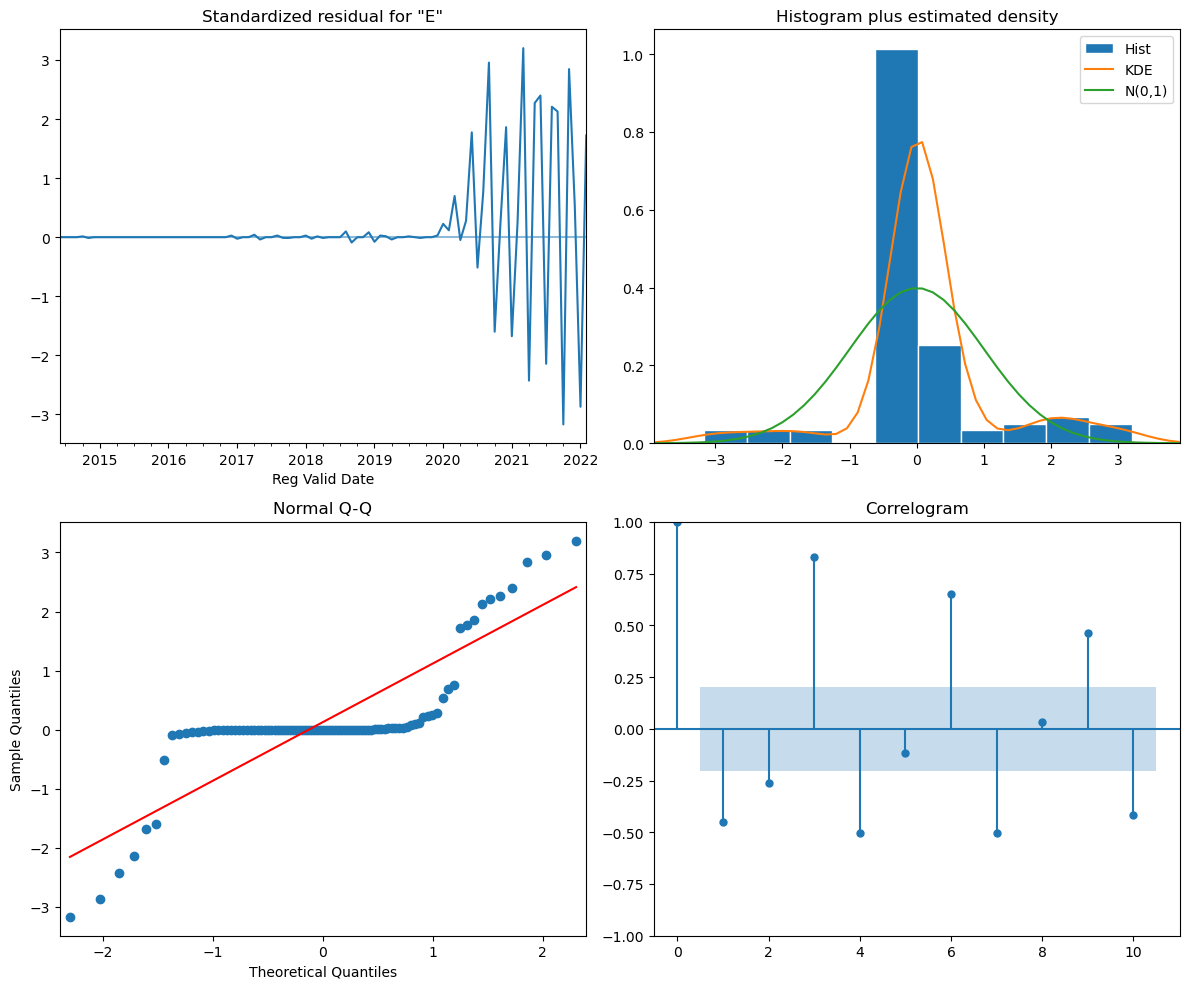

In [128]:
model = SARIMAX(county_information['WESTCHESTER']['df'], order=(1,1,0), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

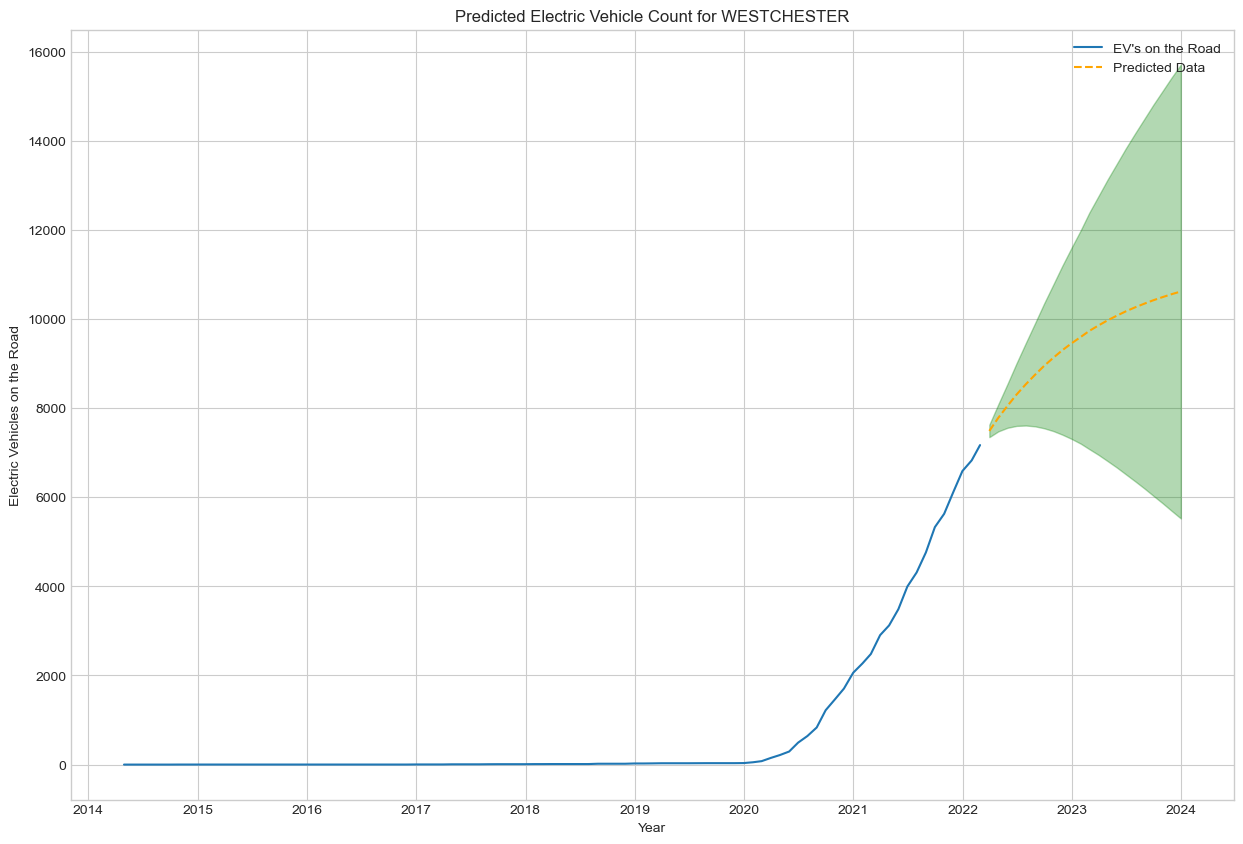

In [129]:
#getting and plotting predictions
df_WESTCHESTER_preds = get_prediction(model, county_information['WESTCHESTER']['df'], 
                               test_WESTCHESTER, 'WESTCHESTER', plot=True)

The model is predicting that the amount of electric vehicles in WESTCHESTER County are going to keep increasing at a linear rate (based on the mean prediction). However, if we look at the upper and lower confidence intervals we also see the possibilities of an exponential increase and a leveling off.

In [130]:
#saving predictions
county_information['WESTCHESTER']['Predictions'] = df_WESTCHESTER_preds

## QUEENS

### Seasonality Check

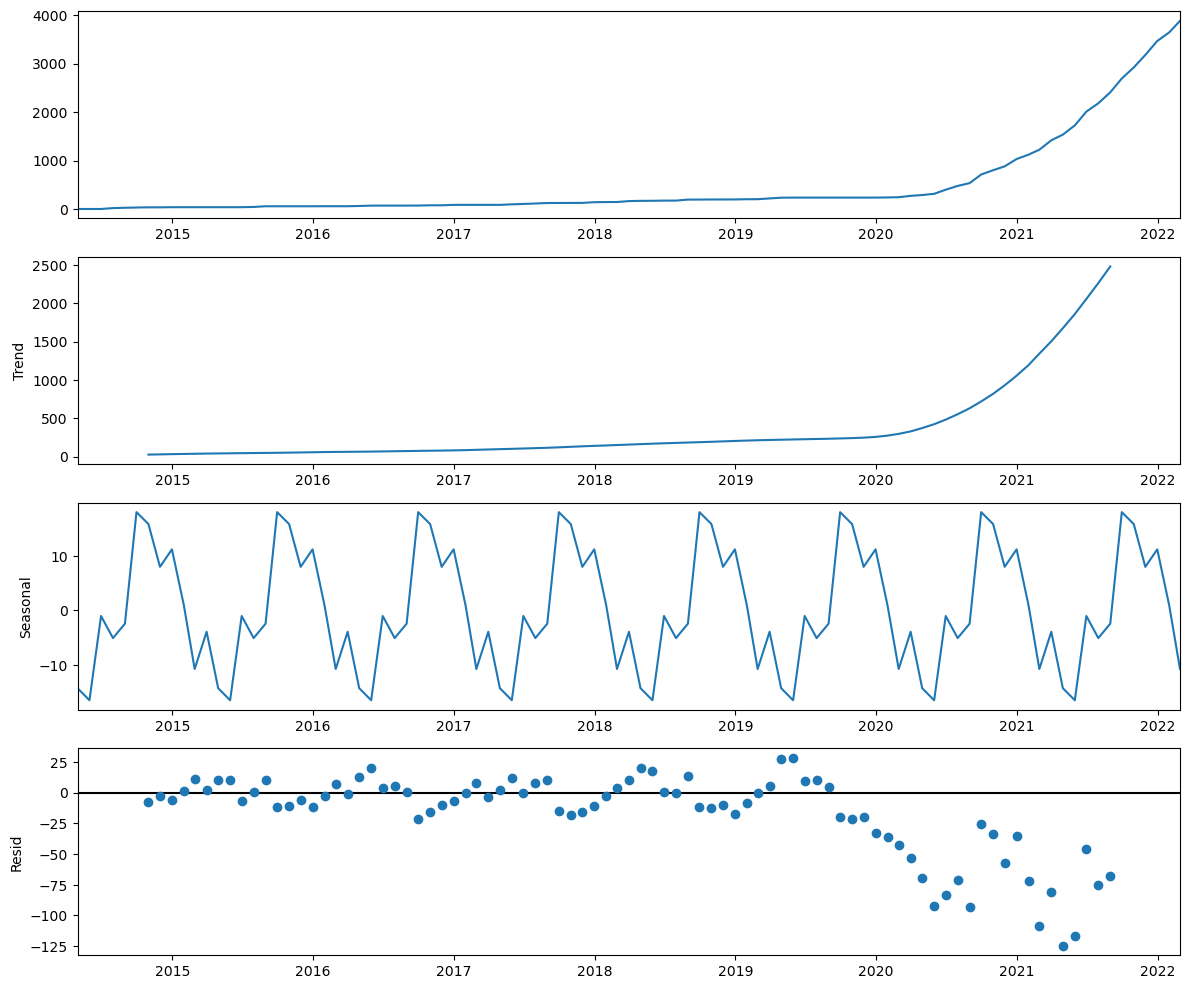

In [131]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['QUEENS']['df'])
decomp.plot();

Electric vehicle count in QUEENS County, similar to previous counties, has an upward trend. It also is showing a seasonal pattern.

### train_test_split

After multiple iterations, we found that the 0.79-0.21 split of the data belonging to Kitsap County resulted in the best performance.

In [132]:
#splitting data into train/test sets for validation
train_QUEENS, test_QUEENS = train_test_split_ts(county_information['QUEENS']['df'], 
                                            0.79, 0.21)

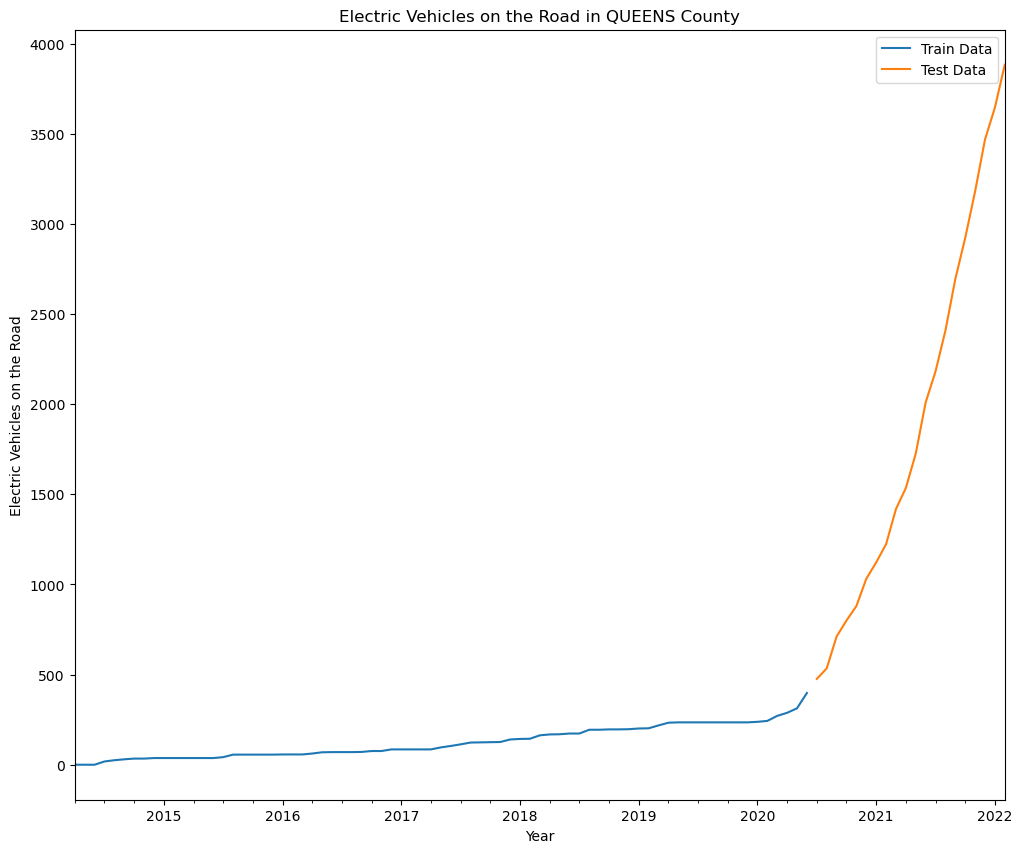

In [133]:
#plotting the split
plot_train_test_split(train_QUEENS, test_QUEENS, 'QUEENS')

### Finding Best Parameters with Auto-Arima

In [134]:
#finding best parameters
auto_model = pm.auto_arima(train_QUEENS, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -271.479
Date:                Fri, 18 Nov 2022   AIC                            552.957
Time:                        15:00:00   BIC                            564.478
Sample:                    04-30-2014   HQIC                           557.553
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1095      0.259     -0.422      0.673      -0.618       0.399
ar.L2          0.4689      0.212      2.213      0.027       0.054       0.884
ar.L3          0.5610      0.205      2.741      0.006       0.160       0.962
ma.L1          0.7394      0.225      3.285      0.001       0.298       1.181
sigma2        86.4749     11.617      7.444      0.000      63.707     109.243
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               668.89
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               7.53   Skew:                             2.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (3, 1, 0) for the ARIMA order without  seasonality. 

### Validate Model with Forecasts for Test Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   75
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -258.096
Date:                Fri, 18 Nov 2022   AIC                            526.193
Time:                        15:00:00   BIC                            537.506
Sample:                    04-30-2014   HQIC                           530.692
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1038      0.229      0.454      0.650      -0.345       0.552
ar.L2          0.6301      0.234      2.694      0.007       0.172       1.089
ar.L3          0.7186      0.170      4.215      0.000       0.384       1.053
ma.L1          0.6630      0.212      3.133      0.002       0.248       1.078
sigma2        83.4541     13.051      6.394      0.000      57.874     109.035
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               267.35
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                             2.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

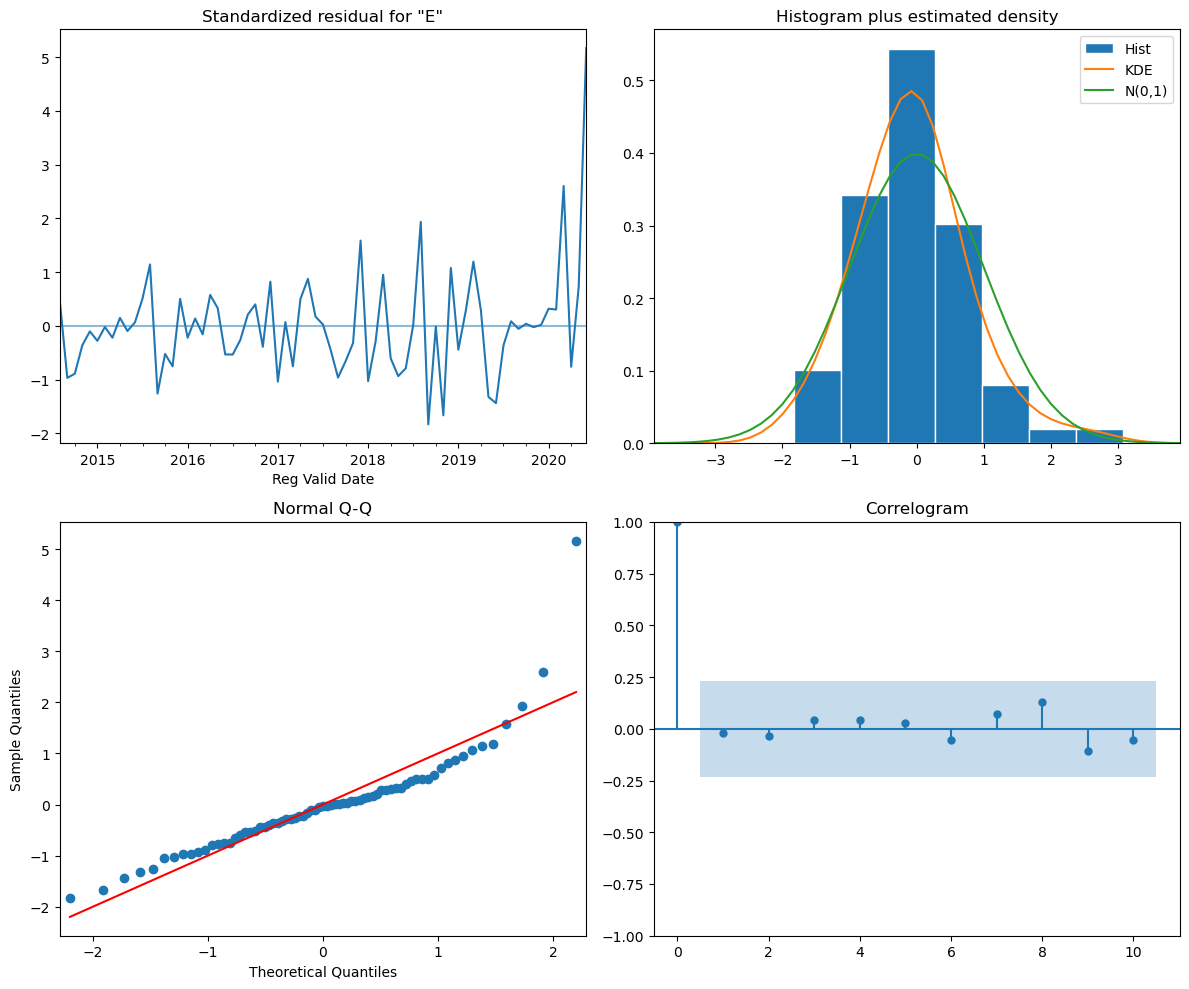

In [135]:
model = SARIMAX(train_QUEENS, order=(3, 1, 1),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

The p-values for all the coefficients in the model are statistically significant based on an alpha value of 0.05. Additionally, the residuals are nearly normally distributed with seasonality successfully removed. Next, we can make predictions on the electric vehicle counts for future dates.

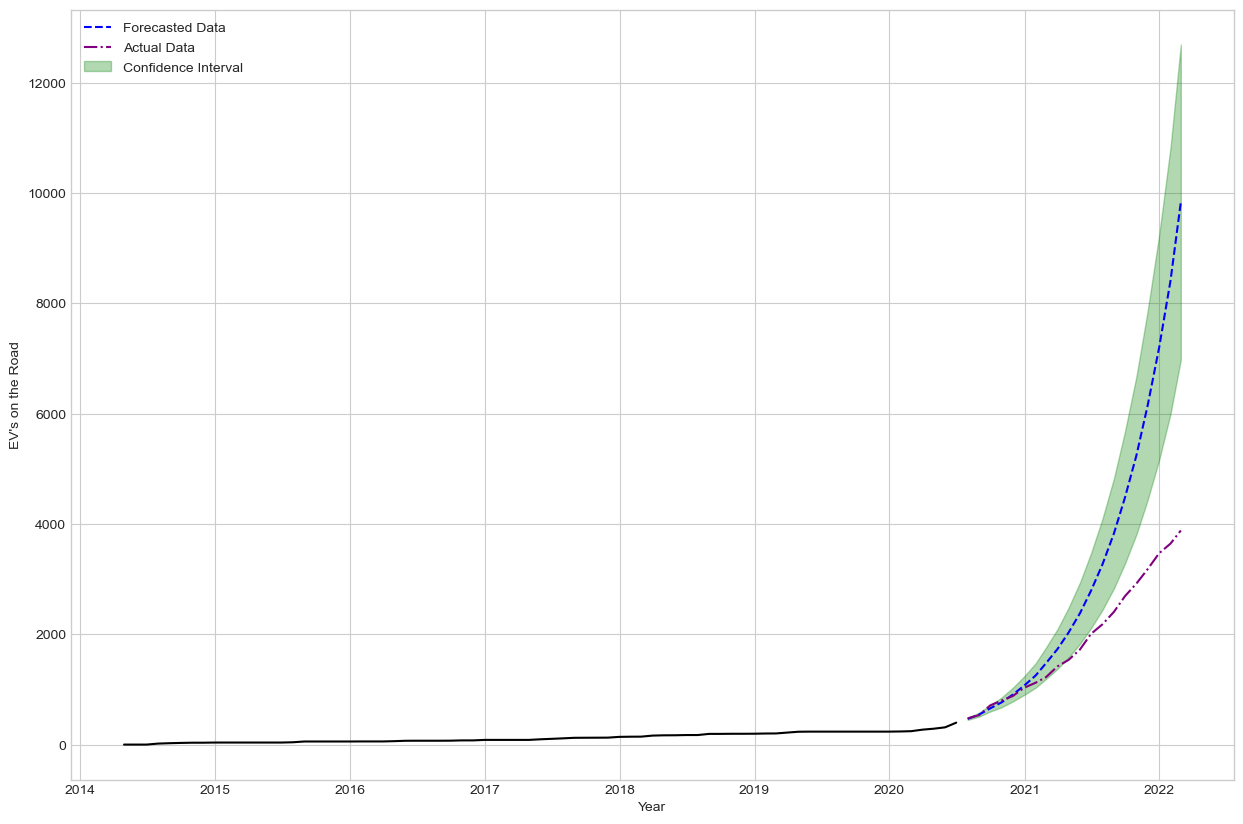

In [136]:
df_Queens_forecast = get_forecast(model, train_QUEENS, test_QUEENS, plot=True)

The forecast and the observed data seem to be very close to each othe before mid 2021 and close to the lower confidence interval for the rest of time frame which validates that the model is ready to be fitted to all observed data to make future predictions.

### Future Predictions

#### Fitting Model to All Observed Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   95
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -397.292
Date:                Fri, 18 Nov 2022   AIC                            804.584
Time:                        15:00:01   BIC                            817.139
Sample:                    04-30-2014   HQIC                           809.649
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0028      0.083      0.034      0.973      -0.159       0.165
ar.L2          0.1911      0.062      3.062      0.002       0.069       0.313
ar.L3          0.9124      0.059     15.488      0.000       0.797       1.028
ma.L1          0.4341      0.127      3.405      0.001       0.184       0.684
sigma2       361.9591     32.695     11.071      0.000     297.878     426.040
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):               194.58
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):              34.73   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

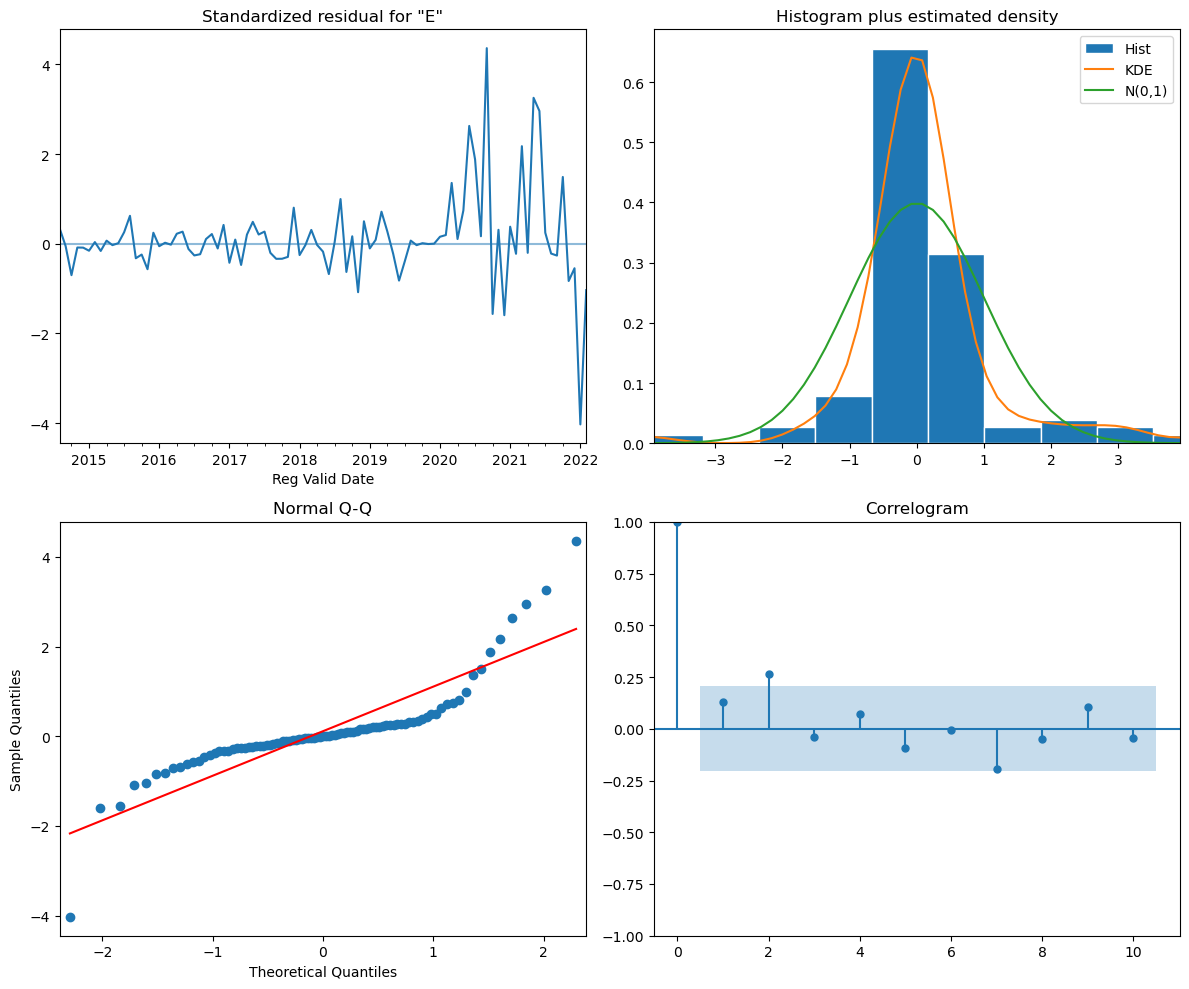

In [137]:
model = SARIMAX(county_information['QUEENS']['df'], order=(3, 1, 1), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)


#### Plotting & Saving Predictions

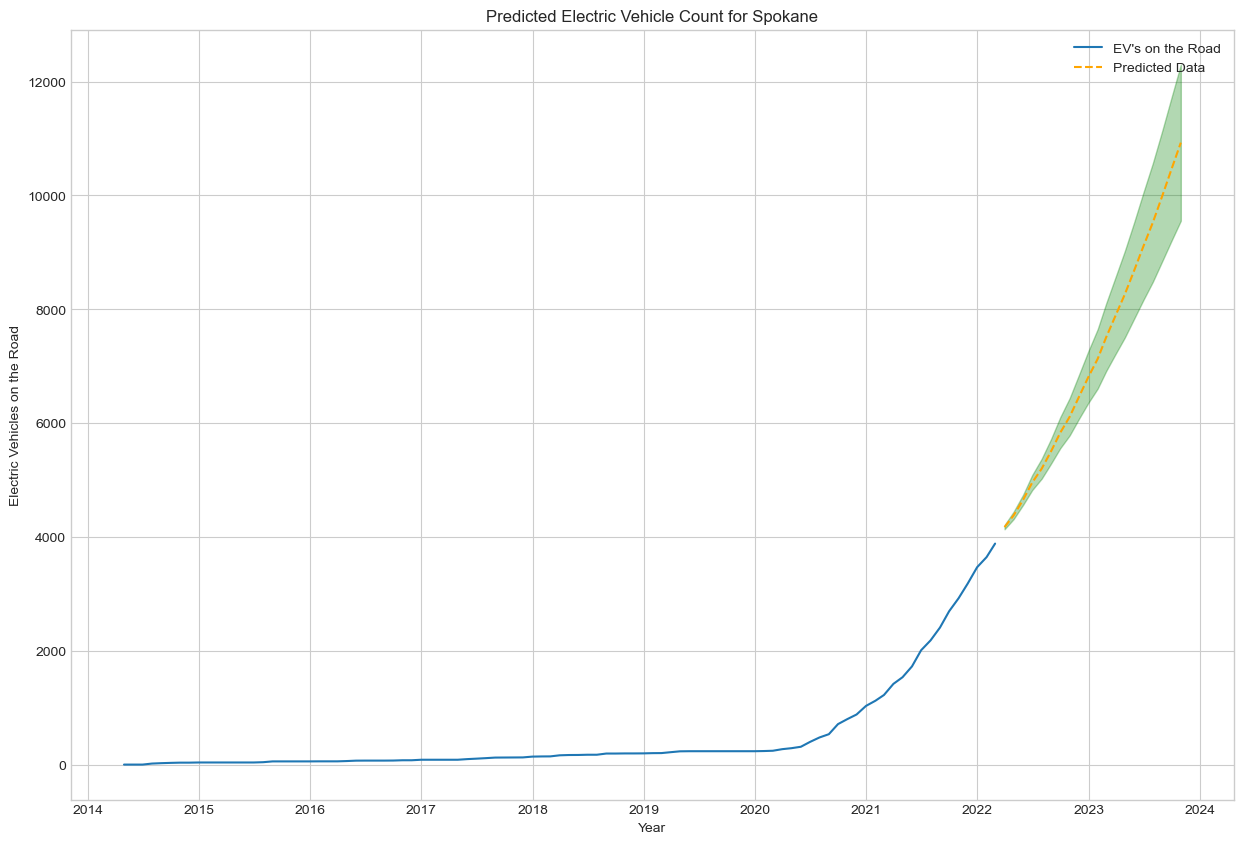

In [138]:
#getting and plotting predictions
df_QUEENS_preds = get_prediction(model, county_information['QUEENS']['df'], 
                               test_QUEENS, 'Spokane', plot=True)

Above, we can see that the model is predicting the amount of electric vehicles in QUEENS County to keep increasing exponentially. 

In [139]:
#saving predictions
county_information['QUEENS']['Predictions'] = df_QUEENS_preds

## NEW YORK

### Seasonality Check

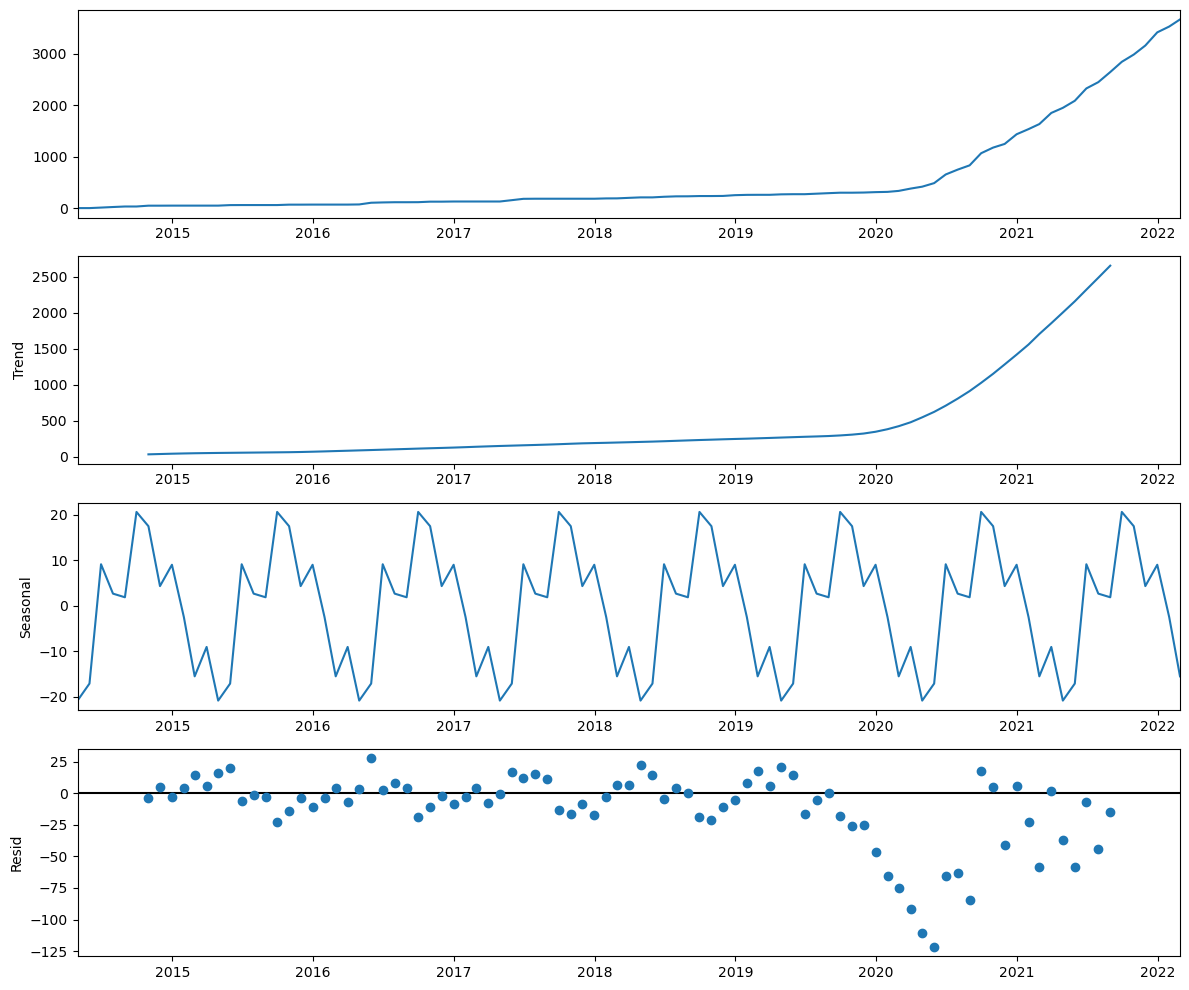

In [140]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['NEW YORK']['df'])
decomp.plot();

### train_test_split

In [141]:
#splitting data into train/test sets for validation
train_NEW_YORK, test_NEW_YORK = train_test_split_ts(county_information['NEW YORK']['df'], 
                                            0.85, 0.15)

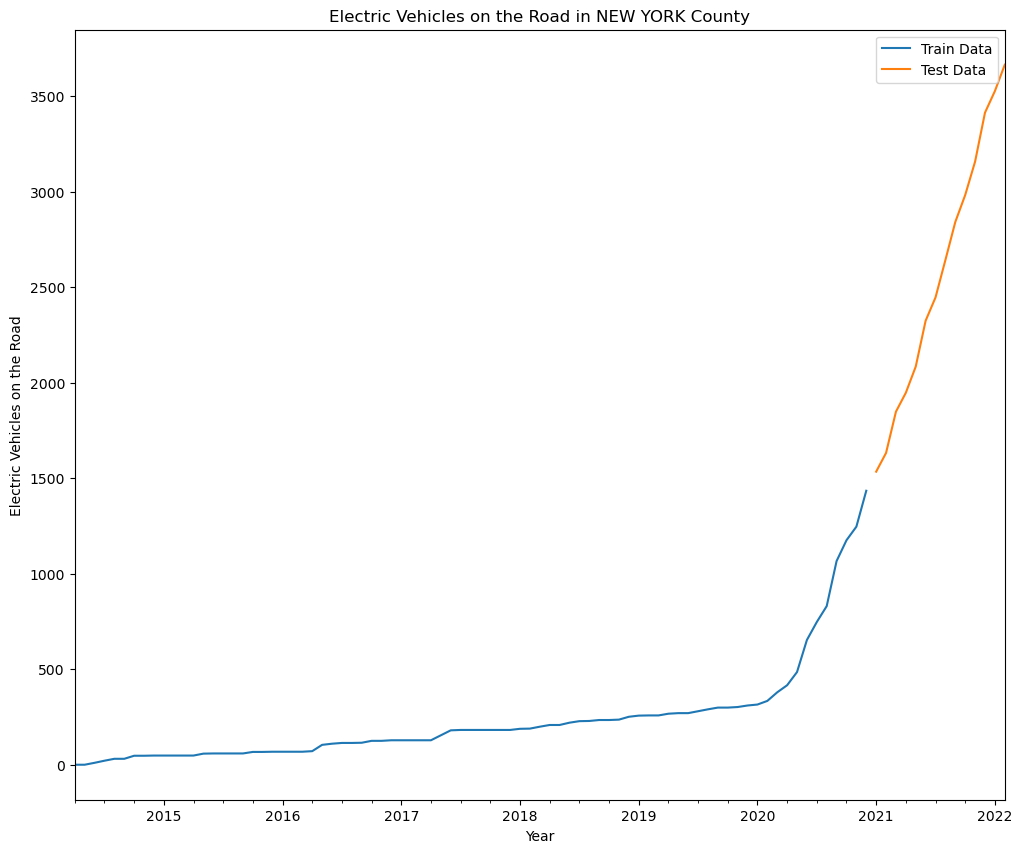

In [142]:
#plotting the split
plot_train_test_split(train_NEW_YORK, test_NEW_YORK, 'NEW YORK')

### Finding Best Parameters with Auto-Arima

In [143]:
#finding best parameters
auto_model = pm.auto_arima(train_NEW_YORK, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -326.126
Date:                             Fri, 18 Nov 2022   AIC                            658.253
Time:                                     15:00:04   BIC                            664.911
Sample:                                 04-30-2014   HQIC                           660.891
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9876      0.023     42.430      0.000       0.942       1.033
ma.L1         -0.5784      0.103     -5.640      0.000      -0.779      -0.377
sigma2       829.3633     73.007     11.360      0.000     686.271     972.455
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               539.74
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):              48.31   Skew:                             3.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (1,1,1) for the ARIMA order with with (0, 1, [0], 12) for seasonality. 

### Validate Model with Forecasts for Test Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -313.901
Date:                             Fri, 18 Nov 2022   AIC                            633.802
Time:                                     15:00:04   BIC                            640.371
Sample:                                 04-30-2014   HQIC                           636.397
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1065      0.028     38.971      0.000       1.051       1.162
ma.L1         -0.7533      0.105     -7.204      0.000      -0.958      -0.548
sigma2       787.1511     64.849     12.138      0.000     660.050     914.252
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               358.91
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              48.16   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

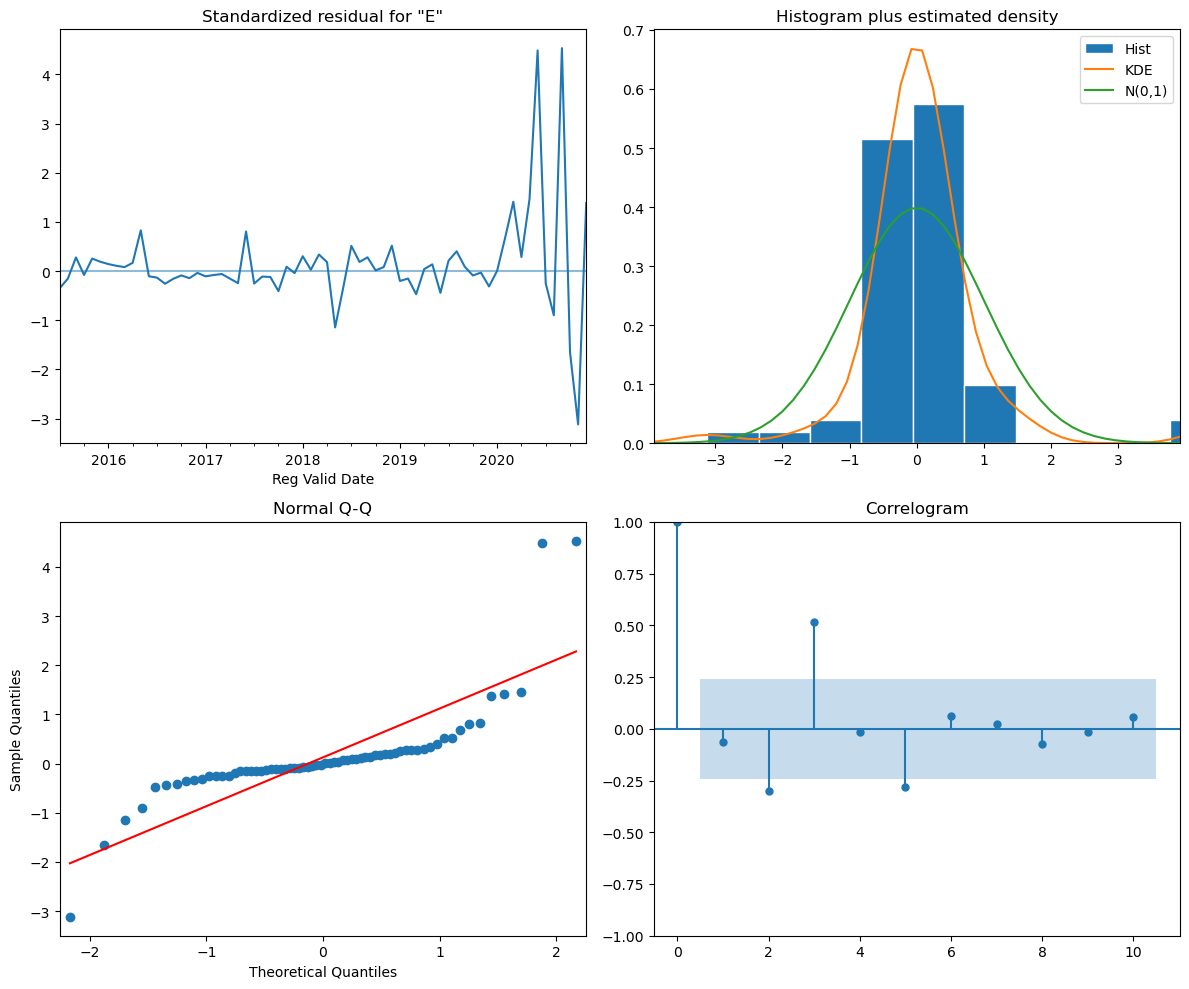

In [144]:
#fitting SARIMAX model with best params
model = SARIMAX(train_NEW_YORK, order=(1,1,1),seasonal_order=(0, 1, [], 12),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

The residuals for the model seem to be mostly normally distributed once again with the tails of the Q-Q plot not being ideal. However, these results are based on the best parameters that we could find in our gridsearch so we'll continue using this model.

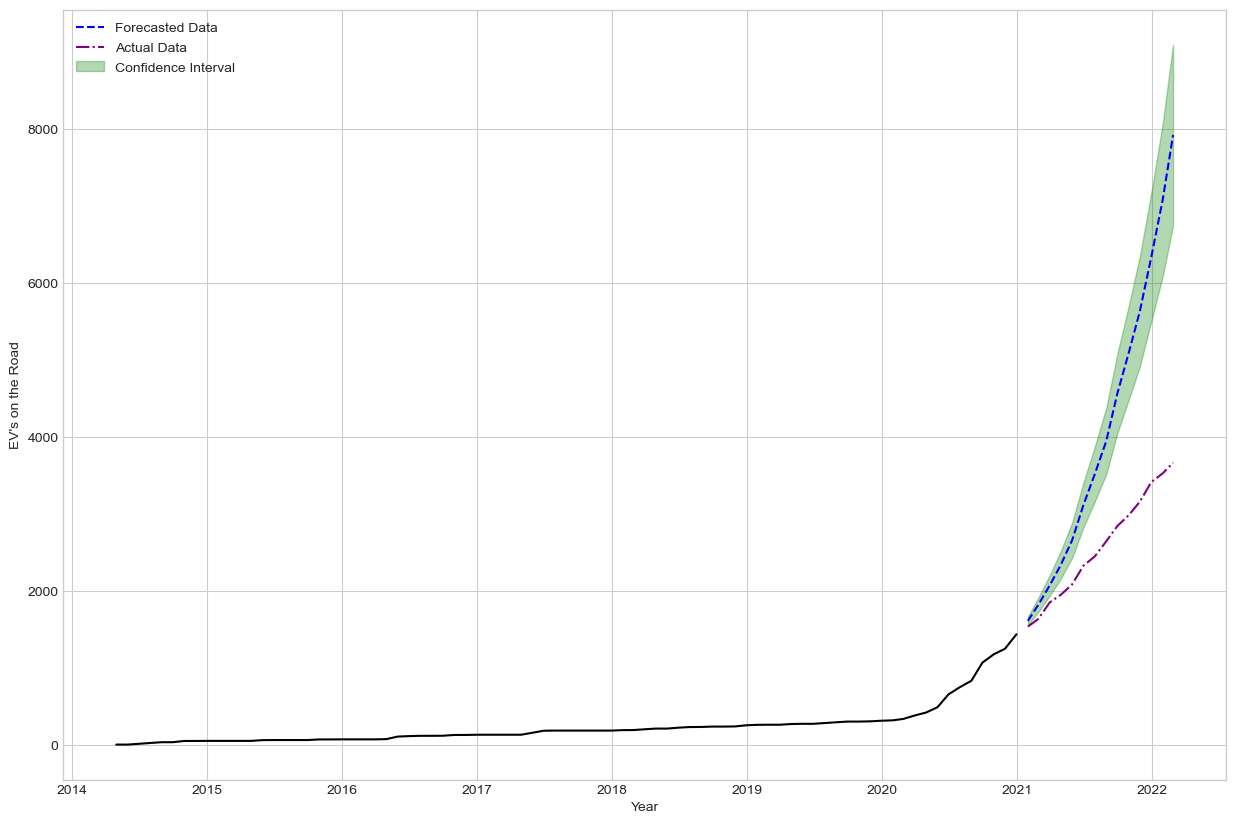

In [145]:
df_NEY_YORK_forecast = get_forecast(model, train_NEW_YORK, test_NEW_YORK, plot=True)

Both of the forcast and actual data have upward trend. the forecasted values seem to be higher than the actual observed values which may be due to the COVID-19 pandemic and the many supply chain issues it caused. These issues may have affected the electric vehicle sales in Whatcom County causing this discrepancy.

### Future Predictions

#### Fitting Model to All Observed Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -396.732
Date:                             Fri, 18 Nov 2022   AIC                            799.464
Time:                                     15:00:05   BIC                            806.610
Sample:                                 04-30-2014   HQIC                           802.329
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9681      0.023     41.744      0.000       0.923       1.014
ma.L1         -0.6301      0.096     -6.553      0.000      -0.819      -0.442
sigma2      1186.0134    109.812     10.800      0.000     970.787    1401.240
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):               187.47
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):              63.09   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

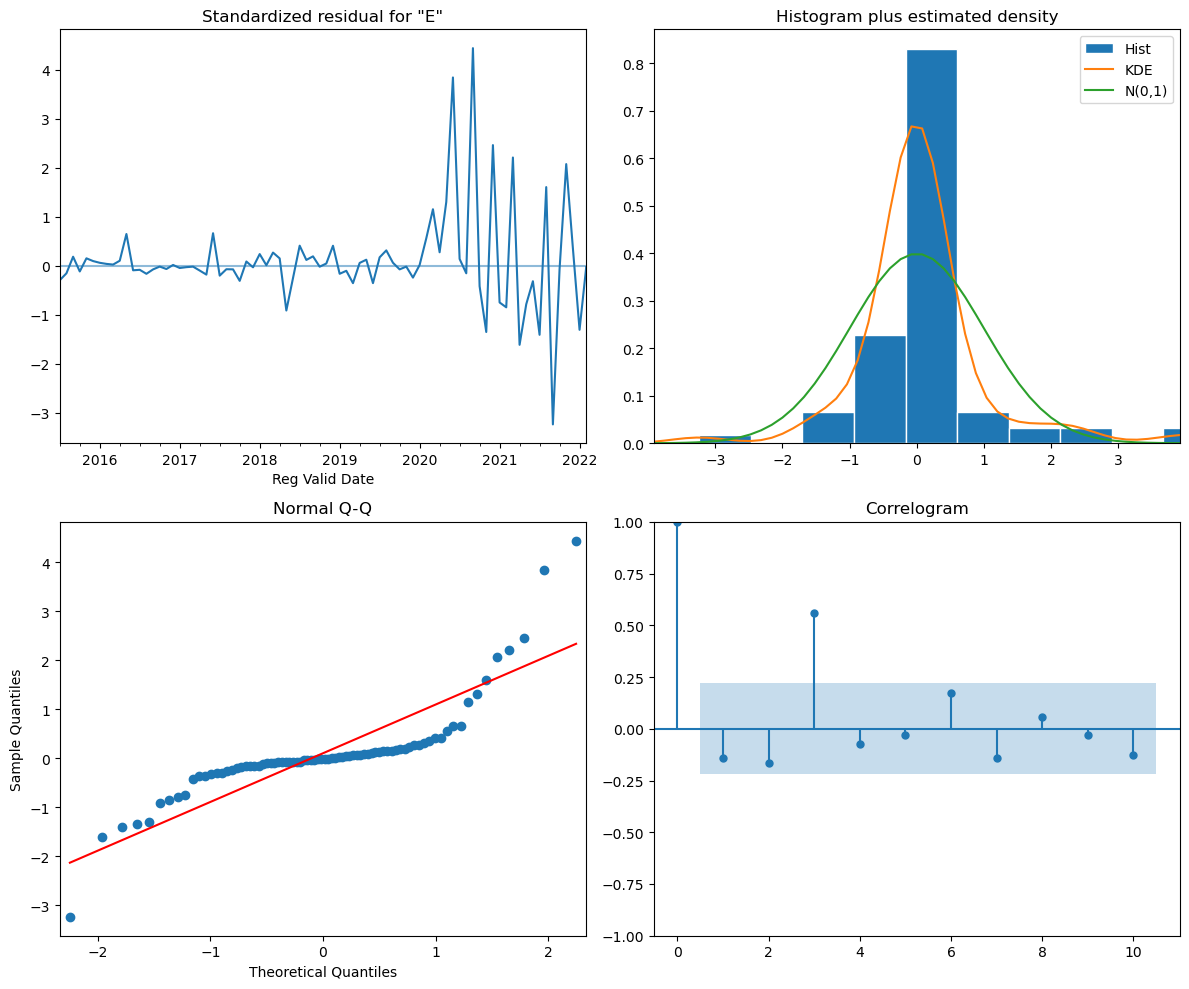

In [146]:
model = SARIMAX(county_information['NEW YORK']['df'], order=(1,1,1),seasonal_order=(0, 1, [], 12),
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

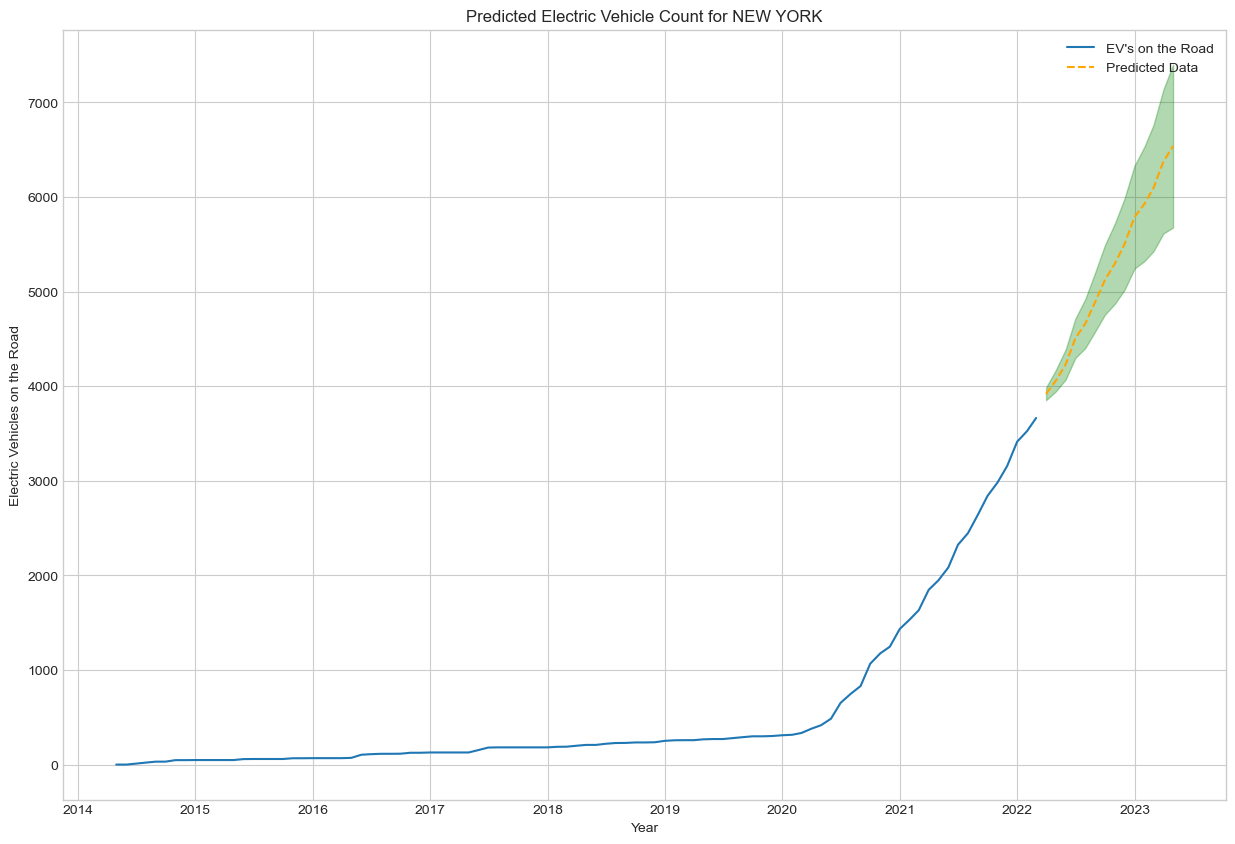

In [147]:
#getting and plotting predictions
df_NEW_YORK_preds = get_prediction(model, county_information['NEW YORK']['df'], 
                               test_NEW_YORK, 'NEW YORK', plot=True)

Above, we can see that the model is predicting the electric vehicle count in Ney York County to keep increasing exponentially.

In [148]:
#saving predictions
county_information['NEW YORK']['Predictions'] = df_NEW_YORK_preds

In order to interpret our results correctly, we need to consider the existing charging infrastructure in order to determine which counties have the greatest potential for investment.

## Current Charger Infrastructure by County

### Importing the data

## Current Charger Infrastructure by County

In [149]:
df_chargers = pd.read_csv('Resources/Electric_Vehicle_Charging_Stations_in_New_York.csv') 
df_chargers.head()

Fuel Type Code                Station Name             Street Address  \
0           ELEC  Town of Penfield - Library              1985 Baird Rd   
1           ELEC          Village of Webster        28 West Main Street   
2           ELEC   HOTSARA CHARGER STATION 1                100 Main St   
3           ELEC            Houghton College                 9736 Rt 19   
4           ELEC    NYC FLEET DPRMBLOT8_1_L3  920 Father Capodanno Blvd   

  Intersection Directions           City State    ZIP  Plus4 Station Phone  \
0                     NaN       Penfield    NY  14526    NaN  585-340-8720   
1                     NaN        Webster    NY  14580    NaN  866-816-7584   
2                     NaN   Saranac Lake    NY  12983    NaN  888-758-4389   
3                     NaN       Houghton    NY  14744    NaN  866-816-7584   
4                     NaN  Midland Beach    NY  10305    NaN  888-758-4389   

  Status Code  ...   Latitude  Longitude Date Last Confirmed      ID  \
0           E  ...  43.137476 -77.465214          06/07/2021   49941   
1           E  ...  43.211386 -77.431663          11/10/2022  116756   
2           E  ...  44.326862 -74.130150          11/10/2022  149787   
3           E  ...  42.423869 -78.154428          11/10/2022  157942   
4           E  ...  40.572636 -74.086140          11/10/2022  182295   

            Updated At  Owner Type Code  Federal Agency ID  \
0  2022-02-10 19:42:29               LG                NaN   
1  2022-11-10 02:00:34              NaN                NaN   
2  2022-11-10 00:57:46              NaN                NaN   
3  2022-11-10 02:00:45              NaN                NaN   
4  2022-11-10 01:05:12              NaN                NaN   

  Federal Agency Name   Open Date  EV Connector Types  
0                 NaN  04/01/2012               J1772  
1                 NaN  08/31/2018               J1772  
2                 NaN  12/07/2019               J1772  
3                 NaN  05/15/2020               J1772  
4                 NaN  01/27/2021  CHADEMO J1772COMBO  

[5 rows x 31 columns]

In [150]:
# dropping null value
df_chargers["ZIP"].dropna()


0       14526
1       14580
2       12983
3       14744
4       10305
        ...  
3079    14222
3080    10314
3081    12834
3082    13440
3083    14454
Name: ZIP, Length: 3084, dtype: int64

In [151]:
# determoning the value of each type of charger
df_chargers['Status Code'].value_counts()

E    3084
Name: Status Code, dtype: int64

Creating Zipcode Map to Find Counties

In [152]:
from uszipcode import SearchEngine

C:\Users\simro\anaconda3\envs\mlenv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [153]:
#Creating a dictionary that shows which county each zipcode is in
zipcodes_to_search = list(df_chargers['ZIP'].unique())
search = SearchEngine()
zip_map = {}

# excluding the zipcode not corresponded to any county
for zipcode in zipcodes_to_search:
    if zipcode == 12081:
        pass
    elif zipcode == 12217:
        pass
    else:
        zip_info = search.by_zipcode(zipcode).county
        zip_map[zipcode] = zip_info

zip_map

{14526: 'Monroe County',
 14580: 'Monroe County',
 12983: 'Franklin County',
 14744: 'Allegany County',
 10305: 'Richmond County',
 14227: 'Erie County',
 11220: 'Kings County',
 13090: 'Onondaga County',
 10954: 'Rockland County',
 14853: 'Tompkins County',
 11040: 'Nassau County',
 12205: 'Albany County',
 11976: 'Suffolk County',
 12590: 'Dutchess County',
 11212: 'Kings County',
 12534: 'Columbia County',
 14204: 'Erie County',
 10901: 'Rockland County',
 12180: 'Rensselaer County',
 10065: 'New York County',
 13027: 'Onondaga County',
 14621: 'Monroe County',
 11954: 'Suffolk County',
 11710: 'Nassau County',
 12110: 'Albany County',
 11901: 'Suffolk County',
 12020: 'Saratoga County',
 12477: 'Ulster County',
 13441: 'Oneida County',
 12144: 'Rensselaer County',
 14223: 'Erie County',
 14850: 'Tompkins County',
 14616: 'Monroe County',
 12054: 'Albany County',
 12866: 'Saratoga County',
 14731: 'Cattaraugus County',
 10022: 'New York County',
 14072: 'Erie County',
 12065: 'Sarat

# Feature Engineering 'County' Column for df_chargers

In [154]:
#mapping county information for each charger based on zipcode
df_chargers['County'] = df_chargers['ZIP'].map(zip_map) 
df_chargers['County'].head()

0      Monroe County
1      Monroe County
2    Franklin County
3    Allegany County
4    Richmond County
Name: County, dtype: object

### Saving Total Electrical Charger Count in Each County

In [155]:
df_charger_counts = pd.DataFrame(df_chargers['County'].value_counts()) 
df_charger_counts.reset_index(inplace=True) 
df_charger_counts.columns=['County', 'Charger Count'] 
df_charger_counts.head(10)

County  Charger Count
0     New York County            357
1       Albany County            331
2         Erie County            212
3       Monroe County            179
4      Suffolk County            178
5     Saratoga County            146
6  Westchester County            122
7        Kings County            108
8     Onondaga County            100
9       Queens County             98

In [156]:
#making County 's name compatible with the original dataset
# removing "County" after eanch county's name
df_charger_counts['County'] = df_charger_counts['County'].str[:-7]


In [157]:
# Uppaercasing the county's name
df_charger_counts['County']=df_charger_counts['County'].str.upper()
df_charger_counts

County  Charger Count
0    NEW YORK            357
1      ALBANY            331
2        ERIE            212
3      MONROE            179
4     SUFFOLK            178
..        ...            ...
58      LEWIS              3
59      TIOGA              3
60   CHENANGO              3
61  SCHOHARIE              2
62   CAMPBELL              1

[63 rows x 2 columns]

In [158]:
# removing index column
df_charger_counts.set_index('County')

Charger Count
County                  
NEW YORK             357
ALBANY               331
ERIE                 212
MONROE               179
SUFFOLK              178
...                  ...
LEWIS                  3
TIOGA                  3
CHENANGO               3
SCHOHARIE              2
CAMPBELL               1

[63 rows x 1 columns]

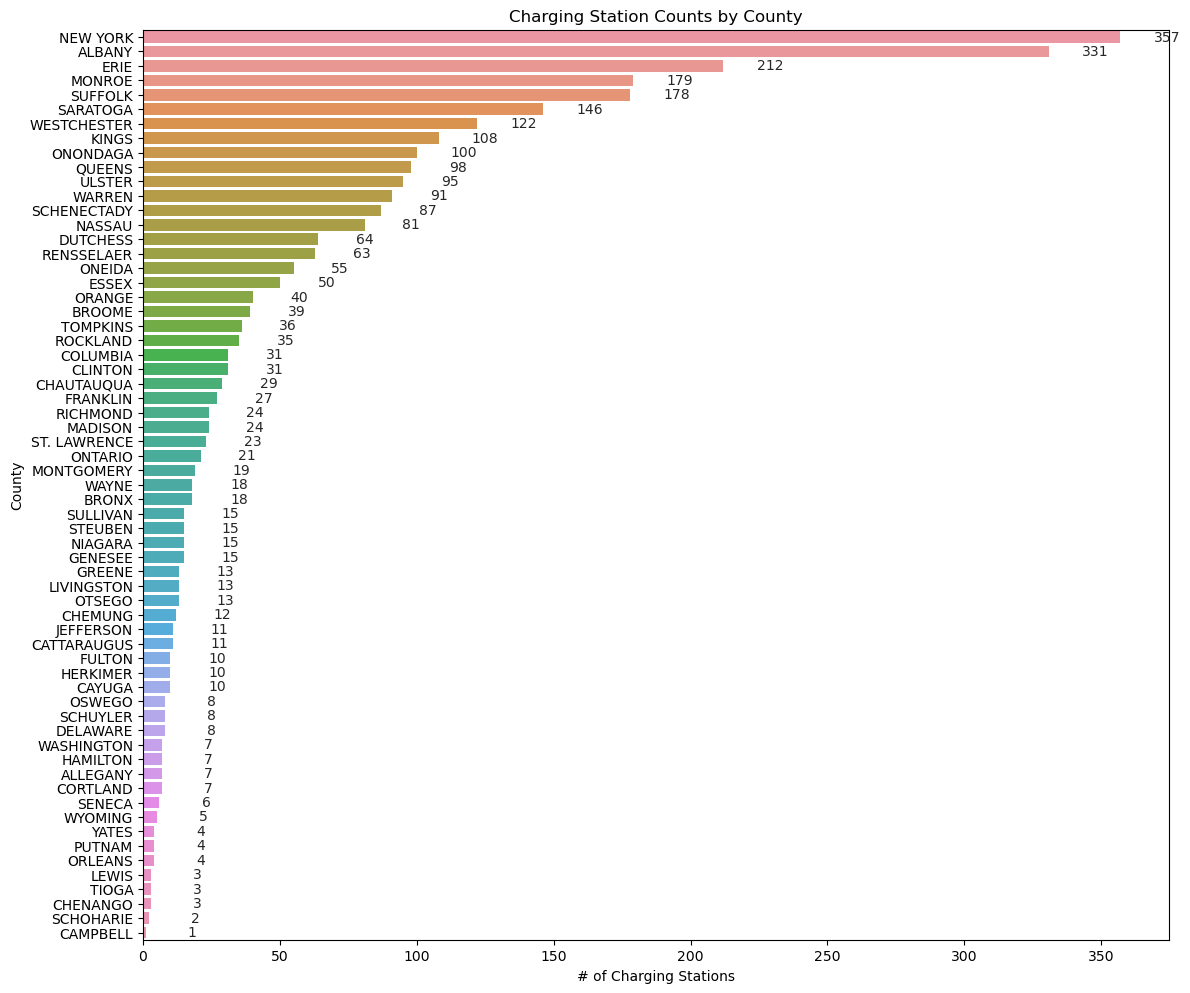

In [159]:
# showing how many stations there are in each county and save this information.
fig, ax = plt.subplots()
with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x='Charger Count', y='County', data=df_charger_counts, orient='h', ax=ax)
    ax.set_title('Charging Station Counts by County')
    ax.set_xlabel('# of Charging Stations')
    x_labels = list(df_charger_counts['Charger Count'])
    rects = ax.patches

    for rect, label in zip(rects, x_labels):
        width = rect.get_width()
        ax.text(rect.get_width()+17, rect.get_y()+0.5*rect.get_height(),
                 '%d' % int(width),
                 ha='center', va='center')
    plt.tight_layout();
plt.savefig('images/charger_counts.png', facecolor='white')

Above, we can see that Ney York County has by far the most amount of chargers compared to other counties followed by Albany and Erie.

In [160]:
#saving the df for dashboarding
path = 'Resources'
output_file = os.path.join(path,f'df_charger_counts.csv') 
df_charger_counts.to_csv(output_file, index=False)

## County Comparison

### Creating a DataFrame for Comparison

All of the information we have been gathering needs to be put together into one dataframe in order to compare the top 6 counties accurately. In order to figure out how many electric vehicles each county has on May 31, 2021 and August 31, 2023, we will look at the numbers of cars added over the next two years, as well as what the ratio is between these numbers and the number of charging stations in each county.

In [161]:

top_6_county = ['KINGS', 'NASSAU','SUFFOLK','WESTCHESTER','QUEENS','NEW YORK']

In [162]:
comparison_df=pd.DataFrame()
i=0
for county in top_6_county:
    print(county)
    comparison_df.loc[i, 'County']=county
    
    comparison_df.loc[i, 'EV Count for 2021-05-31']= \
    county_information[county]['df']["EV's on the Road"][-1]
    
    print(round(county_information[county]['Predictions']['Predictions'][13],0))
    comparison_df.loc[i, 'EV Prediction for 2023-08-31'] = \
    round(county_information[county]['Predictions']['Predictions'][13],0)
    
    
    comparison_df.loc[i, 'Existing Charger Count'] = \
    df_charger_counts.loc[df_charger_counts['County'] == county, 'Charger Count'].iloc[0]
    i+=1

comparison_df['Chargers per EV'] = \
round(comparison_df['Existing Charger Count']/\
      comparison_df['EV Prediction for 2023-08-31'],3)

comparison_df['EVs per Charger'] = \
round(comparison_df['EV Prediction for 2023-08-31']/\
      comparison_df['Existing Charger Count'],0)

comparison_df['EVs Added (Today-2023)'] = \
comparison_df['EV Prediction for 2023-08-31'] - comparison_df['EV Count for 2021-05-31']

comparison_df.sort_values('EV Prediction for 2023-08-31', ascending=False, 
                          inplace=True)
comparison_df.set_index('County', inplace=True)


KINGS
10486.0
NASSAU
17778.0
SUFFOLK
12134.0
WESTCHESTER
9969.0
QUEENS
8262.0
NEW YORK
6538.0


As we can see above, according to our models, we are predicting that most amount of electric vehicles will be joining the roads in NASSAU County. However, the most amount of charging stations are in New York. This is not exactly unexpected since the largest city in Ney York State is in New York.

To find a valid answer to our question, we will calculate the "Evs per charger" number. the higher the value, it will be better to invest.


In [163]:
col_list = list(comparison_df.columns)
col_list.remove('Chargers per EV')

In [164]:
for col in col_list:
    comparison_df[col] = comparison_df[col].astype('int64')

In [165]:
comparison_df.sort_values('EVs per Charger', ascending=False, inplace=True)
comparison_df.style.background_gradient(axis=0, subset=['EVs per Charger'], 
                                        cmap='RdYlGn')
# comparison_df.style.applymap('green', subset=pd.IndexSlice['Island'])

When we sort by "EVs per Charger" column, we see that NASSAU County followed by KINGS and QUEENS counties have by far the highest values. This suggests that these counties will have more potential for setting charging stations in the future. 

However, this does not show us the full picture. Several factors such as climate, population, population age, income and etc have significant impact on the purchase of the EVs. In the next step of our project we will focouse on this aspect and create a deep learning model.

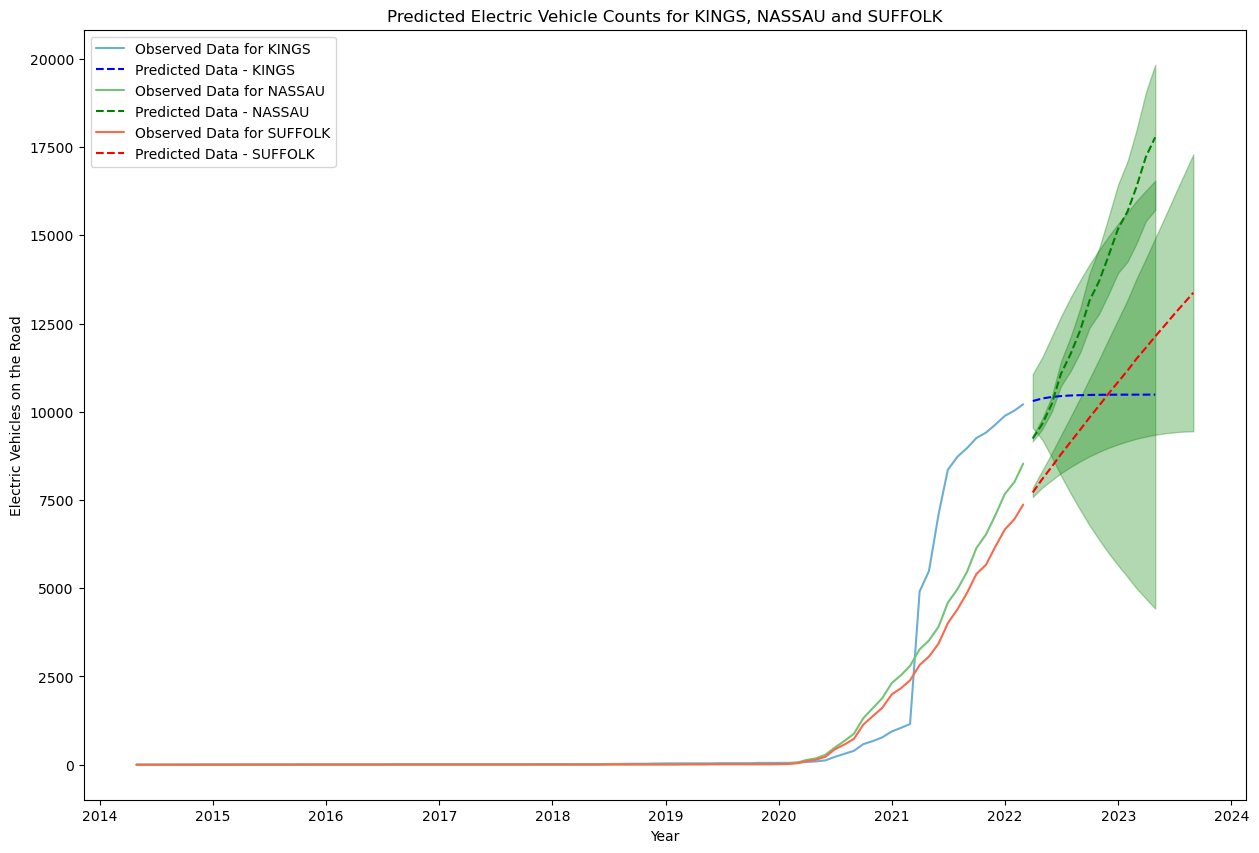

In [166]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicles on the Road')
ax.set_title(f'Predicted Electric Vehicle Counts for KINGS, NASSAU and SUFFOLK')

for county in ['KINGS', 'NASSAU', 'SUFFOLK']:
    prediction_df = county_information[county]['Predictions']
    
    if county == 'KINGS':
        palette = 'Blues'
        color='blue'
    elif county == 'NASSAU':
        palette='Greens'
        color='green'
    else:
        palette='Reds'
        color='red'
    with plt.style.context('seaborn-whitegrid'):
                county_df = county_information[county]['df']
                county_df.columns=[f'Observed Data for {county}']
                sns.lineplot(data=county_df, ax=ax, 
                             palette=palette)
                sns.lineplot(data=prediction_df, x=prediction_df.index, 
                             y='Predictions', color=color, ax=ax,  
                             label=f'Predicted Data - {county}', ls='--')
                ax.fill_between(prediction_df.index, 
                                y1=prediction_df['Lower Confidence Interval'], 
                                y2=prediction_df['Upper Confidence Interval'], 
                                alpha=0.3, color='green')
ax.legend(loc=2);

In [168]:
# Saving New York registration clean data to CSV
NYS_registrations_df.to_csv('Resources/NYS_EV_Registrations.csv')